In [1]:
%matplotlib inline
import os
import re
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from skimage import measure, io, exposure
import matplotlib.pyplot as plt
import mahotas as mh
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker

/home/ws/ih7618/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

def _plot_data_representation(data, idx):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1, 1, 1)
    ax.axis('off')
    ax.imshow(data[:,:,:,idx])
    
def _plot_func_representation(data_func, idx):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1, 1, 1)
    ax.axis('off')
    ax.imshow(data_func(idx))
        
def show_data_func(data_func, num_slices):
    interact(_plot_func_representation, \
             data_func=fixed(data_func), \
             idx=widgets.IntSlider(min=0, max=num_slices-1))
    
def show_data(data):
    interact(_plot_data_representation, \
             data=fixed(data), \
             idx=widgets.IntSlider(min=0, max=data.shape[-1]-1), width=600)

In [3]:
def save_fig(fig, output_filepath, dpi=72, bbox_inches=None, pad_inches=0.1, use_tightlayout=False):
    output_path, filename = os.path.split(output_filepath)
        
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    if use_tightlayout:
        plt.tight_layout()
        
    fig.savefig(output_filepath, transparent=False, bbox_inches=bbox_inches, pad_inches=pad_inches, dpi=dpi)

In [4]:
def number(val):
    if val < 1000:
        return '%d' % val
        
    sv = str(val)
    return '$\mathregular{10^{%d}}$' % (len(sv)-2) if val % 10 == 0 else '%0.0e' % val

In [5]:
def get_data_by_type(path, type, unit_scale=1.8):
    if type == 'p':
        data = pd.read_csv(path)['area'] * (unit_scale**3)
    elif type == 'd':
        data = np.load(path).item()
        data = data['diameter']
        data = data * unit_scale * 2
    else:
        return None
    
    return data

In [6]:
def get_result_path(sample_name, input_dir, data_folder_name=None, type='p', window_size=31):
    if type == 'd':
        return os.path.join(input_dir, '{sample_name}_diameter_evaluation.npy'.format(sample_name=sample_name))
    elif type == 'o':
        return os.path.join(input_dir, '{sample_name}_w{window_size}_orientation_evaluation.npy'.format(sample_name=sample_name, window_size=window_size))
    elif type == 'p':
        return os.path.join(input_dir, sample_name, data_folder_name, 'particles.csv'.format(sample_name=sample_name))
    else:
        return None

In [7]:
def get_result_path_v2(sample_name, input_dir, type='p', window_size=31):
    if type == 'd':
        return os.path.join(input_dir, '{sample_name}_diameter_evaluation.npy'.format(sample_name=sample_name))
    elif type == 'o':
        return os.path.join(input_dir, '{sample_name}_w{window_size}_orientation_evaluation.npy'.format(sample_name=sample_name, window_size=window_size))
    elif type == 'p':
        return os.path.join(input_dir, 'particles.csv'.format(sample_name=sample_name))
    else:
        return None

In [8]:
DEF_COLOR = ['#6c569e', '#9c84c0', '#cebce2', '#dacade', '#e3d6e6', '#f3e9f2']

In [9]:
COLORS_OLD = {
    'blue':   ['#077ca7', '#11a5cb', '#42c3d9', '#85d7e2', '#a4e1e4', '#dff4f5'], \
    'green':  ['#447a6d', '#6ea393', '#93c3b3', '#b8daca', '#dceee2', '#ecf4ee'], \
    'violet': ['#6c569e', '#9c84c0', '#cebce2', '#dacade', '#e3d6e6', '#f3e9f2'], \
    'red':    ['#b64b77', '#d07297', '#e492b6', '#f2b8ce', '#fadadf', '#fce8eb']
}

In [10]:
COLORS = {
    'green': ['#005600', '#007f00', '#00a100', '#00c900', '#00ef00'], \
    'blue':  ['#034bf1', '#2e6af3', '#648ff3', '#9fb9f6', '#c8d5f8'], \
    'red':   ['#6b0000', '#910000', '#af0b0b', '#d41c1c', '#e34848'], \
    'black': ['#000000', '#4b4b4b', '#808080', '#cdcdcd', '#e5e5e5']
}

In [11]:
COLORS_NEW = {
    'green': ['#005500', '#007F00', '#039F05', '#08B50E'], \
    'gray':  ['#797979', '#919191', '#ABABAB', '#D2D2D2'], \
    'violet':['#450083', '#63019C', '#8105BD', '#A426DA'], \
    'orange':['#4C360C', '#865000', '#A86700', '#B37E1B']
}

In [12]:
def plot_histogram(data, fig=None, splot_index=111,
                   num_bins=50, scale=2., exp_fontsize=14, 
                   labels_fontsize=18, grid_alpha=0.4,
                   figsize=(12,8),
                   ylim=(None,None), xlim=(None,None),
                   xticks=None, yticks=None,
                   use_sci_yaxis=True, use_sci_xaxis=False,
                   ticks_pad=10, color='#19B5FE', 
                   ylabel=None, xlabel=None, 
                   yticks_fontsize=18, xticks_fontsize=18,
                   title=None, bar_width=None, 
                   title_fontsize=22,
                   labelpad=2, use_xlocator=False,
                   use_log=False, normed=True, type=None):
    if fig is None:
        fig = plt.figure(figsize=tuple([v * scale for v in figsize]))
        
    ax = fig.add_subplot(splot_index)
    
    n, bins, patches = ax.hist(data, num_bins, normed=normed, color=color, rwidth=bar_width)

    mu, sigma = np.mean(data), np.std(data)
    y = mlab.normpdf(bins, mu, sigma)
    ax.plot(bins, y, '--', linewidth=2*scale)
    
    ax.tick_params(color='black', labelcolor='black', direction='out', pad=ticks_pad*scale)
    ax.tick_params(axis='y', which='major', labelsize=yticks_fontsize*scale)
    ax.tick_params(axis='x', which='major', labelsize=xticks_fontsize*scale)
    
    if xticks is not None:
        pos = np.linspace(xticks.min(), xticks.max(), num=len(xticks))
        plt.xticks(xticks, xticks)
        
    ax.xaxis.offsetText.set_fontsize(exp_fontsize*scale)
    ax.yaxis.offsetText.set_fontsize(exp_fontsize*scale)
    
    if use_sci_yaxis:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2), fontsize=exp_fontsize*scale)
    
    if use_sci_xaxis:
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2), fontsize=exp_fontsize*scale)
    
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6, min_n_ticks=5))
    
    if use_xlocator:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(prune='lower'))
    
    ax.xaxis.grid(False)
    ax.yaxis.grid(lw=1*scale, color='#aaaaaa', alpha=grid_alpha)
    
    if ylabel is not None:
        ax.set_ylabel(ylabel, labelpad=labelpad*scale, fontsize=labels_fontsize*scale, color='black')
        
    if xlabel is not None:
        ax.set_xlabel(xlabel, labelpad=labelpad*scale, fontsize=labels_fontsize*scale, color='black')
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    ax.set_axisbelow(True)
    
    if use_log:
        ax.set_yscale('log')
    
    if title is not None:
        ax.set_title(title, fontsize=title_fontsize*scale, y=1.06)
    
    return fig, ax

In [13]:
def plot_histogram_fig(data, num_bins, xticks, splot_index=111, 
                       scale=1., xlim=(None,None), ylim=(None,None),
                       bar_width=0.8, ticks_pad=7, xticks_fontsize=22, 
                       yticks_fontsize=22, xlabel=None, ylabel=None,
                       labels_fontsize=20, grid_alpha=0.3, title_fontsize=22, 
                       exp_fontsize=15, type=None, figsize=(12,8), norm=True):
    fig = plt.figure(figsize=tuple([v*scale for v in figsize]))
    ax = fig.add_subplot(splot_index)
    n, bins, patches = ax.hist(data, 50, normed=1, color='#19B5FE', rwidth=bar_width)

    if norm:
        mu, sigma = np.mean(data), np.std(data)
        y = mlab.normpdf(bins, mu, sigma)
        ax.plot(bins, y, '--', linewidth=2*scale)
    
    ax.tick_params(color='black', labelcolor='black', direction='out', pad=ticks_pad*scale)
    ax.tick_params(axis='y', which='major', labelsize=yticks_fontsize*scale)
    ax.tick_params(axis='x', which='major', labelsize=xticks_fontsize*scale)
    
    pos = np.linspace(xticks.min(), xticks.max(), num=len(xticks))
    plt.xticks(xticks, xticks)
        
    ax.xaxis.offsetText.set_fontsize(exp_fontsize*scale)
    ax.yaxis.offsetText.set_fontsize(exp_fontsize*scale)
    
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2), fontsize=yticks_fontsize*scale)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6, min_n_ticks=5))

    ax.xaxis.grid(False)
    ax.yaxis.grid(lw=1*scale, color='#aaaaaa', alpha=grid_alpha)

    ax.set_ylabel(ylabel, labelpad=2*scale, fontsize=labels_fontsize*scale, color='black')
    ax.set_xlabel(xlabel, labelpad=2*scale, fontsize=labels_fontsize*scale, color='black')
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    ax.set_axisbelow(True)
    
    return fig, ax

In [14]:
def plot_orientation_old(dpy_path, sample_params, sample_name, input_dir, save_plot_dir, lang='en', **kwargs):
    for key, params in sample_params.items():
        dpy = np.load(dpy_path).item()[key]
        dpy = np.rad2deg(dpy)
        dpy = dpy[np.where(dpy > 0)]
        
        fig, ax = plot_histogram_fig(dpy,
                                 num_bins=params[2],
                                 xticks=np.linspace(params[1][0], params[1][1], num=10).astype(np.int32),
                                 xlim=params[1],
                                 **kwargs)
        
        save_fig(fig, os.path.join(save_plot_dir, sample_name, '_'.join([sample_name, key, 'orientation', lang]) + '.png'),
                 bbox_inches='tight',
                 pad_inches=0.1,
                 use_tightlayout=True)

In [15]:
def plot_orientation(dpy_path, sample_params, **kwargs):
    for key, params in sample_params.items():
        dpy = np.rad2deg(np.load(dpy_path).item()[key])
        dpy = dpy[np.where(dpy > 0)]
        
        xmin, xmax = params[1]
        N = 180
        
        theta = np.linspace(0., 2.*np.pi, N, endpoint=False)
        width = np.pi / N
        hist, bins = np.histogram(dpy, bins=theta)
        
        ax = plt.subplot(111, projection='polar')
        bars = ax.bar(theta, hist, width=width, bottom=0.0)
        
        for r, bar in zip(radii, bars):
            bar.set_facecolor(plt.cm.viridis(r / 10.))
            bar.set_alpha(0.5)

        plt.show()

In [16]:
def plot_diameter(dpy_path, sample_params, save_plot_dir, unit_scale=1.8, **kwargs):
    for key, params in sample_params.items():
        dpy = np.load(dpy_path).item()[key]
        dpy = dpy[np.where(dpy > 0)]
        dpy = dpy * unit_scale * 2
        dpy = dpy[np.where(dpy <= params[2])]
        
        fig, ax = plot_histogram(dpy,
                                 title=params[0],
                                 num_bins=params[1],
                                 **kwargs)

In [17]:
def plot_from_samples(input_dir, sample_names, sample_params, save_plot_dir, type='o', window_size=31, **kwargs):
    for sample_name in sample_names:
        dpy_path = get_result_path(sample_name, input_dir, type=type, window_size=window_size)
        
        print 'Sample: {0} ({1})'.format(sample_name, dpy_path)
        
        if type == 'o':
            plot_orientation_old(dpy_path, sample_params, sample_name, input_dir, save_plot_dir, type=type, **kwargs)
        elif type == 'd':
            plot_diameter(dpy_path, sample_params, save_plot_dir, type=type, **kwargs)
        else:
            raise ValueError('Incorrect type.')

In [18]:
def number_v2(val):
    if val < 1000:
        return '%d' % val
        
    sv = str(val)
    return '$\mathregular{10^{%d}}$' % (len(sv)-1) if val % 10 == 0 else '%0.0e' % val

In [19]:
def create_pie_chart_v3(sample_name, input_dir, output_dir, rngs, title=None, \
                     type='p', unit_scale=1.8, lang='en', measure_type='vol', 
                     zebra_color=(False,3), legend_fontsize=50, legend_loc=(0.383,-0.35), chart_fontsize=60, dpi=72,
                     color_name=None, in_voxels=False):
    dpy_path = get_result_path_v2(sample_name, input_dir, type=type)
    df = get_data_by_type(dpy_path, type=type, unit_scale=unit_scale)
    
    print ('Max: {}, Min: {}'.format(df.max(), df.min()))
    print sample_name
    
    data_ranges = []
    for rng in rngs:
        rng_min, rng_max = rng[0], rng[1]
        data_rng = df[(df > rng_min) & (df < rng_max)]
        if len(data_rng):
            print '({} - {}) [{} - {}]'.format(rng[0], rng[-1], data_rng.min(), data_rng.max())
        data_ranges.append(data_rng)
    
    if type == 'd':
        sum_diameters = np.concatenate(data_ranges)
        print ('Sample: ({}, diameter) Mean: {}  Std: {}'.format(sample_name, np.mean(sum_diameters), np.std(sum_diameters)))
        
    if type == 'p':
        sum_areas = np.concatenate(data_ranges)
        sum_radii = (3. * sum_areas / 4. * np.pi) ** (1./3.)
        print ('Sample: ({}, radius) Mean: {}  Std: {}'.format(sample_name, np.mean(sum_radii), np.std(sum_radii)))

    num_elem = [len(p) for p in data_ranges]
    se = sum(num_elem)
    
    print ('Num of particles: {}'.format(se))

    proc_particles = [n/float(se) * 100.0 for n in num_elem]
    
    for size, rng in zip(num_elem, rngs):
        print ('{}-{}: {}'.format(rng[0], rng[1], size))
                      
    def get_title(v1, v2, lang, measure_type):
        if measure_type == 'vol':
            if in_voxels:
                measure_quantity = 'vox$^3$' if lang == 'en' else u'вокс$^3$'
            else:
                measure_quantity = 'm^3' if lang == 'en' else u'м^3'
        else:
            if in_voxels:
                measure_quantity = 'vox' if lang == 'en' else u'вокс'
            else:
                measure_quantity = 'm' if lang == 'en' else u'м'
        
        if in_voxels:
            ftm = '%s $\minus$ %s %s' if lang == 'en' else u'%s $\minus$ %s %s'
        else:
            ftm = '%s $\minus$ %s $\mathregular{\mu %s}$' if lang == 'en' else u'%s $\minus$ %s $\mathregular{мк%s}$'
        return ftm % (number_v2(v1), number_v2(v2), measure_quantity)
                      
    titles = [get_title(minv, maxv, lang, measure_type) for minv,maxv in rngs]
    
    if color_name is None:
        colors = COLORS_NEW.get(CODED_NAMES[sample_name], DEF_COLOR)
    else:
        colors = COLORS_NEW.get(color_name, DEF_COLOR)
        
    textprops={'fontsize': chart_fontsize, 'weight': 'normal'}
    pie_width = 0.5
    fig, ax = plt.subplots(figsize=(33,15))
    ax.axis('equal')
    patches, texts, autotexts = ax.pie(proc_particles, \
                                       textprops=textprops, \
                                       colors=colors, \
                                       autopct='%1.1f%%', \
                                       radius=1, \
                                       pctdistance=1-pie_width/2)
    
    if (zebra_color is not None) and (zebra_color[0]):
        for tt in autotexts[:zebra_color[1]]:
            tt.set_color('white')
    
    plt.setp(patches, \
             width=pie_width, \
             edgecolor='white')

    plt.legend(patches, titles, loc=legend_loc, fontsize=legend_fontsize)
    
    _d, _offset, _di = [1,-1], [0.45, 0.45], 0
    
    for t, p in zip(autotexts, proc_particles):
        if p < 2.0:
            pos = list(t.get_position())
            pos[0] = pos[0] + _d[_di] * _offset[_di]

            t.set_position(pos)
            _di += 1

    out_figdir = os.path.join(output_dir, sample_name)
    
    if not os.path.exists(out_figdir):
        os.makedirs(out_figdir)
    
    out_figpath = os.path.join(out_figdir, '_'.join([sample_name, title, 'pie', lang]) + '.png')
    
    plt.tight_layout()
    fig.savefig(out_figpath, bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=dpi)

In [20]:
def create_pie_chart_v2(sample_name, input_dir, output_dir, rngs, data_folder_name='particles_stats', title=None, \
                     type='p', unit_scale=1.8, lang='en', measure_type='vol', 
                     zebra_color=(False,3), legend_fontsize=50, chart_fontsize=60, dpi=72,
                     color_name=None):
    dpy_path = get_result_path(sample_name, input_dir, data_folder_name=data_folder_name, type=type)
    df = get_data_by_type(dpy_path, type=type, unit_scale=unit_scale)
    
    print 'Max: {}, Min: {}'.format(df.max(), df.min())
    
    data_ranges = []
    for rng in rngs:
        rng_min, rng_max = rng[0], rng[1]
        data_rng = df[(df > rng_min) & (df < rng_max)]
        data_ranges.append(data_rng)
    
    num_elem = [len(p) for p in data_ranges]
    se = sum(num_elem)
    
    print 'Num of particles: {}'.format(se)

    proc_particles = [n/float(se) * 100.0 for n in num_elem]
    
    for size, rng in zip(num_elem, rngs):
        print '{}-{}: {}'.format(rng[0], rng[1], size)
                      
    def get_title(v1, v2, lang, measure_type):
        if measure_type == 'vol':
            measure_quantity = 'm^3' if lang == 'en' else u'м^3'
        else:
            measure_quantity = 'm' if lang == 'en' else u'м'
        
        ftm = '%s $\minus$ %s $\mathregular{\mu %s}$' if lang == 'en' else u'%s $\minus$ %s $\mathregular{мк%s}$'
        return ftm % (number(v1), number(v2), measure_quantity)
                      
    titles = [get_title(minv, maxv, lang, measure_type) for minv,maxv in rngs]
    
    if color_name is None:
        colors = COLORS.get(sample_name, DEF_COLOR)
    else:
        colors = COLORS.get(color_name, DEF_COLOR)
        
    textprops={'fontsize': chart_fontsize, 'weight': 'normal', 'family': 'sans-serif'}
    pie_width = 0.5
    fig, ax = plt.subplots(figsize=(33,15))
    ax.axis('equal')
    patches, texts, autotexts = ax.pie(proc_particles, \
                                       textprops=textprops, \
                                       colors=colors, \
                                       autopct='%1.1f%%', \
                                       radius=1, \
                                       pctdistance=1-pie_width/2)
    
    if (zebra_color is not None) and (zebra_color[0]):
        for tt in autotexts[:zebra_color[1]]:
            tt.set_color('white')
    
    plt.setp(patches, \
             width=pie_width, \
             edgecolor='white')

    plt.legend(patches, titles, loc=(0.383,-0.45), fontsize=legend_fontsize)
    
    _d, _offset, _di = [1,-1, 2, -2], [0.45, 0.45, 0.45, 0.45], 0
    
    for t, p in zip(autotexts, proc_particles):
        if p < 2.0:
            pos = list(t.get_position())
            pos[0] = pos[0] + _d[_di] * _offset[_di]

            t.set_position(pos)
            _di += 1

    out_figdir = os.path.join(output_dir, sample_name)
    
    if not os.path.exists(out_figdir):
        os.makedirs(out_figdir)
    
    out_figpath = os.path.join(out_figdir, '_'.join([sample_name, title, 'pie', lang]) + '.png')
    
    plt.tight_layout()
    fig.savefig(out_figpath, bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=dpi)

In [21]:
def create_pie_chart(sample_name, input_dir, rngs, data_folder_name='particles_stats', title=None, \
                     type='p', unit_scale=1.8, color_name=None, lang='en', measure_type='vol', 
                     zebra_color=False, legend_fonsize=50, chart_fonsize=50):
    dpy_path = get_result_path(sample_name, input_dir, data_folder_name=data_folder_name, type=type)
    df = get_data_by_type(dpy_path, type=type, unit_scale=unit_scale)
    
    
    
    print 'Max: {}, Min: {}'.format(df.max(), df.min())
    
    data_ranges = []
    for rng in rngs:
        rng_min, rng_max = rng[0], rng[1]
        data_rng = df[(df > rng_min) & (df < rng_max)]
        data_ranges.append(data_rng)
    
    num_elem = [len(p) for p in data_ranges]
    se = sum(num_elem)

    proc_particles = [n/float(se) * 100.0 for n in num_elem]
    
    for size, rng in zip(num_elem, rngs):
        print '{}-{}: {}'.format(rng[0], rng[1], size)
                      
    def get_title(v1, v2, lang, measure_type):
        if measure_type == 'vol':
            measure_quantity = 'm^3' if lang == 'en' else u'м^3'
        else:
            measure_quantity = 'm' if lang == 'en' else u'м'
        
        ftm = '%s $\minus$ %s $\mathregular{\mu %s}$' if lang == 'en' else u'%s $\minus$ %s $\mathregular{мк%s}$'
        return ftm % (number(v1), number(v2), measure_quantity)
                      
    titles = [get_title(minv, maxv, lang, measure_type) for minv,maxv in rngs]
    
    #colors = ['#1E824C', '#80B584', '#A6CAA9', '#C9DECB', '#E9F1EA'] #green
    #colors = ['#663399', '#AD8BFE', '#C4ABFE', '#BE90D4', '#DDCEFF'] #purple
    colors = ['#ae4900', '#c75400', '#e15e00', '#ff862e', '#ff862e'] #orange
    
    if color_name is None:
        colors = ['#23819C', '#2FAACE', '#57BCD9', '#8CD1E6', '#B8E2EF', '#c4f1ff'] #blue
    else:
        colors = COLORS[color_name] 

    textprops={'fontsize': chart_fonsize, 'weight': 'normal', 'family': 'sans-serif'}
    pie_width = 0.5
    fig, ax = plt.subplots(figsize=(33,15))
    ax.axis('equal')
    patches, texts, autotexts = ax.pie(proc_particles, \
                                       textprops=textprops, \
                                       colors=colors, \
                                       autopct='%1.1f%%', \
                                       radius=1, \
                                       pctdistance=1-pie_width/2)
    
    if zebra_color:
        for tt in autotexts[:2]:
            tt.set_color('white')
    
    plt.setp(patches, \
             width=pie_width, \
             edgecolor='white')

    plt.legend(patches, titles, loc=(0.383,-0.35), fontsize=legend_fonsize)
    
    _d, _offset, _di = [1,-1], [0.45, 0.45], 0
    
    for t, p in zip(autotexts, proc_particles):
        if p < 2.0:
            pos = list(t.get_position())
            pos[0] = pos[0] + _d[_di] * _offset[_di]

            t.set_position(pos)
            _di += 1
    
    if data_folder_name:
        save_fig(fig, 
                 os.path.join(input_dir, sample_name, data_folder_name, '_'.join([sample_name, title, 'pie', lang]) + '.png'),
                 bbox_inches='tight',
                 pad_inches=0.1,
                 use_tightlayout=True)
    else:
        save_fig(fig, os.path.join(input_dir, sample_name, '_'.join([sample_name, title, 'pie', lang]) + '.png'),
                 bbox_inches='tight',
                 pad_inches=0.1,
                 use_tightlayout=True)

# Particles

Max: 126402.768, Min: 5.832
1-100: 1191
100-1000: 1403
1000-10000: 969
10000-100000: 180
100000-1000000: 4


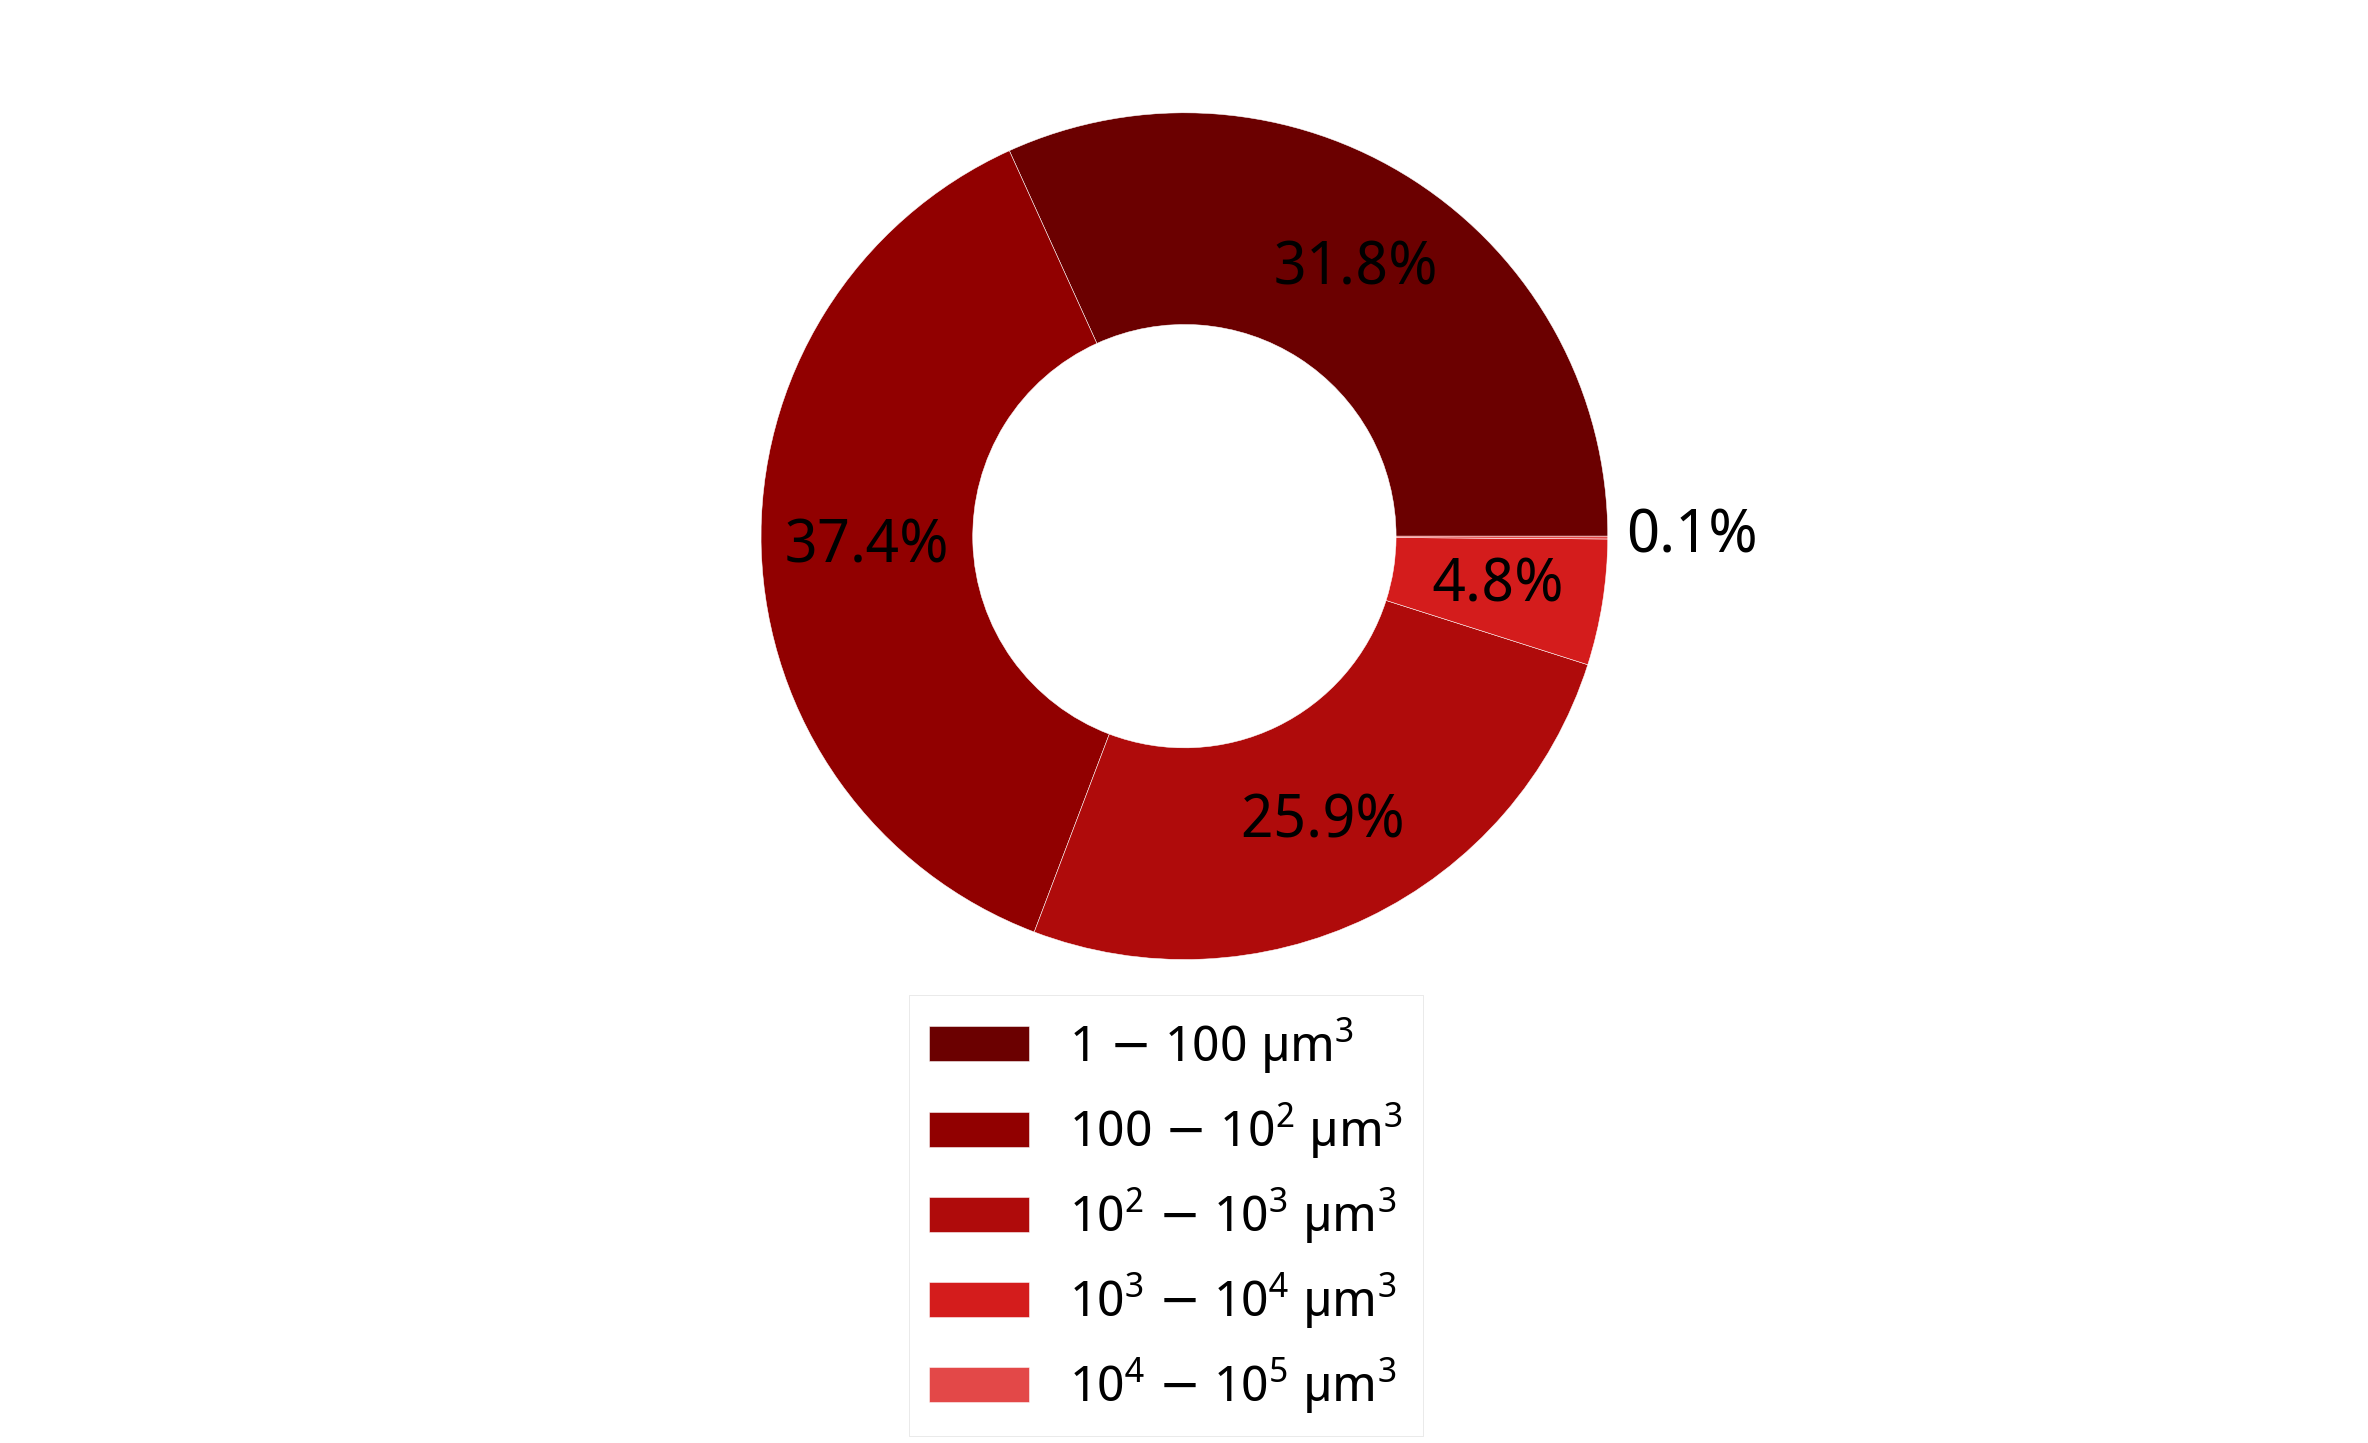

In [306]:
create_pie_chart('PCLSrro', \
                 './data/pcl_results/', \
                 [(1, 100), (100,1000), (1000, 10000), (10000,100000), (100000,1000000)], \
                 data_folder_name='particles_stats', \
                 title='PCLSrro', \
                 type='p', \
                 color_name='red', \
                 lang='en')

Max: 126402.768, Min: 5.832
PCLSrro
(1 - 100) [5.832 - 99.144]
(100 - 1000) [104.976 - 997.272]
(1000 - 10000) [1003.104 - 9931.896]
(10000 - 100000) [10019.376 - 95557.32]
Sample: (PCLSrro, radius) Mean: 11.43727038  Std: 8.60772920606
Num of particles: 3743
1-100: 1191
100-1000: 1403
1000-10000: 969
10000-100000: 180


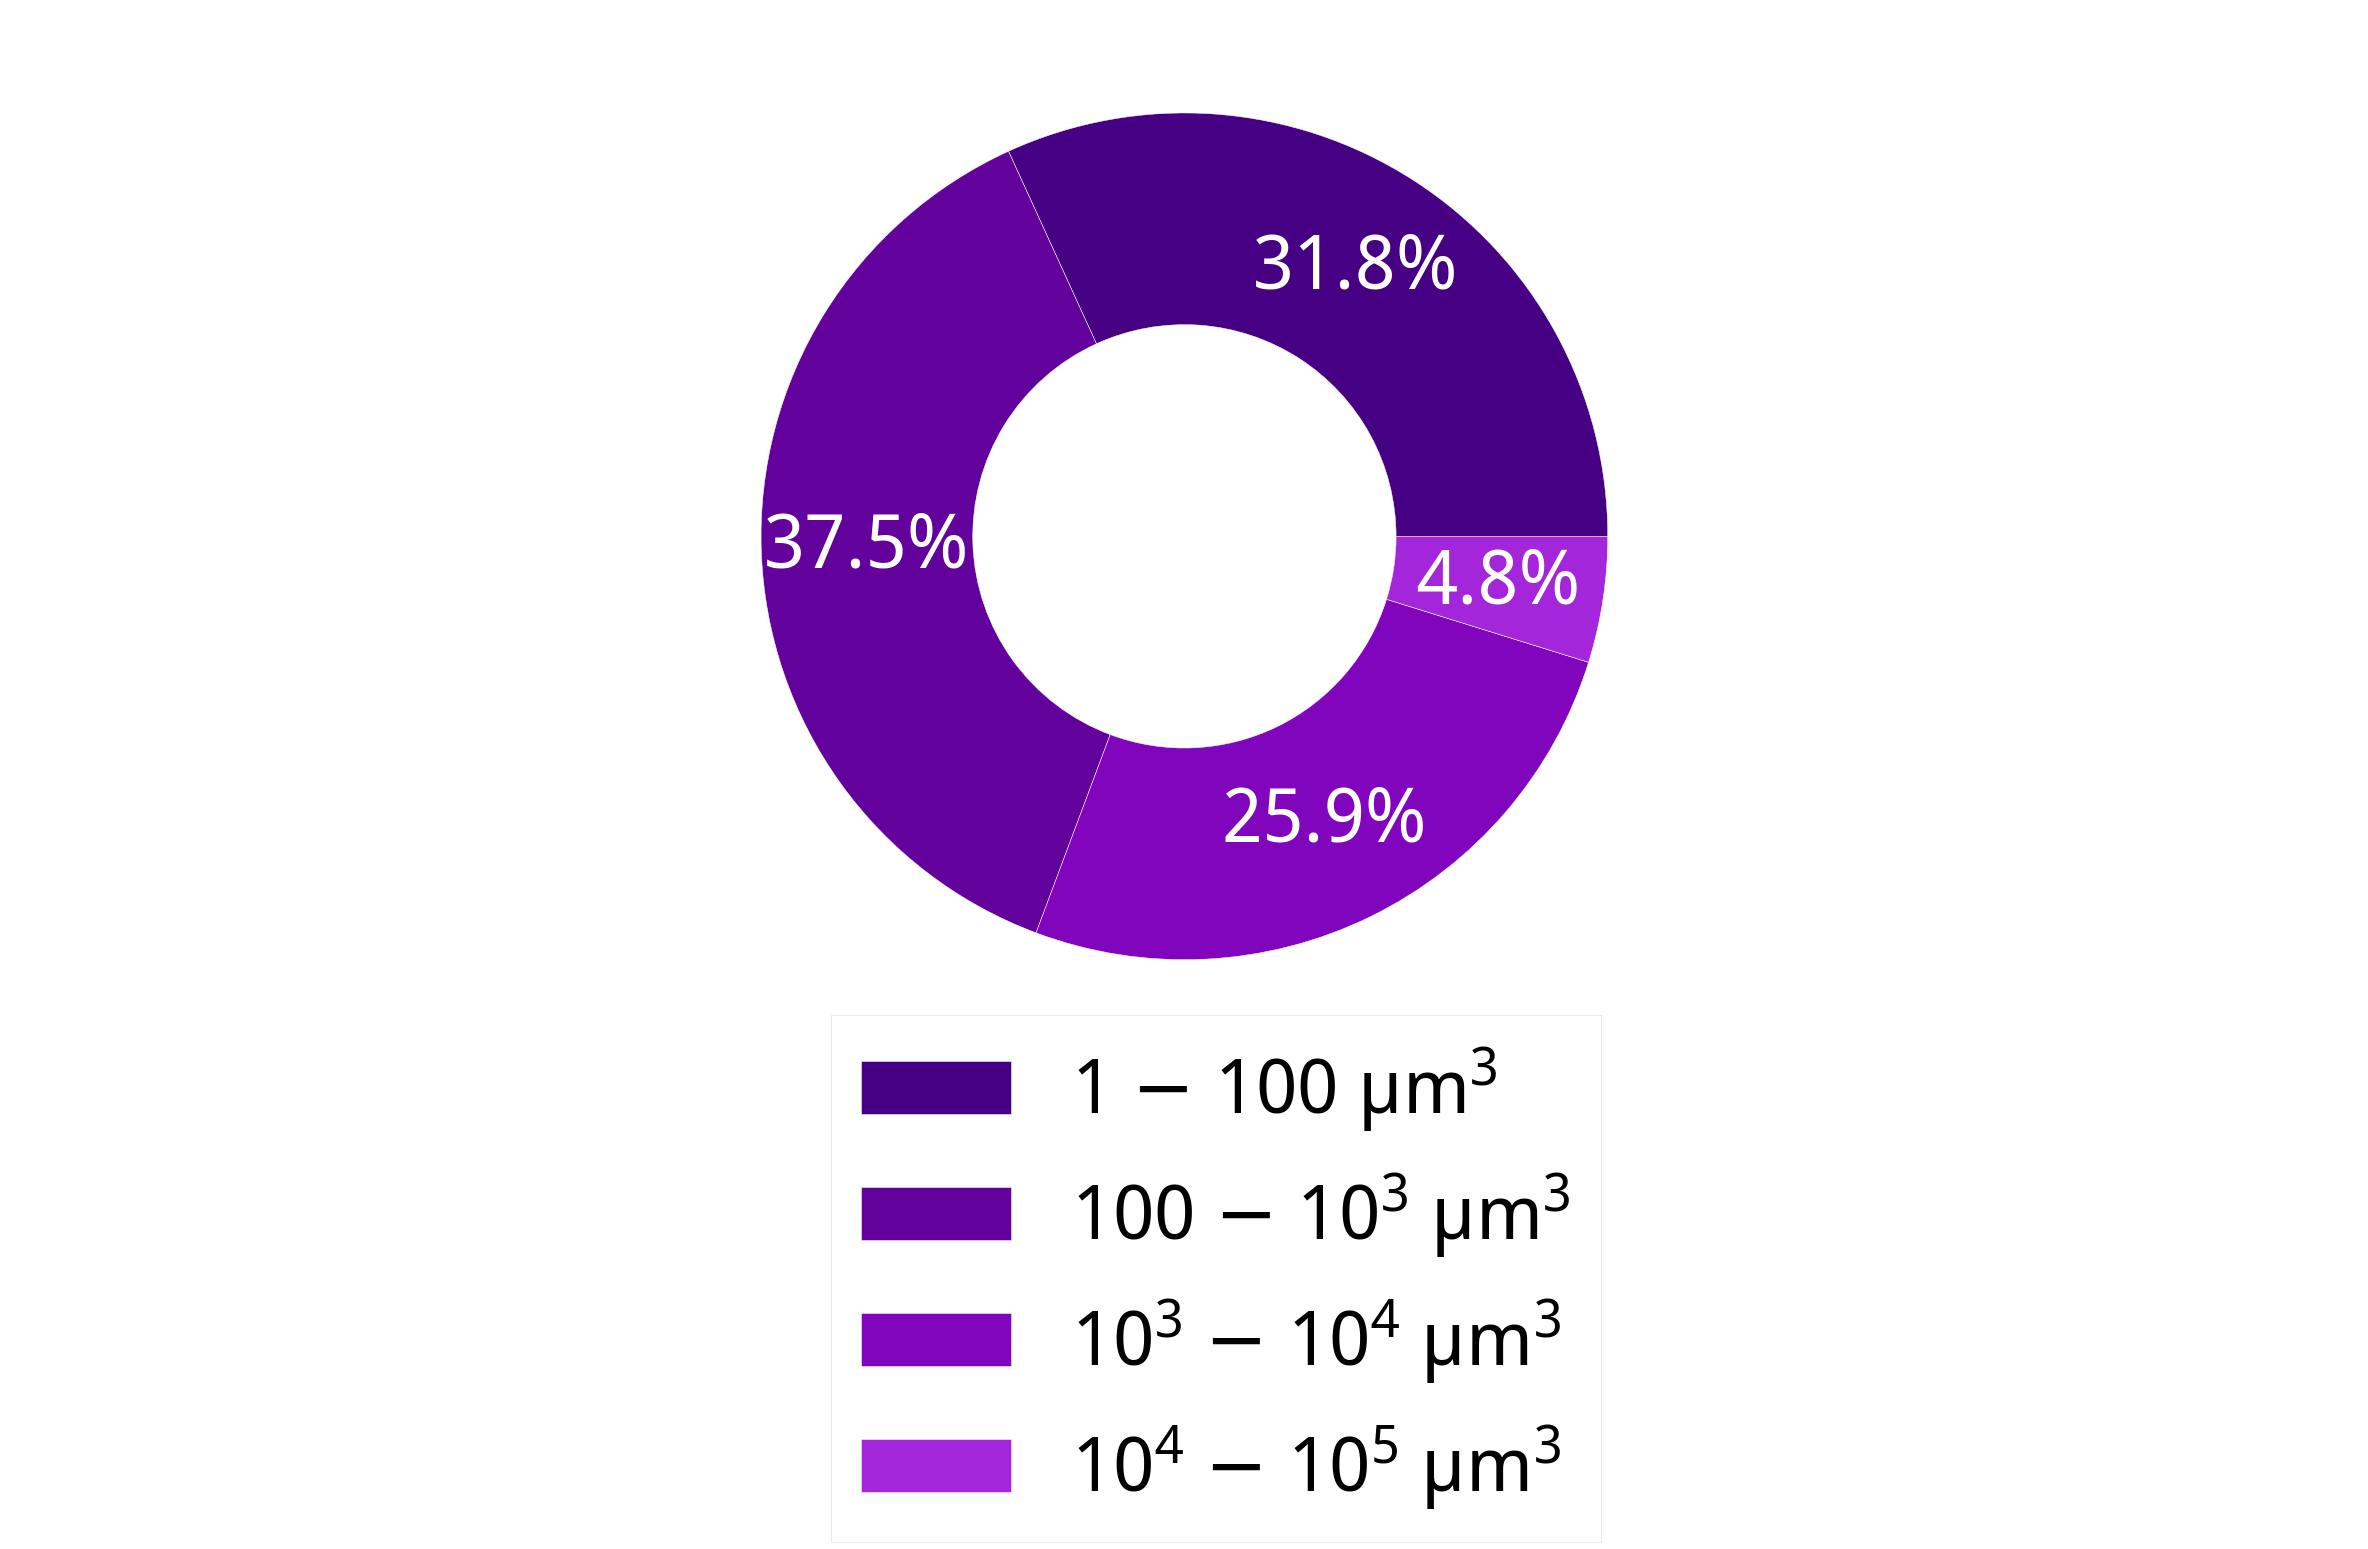

In [85]:
create_pie_chart_v3('PCLSrro', 
                    './data/pcl_results/PCLSrro/particles_stats',
                    './data/pcl_results/results_particles_stats', 
                    [(1, 100), (100,1000), (1000, 10000), (10000,100000)],
                    title='PCLSrro', \
                    type='p',
                    unit_scale=1.8,
                    lang='en',
                    measure_type='vol', 
                    zebra_color=(True,4),
                    legend_fontsize=75,
                    legend_loc=(0.35,-0.45),
                    chart_fontsize=75,
                    dpi=72,
                    color_name='violet',
                    in_voxels=False)

Max: 507652.272, Min: 5.832
1-100: 2813
100-1000: 3191
1000-10000: 1388
10000-100000: 163
100000-1000000: 1


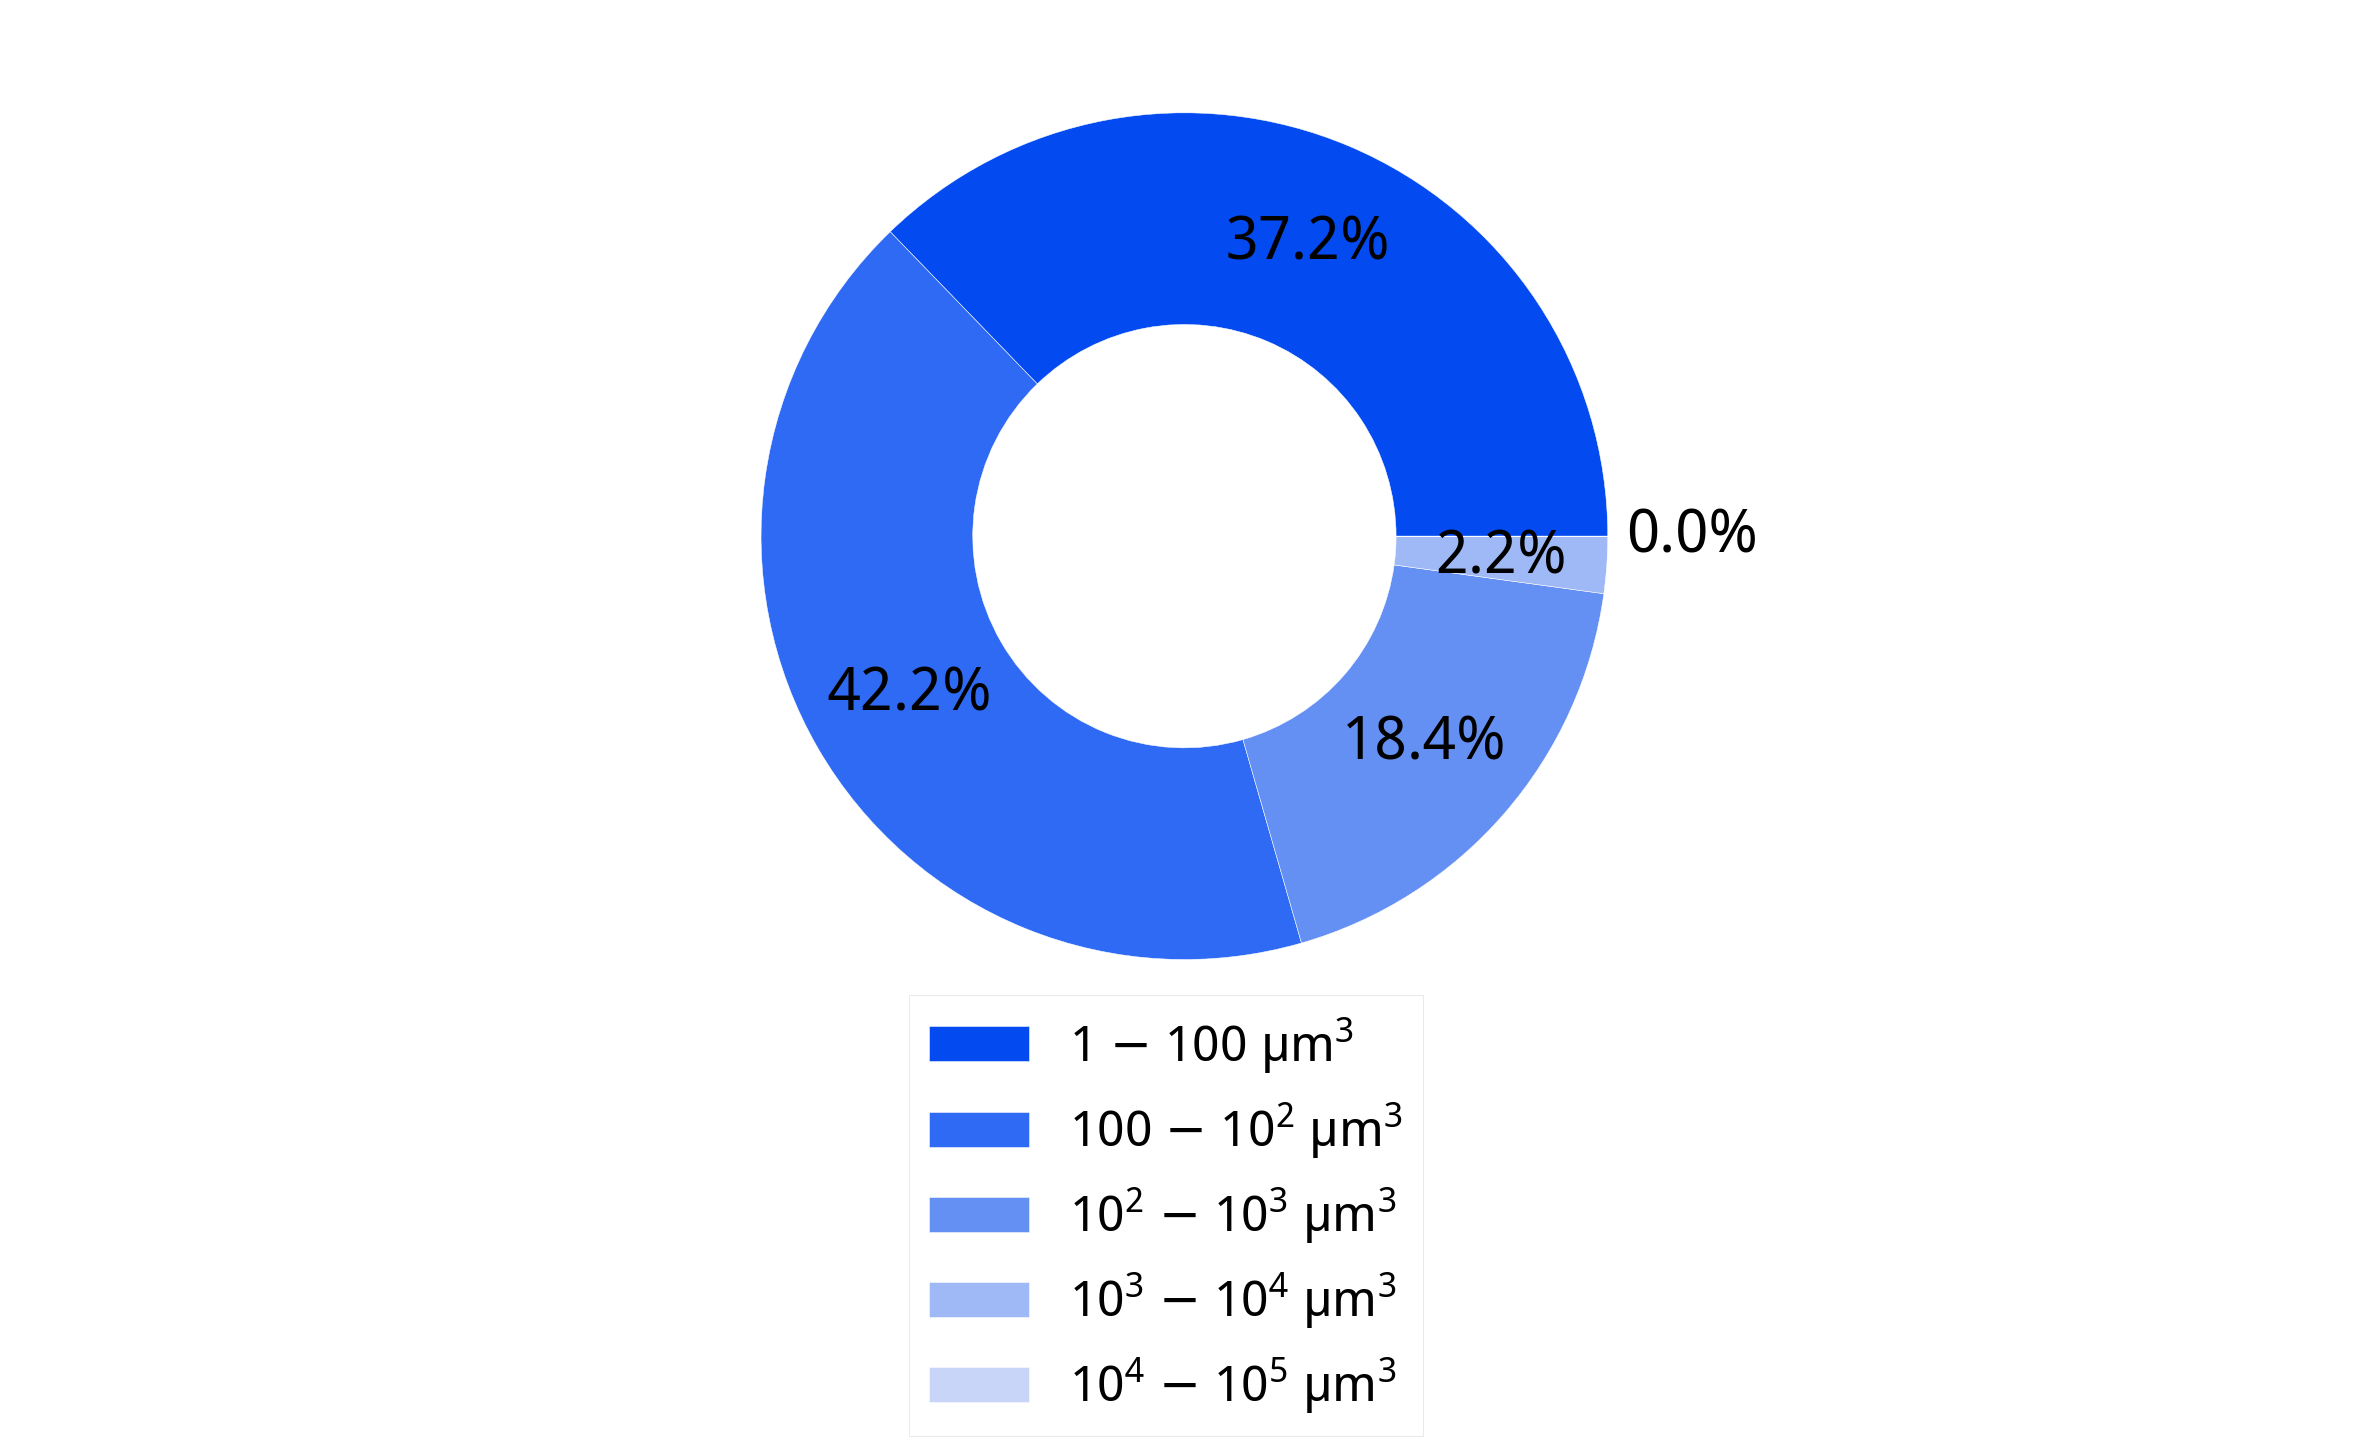

In [307]:
create_pie_chart('PCLSiro', \
                 './data/pcl_results', \
                 [(1, 100), (100,1000), (1000, 10000), (10000,100000), (100000,1000000)], \
                 data_folder_name='particles_stats', \
                 title='PCLSiro', \
                 type='p', \
                 color_name='blue', \
                 lang='en')

Max: 507652.272, Min: 5.832
PCLSiro
(1 - 100) [5.832 - 99.144]
(100 - 1000) [104.976 - 997.272]
(1000 - 10000) [1003.104 - 9984.384]
(10000 - 100000) [10048.536 - 93026.232]
Sample: (PCLSiro, radius) Mean: 9.47382002198  Std: 6.76756531497
Num of particles: 7555
1-100: 2813
100-1000: 3191
1000-10000: 1388
10000-100000: 163


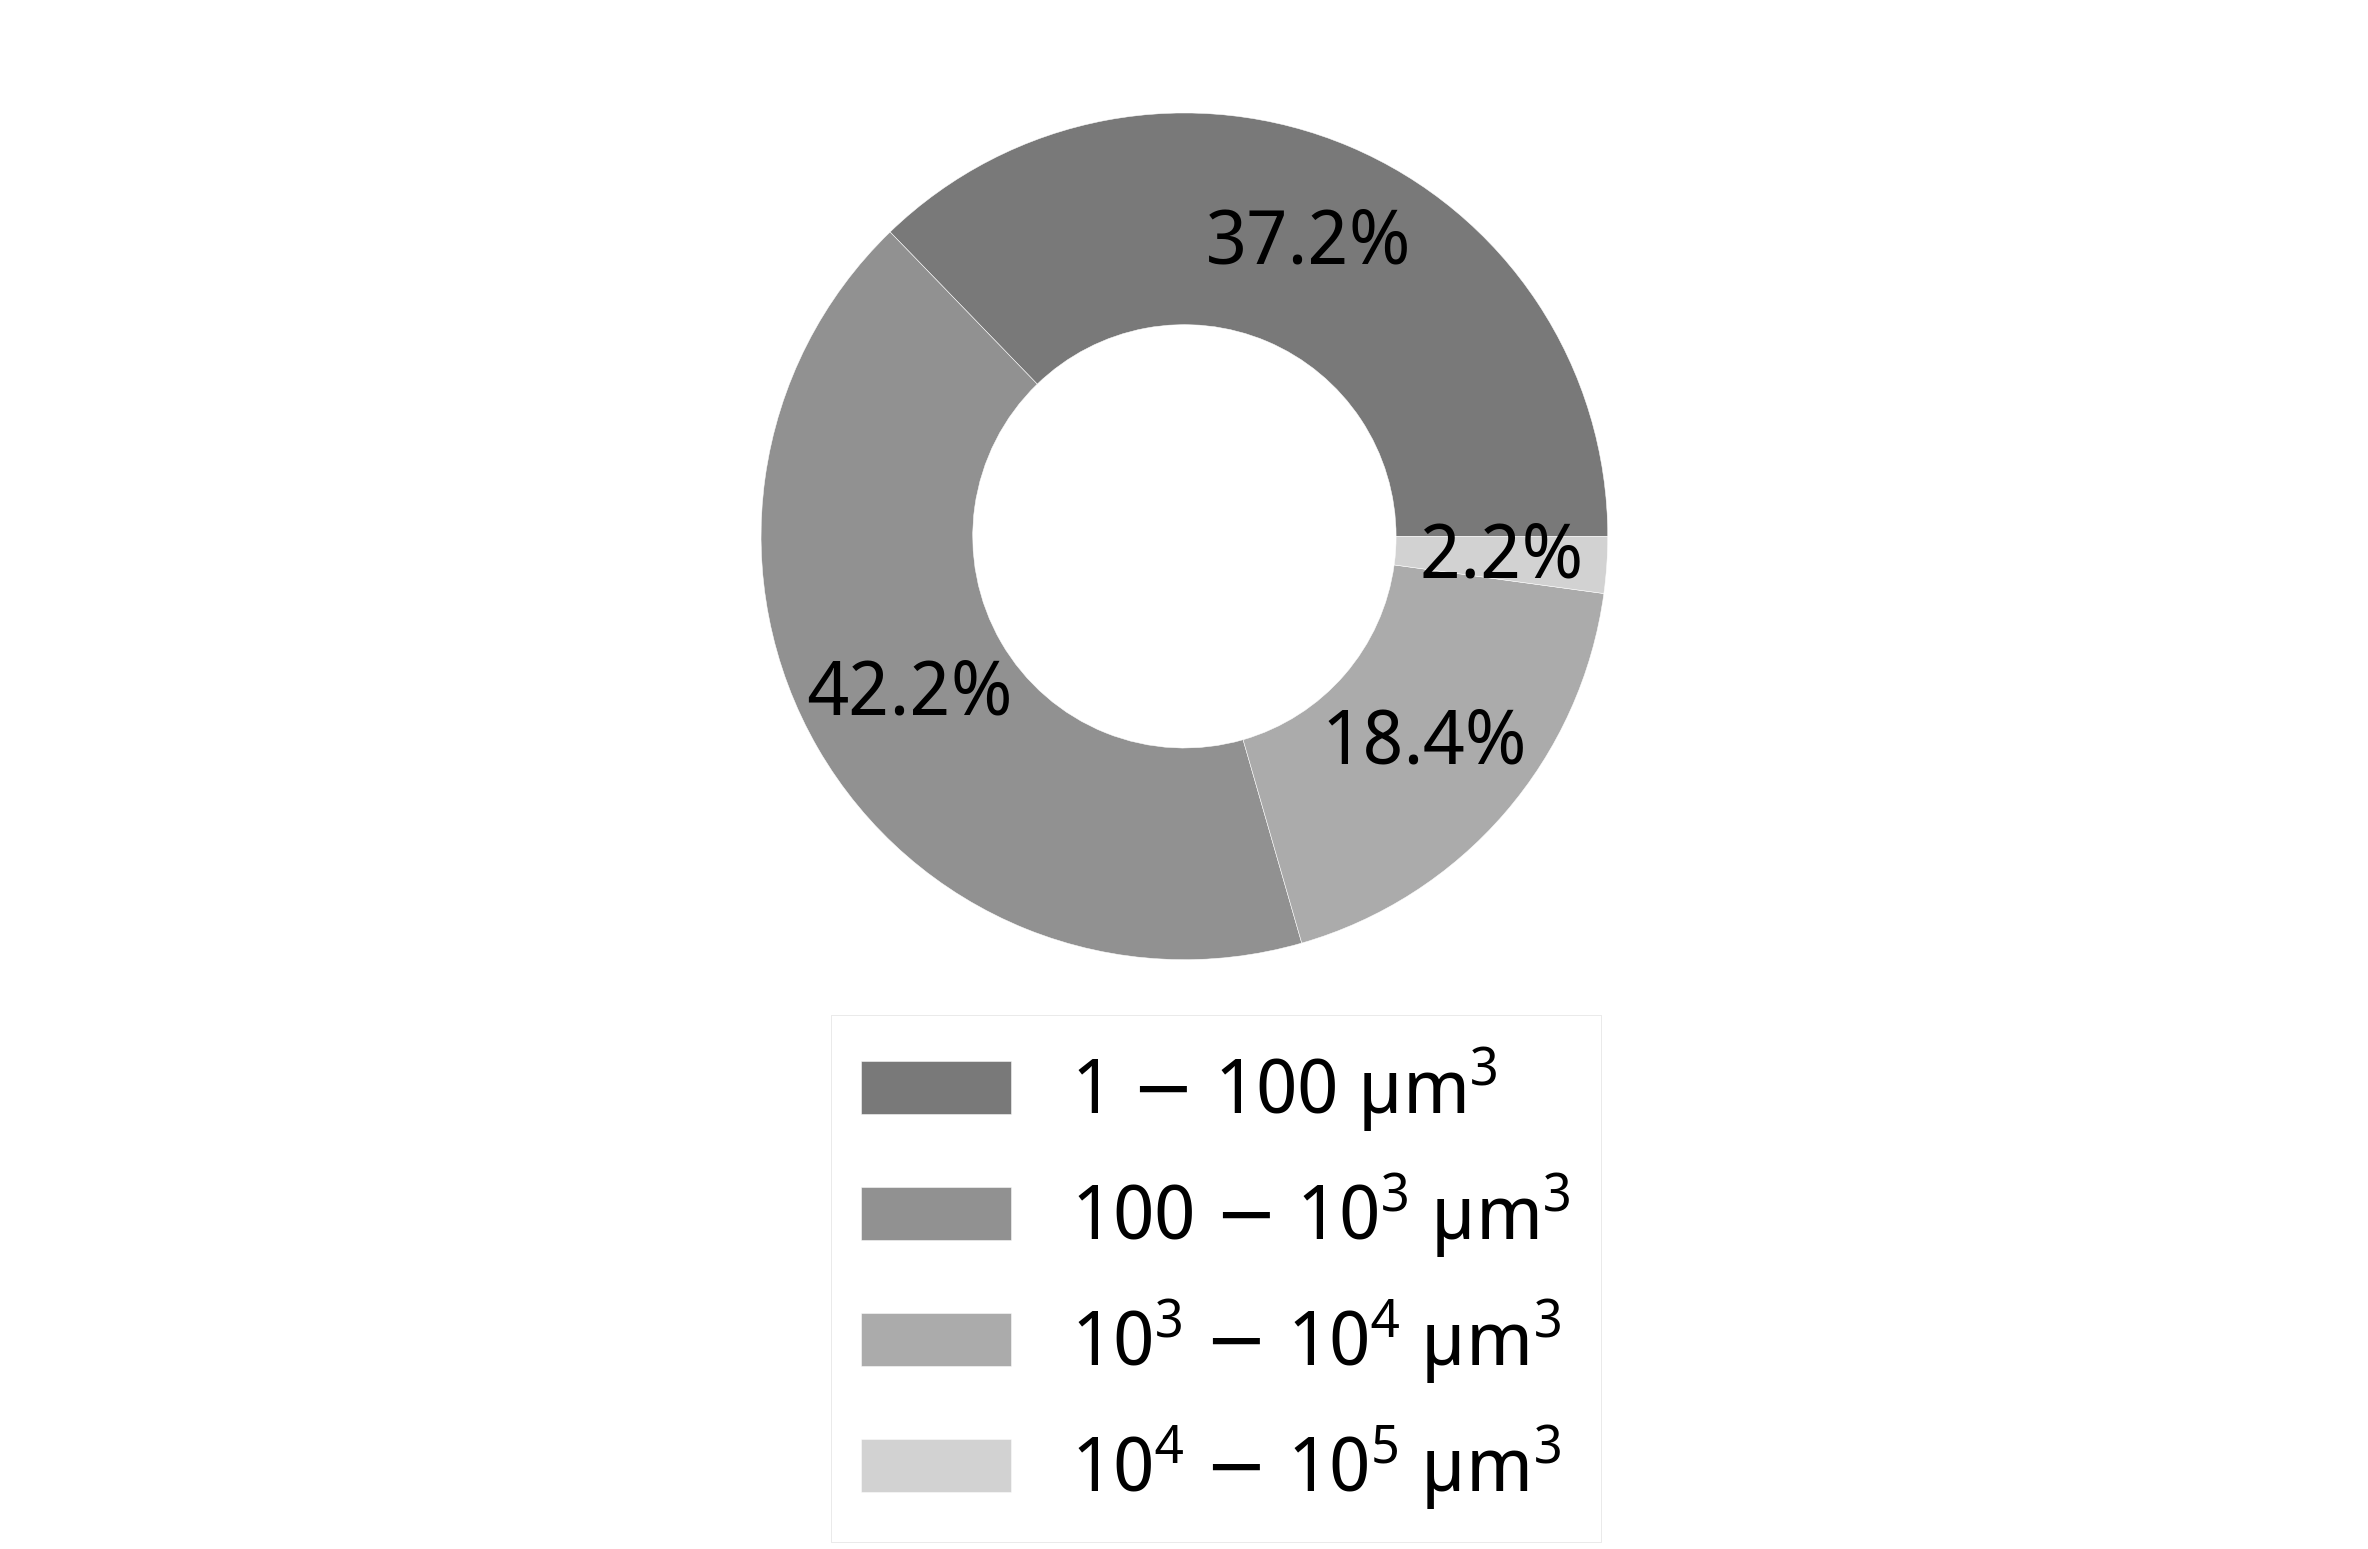

In [86]:
create_pie_chart_v3('PCLSiro', 
                    './data/pcl_results/PCLSiro/particles_stats',
                    './data/pcl_results/results_particles_stats', 
                    [(1, 100), (100,1000), (1000, 10000), (10000,100000)],
                    title='PCLSiro', \
                    type='p',
                    unit_scale=1.8,
                    lang='en',
                    measure_type='vol', 
                    zebra_color=(False,4),
                    legend_fontsize=75,
                    legend_loc=(0.35,-0.45),
                    chart_fontsize=75,
                    dpi=72,
                    color_name='gray',
                    in_voxels=False)

Max: 480574.296, Min: 5.832
1-100: 1904
100-1000: 2099
1000-10000: 1015
10000-100000: 213
100000-1000000: 14


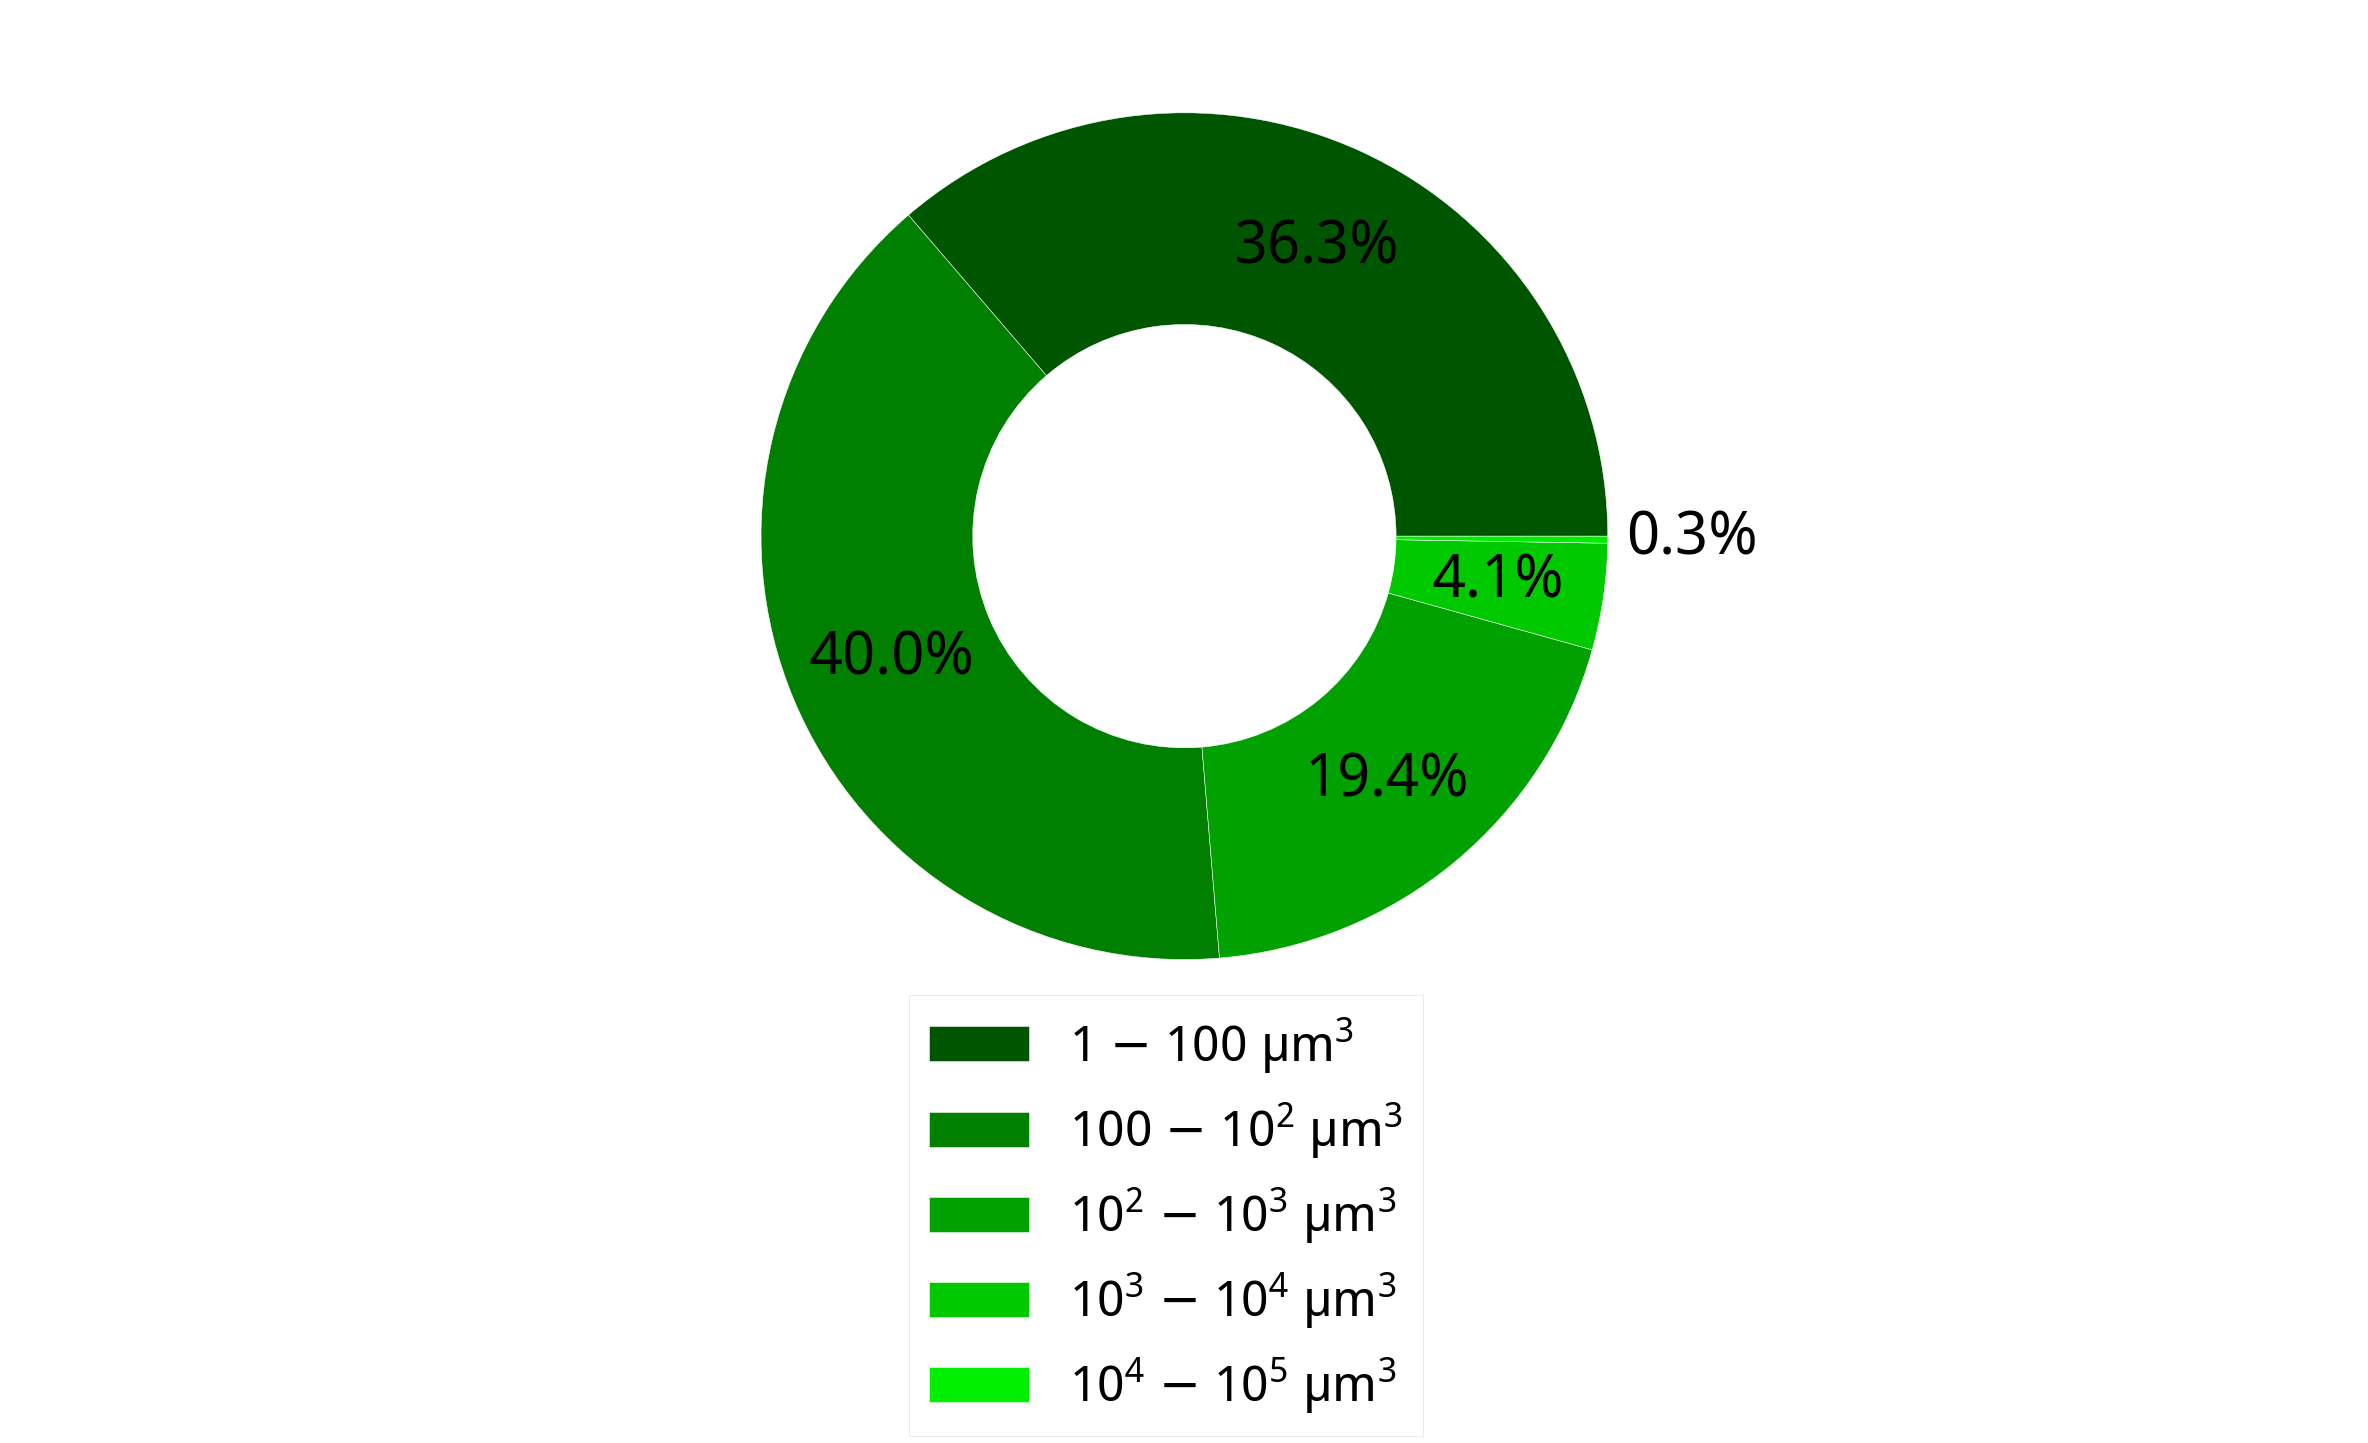

In [308]:
create_pie_chart('PCLHAro', \
                 './data/pcl_results/', \
                 [(1, 100), (100,1000), (1000, 10000), (10000,100000), (100000,1000000)], \
                 data_folder_name='particles_stats', \
                 title='PCLHAro', \
                 type='p', \
                 color_name='green', \
                 lang='en')

Max: 480574.296, Min: 5.832
PCLHAro
(1 - 100) [5.832 - 99.144]
(100 - 1000) [104.976 - 997.272]
(1000 - 10000) [1003.104 - 9856.08]
(10000 - 100000) [10007.712 - 95189.904]
Sample: (PCLHAro, radius) Mean: 10.2417459594  Std: 8.0811609171
Num of particles: 5231
1-100: 1904
100-1000: 2099
1000-10000: 1015
10000-100000: 213


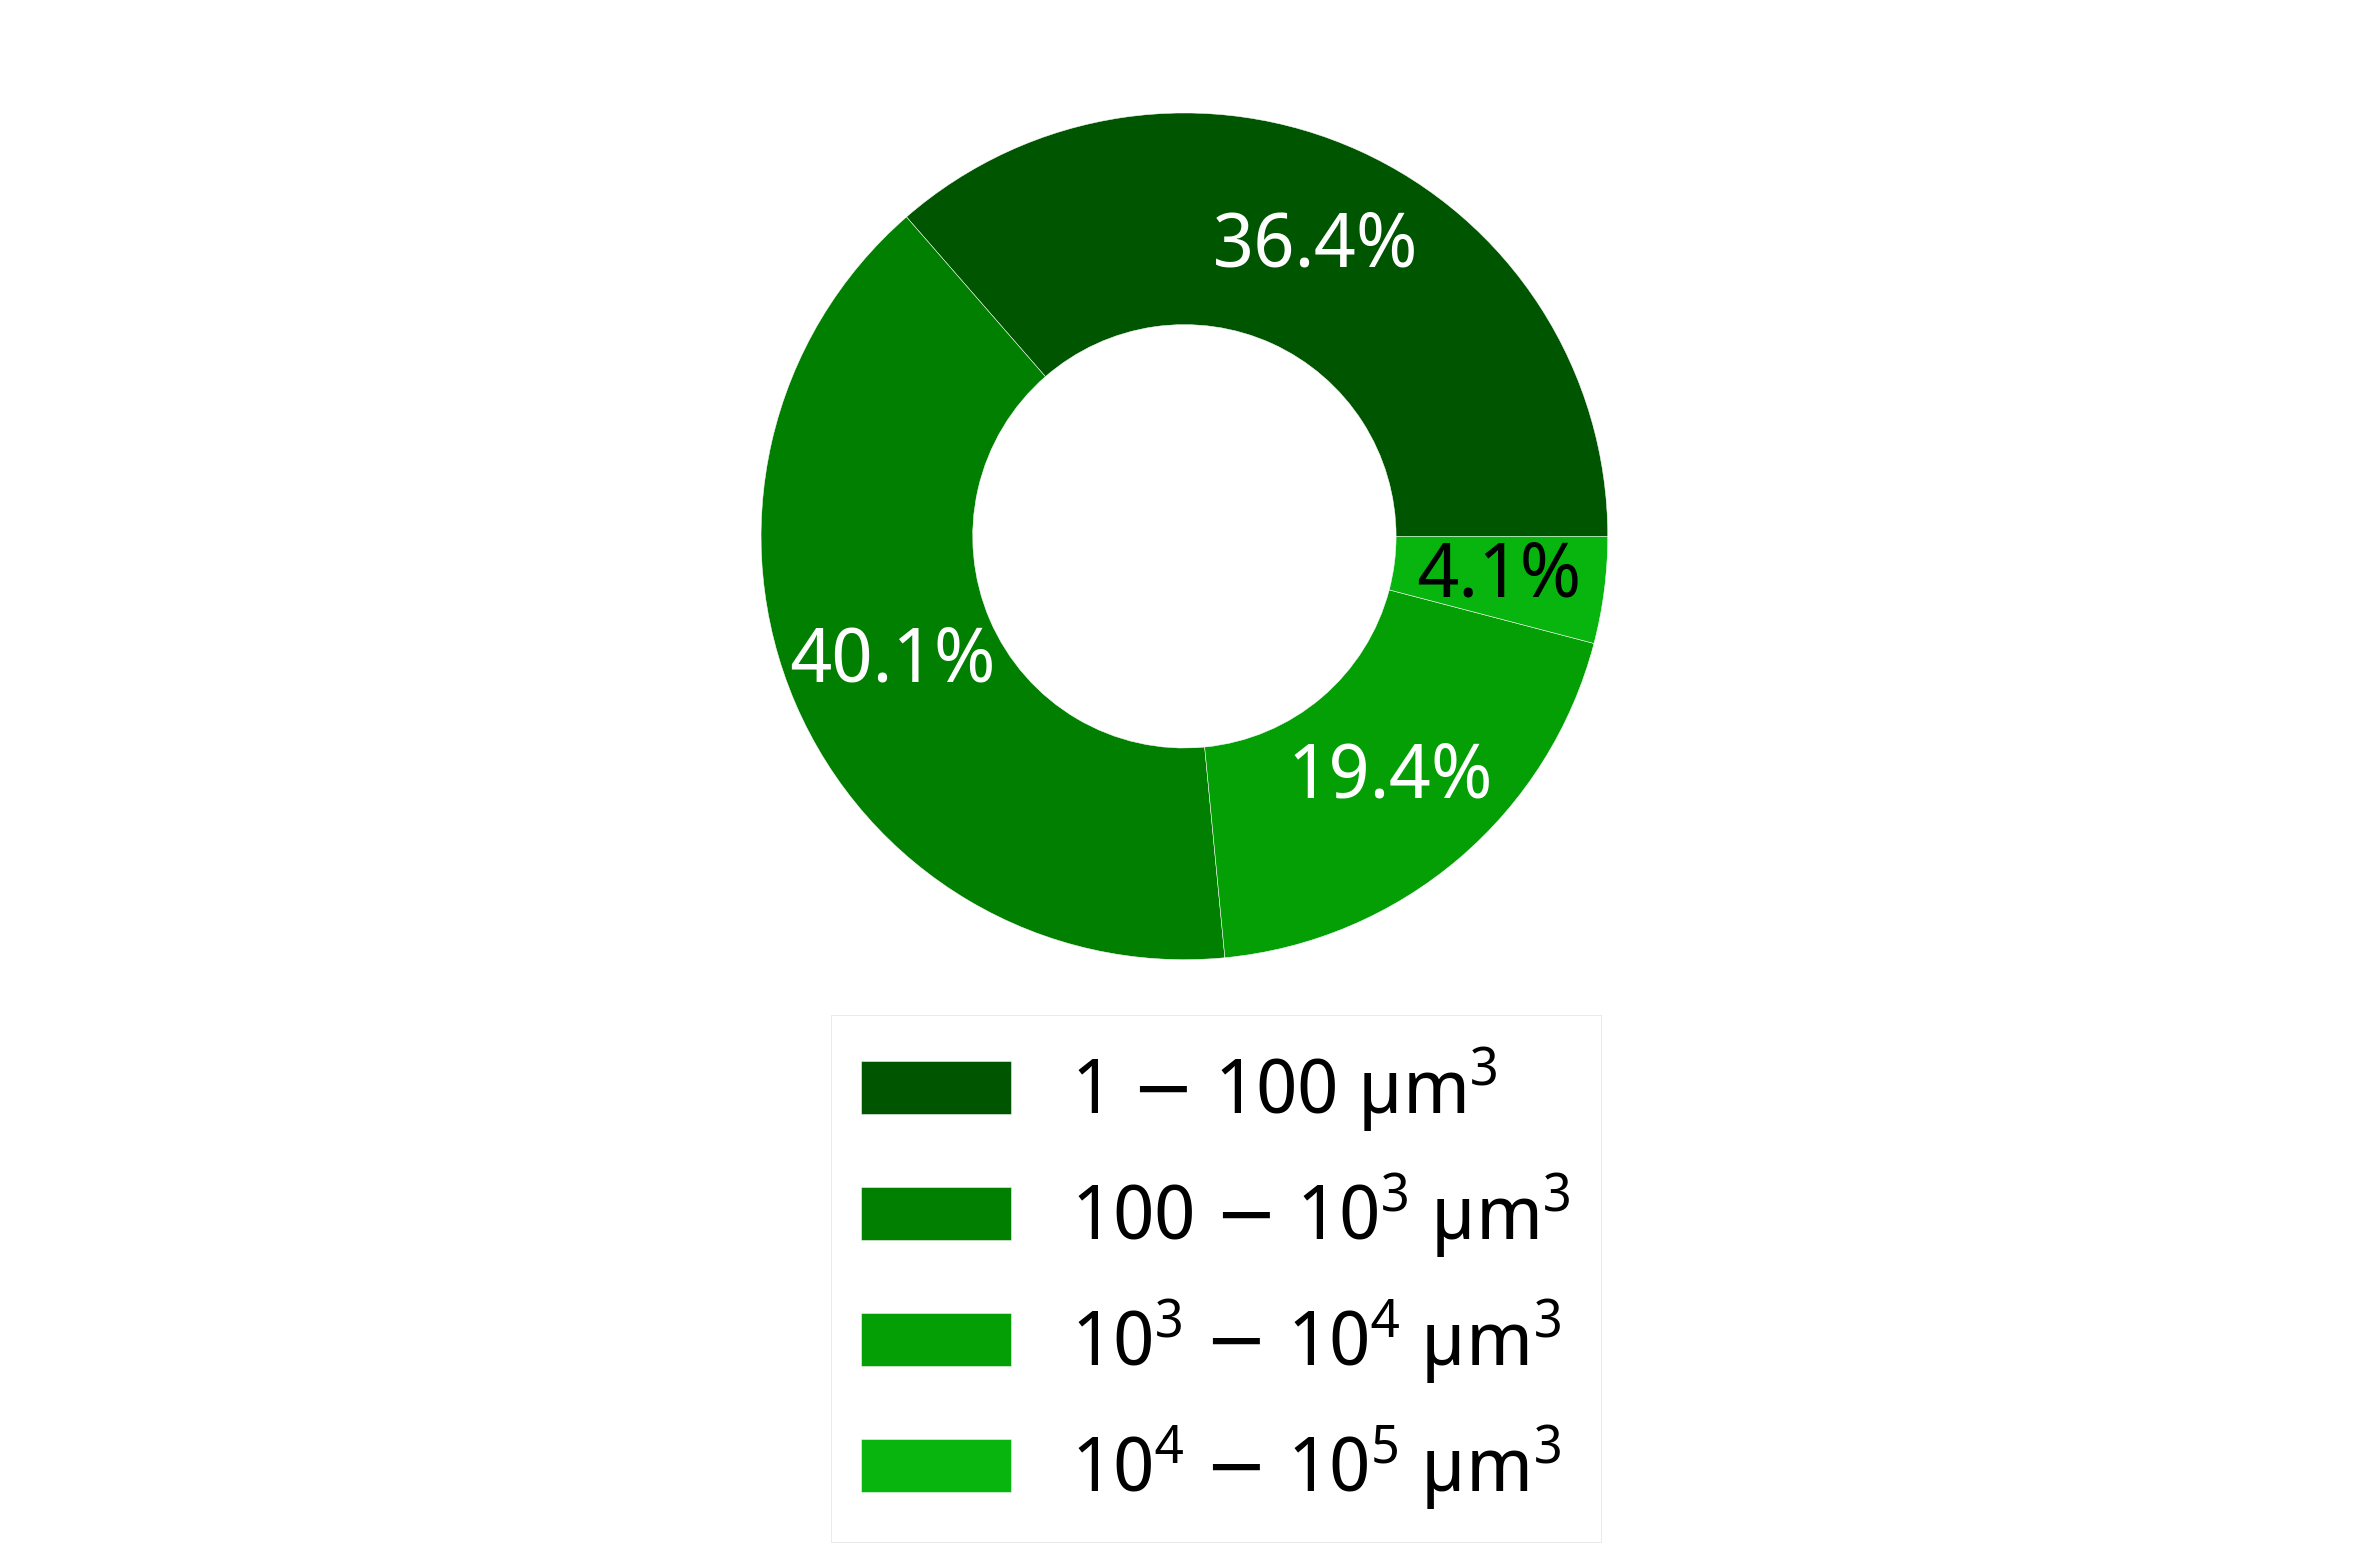

In [87]:
create_pie_chart_v3('PCLHAro', 
                    './data/pcl_results/PCLHAro/particles_stats',
                    './data/pcl_results/results_particles_stats', 
                    [(1, 100), (100,1000), (1000, 10000), (10000,100000)],
                    title='PCLHAro', \
                    type='p',
                    unit_scale=1.8,
                    lang='en',
                    measure_type='vol', 
                    zebra_color=(True,3),
                    legend_fontsize=75,
                    legend_loc=(0.35,-0.45),
                    chart_fontsize=75,
                    dpi=72,
                    color_name='green',
                    in_voxels=False)

# Statistical analysis

In [22]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.libqsturng import psturng
import statsmodels.sandbox.stats.multicomp as multi

In [23]:
def calculate_tukey_posthoc(df, column, type_column='type', verbose=True):
    mc = MultiComparison(df[column], df[type_column])
    result = mc.tukeyhsd()
    st_range = np.abs(result.meandiffs) / result.std_pairs
    
    if verbose:
        print 'Tukey post-hoc ({0})'.format(column)
        print result
        print mc.groupsunique

    out = {}
    groups = mc.groupsunique
    pvals = [multi.tukey_pvalues(ii, len(result.groupsunique), result.df_total)[0] for ii in st_range]
    g1idxs, g2idxs = mc.pairindices
    
    for g1i, g2i, p in zip(g1idxs, g2idxs, pvals):
        gname = '{0}-{1}'.format(groups[g1i], groups[g2i])
        out[gname] = p
        
    import operator
    min_item = min(out.iteritems(), key=operator.itemgetter(1))
    
    if verbose:
        for grp, p in out.items():
            print grp, ': ', p
    
    return out, min_item

In [24]:
def concat_particle_stats(sample_names, \
                          stats_filename='particles.csv', \
                          stats_folder='particles_stats', \
                          input_dir='./data/pcl_results'):
    df_total = pd.DataFrame()
    
    for name in sample_names:
        df = pd.read_csv(os.path.join(input_dir, name, stats_folder, stats_filename))
        df['type'] = name
        df_total = df_total.append(df)
            
    return df_total

In [25]:
def split_in_ranges(df, ranges, column='area', type_column='type', normalize=True):
    out = dict()
    
    for rng in ranges:
        df_filtered = df[(df[column] > rng[0]) & (df[column] <= rng[1])][[column, type_column]]
        
        if normalize:
            df_filtered[column] = df_filtered[column] - df_filtered[column].mean()
            df_filtered[column] = df_filtered[column] / (df_filtered[column].max() - df_filtered[column].min())
        
        out['{}_{}'.format(*rng)] = df_filtered
        
    return out

In [26]:
def analyse_ranges_tukey_posthoc(dranges, column='area', type_column='type', verbose=True):
    for rng_name, df in dranges.iteritems():
        print '================ Analysis of {} ================'.format(rng_name)
        calculate_tukey_posthoc(df, column, type_column=type_column, verbose=verbose)

In [135]:
df = concat_particle_stats(['PCLSrro', 'PCLSiro', 'PCLHAro'])

In [148]:
sp_df = split_in_ranges(df, [(1500,1700)], column='area', normalize=False)

In [149]:
analyse_ranges_tukey_posthoc(sp_df)

================ Analysis of 1500_1700 ================
Tukey post-hoc (area)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower    upper  reject
------------------------------------------------
PCLHAro PCLSiro  0.5431  -35.9394 37.0256 False 
PCLHAro PCLSrro -10.0167 -46.2227 26.1894 False 
PCLSiro PCLSrro -10.5598 -44.9882 23.8687 False 
------------------------------------------------
['PCLHAro' 'PCLSiro' 'PCLSrro']
PCLHAro-PCLSiro :  0.999303409033
PCLSiro-PCLSrro :  0.744995584976
PCLHAro-PCLSrro :  0.786846352185


# Color slices

In [27]:
from skimage import color
from skimage import img_as_float
from skimage import io
from skimage import filters

In [28]:
#https://github.com/zenr/ippy

"""
Implements Kapur-Sahoo-Wong (Maximum Entropy) thresholding method
Usage: $ python max_entropy.py <gray scale image>
"""


def max_entropy(data):
    """
    Implements Kapur-Sahoo-Wong (Maximum Entropy) thresholding method
    Kapur J.N., Sahoo P.K., and Wong A.K.C. (1985) "A New Method for Gray-Level Picture Thresholding Using the Entropy
    of the Histogram", Graphical Models and Image Processing, 29(3): 273-285
    M. Emre Celebi
    06.15.2007
    Ported to ImageJ plugin by G.Landini from E Celebi's fourier_0.8 routines
    2016-04-28: Adapted for Python 2.7 by Robert Metchev from Java source of MaxEntropy() in the Autothresholder plugin
    http://rsb.info.nih.gov/ij/plugins/download/AutoThresholder.java
    :param data: Sequence representing the histogram of the image
    :return threshold: Resulting maximum entropy threshold
    """

    # calculate CDF (cumulative density function)
    cdf = data.astype(np.float).cumsum()

    # find histogram's nonzero area
    valid_idx = np.nonzero(data)[0]
    first_bin = valid_idx[0]
    last_bin = valid_idx[-1]

    # initialize search for maximum
    max_ent, threshold = 0, 0

    for it in range(first_bin, last_bin + 1):
        # Background (dark)
        hist_range = data[:it + 1]
        hist_range = hist_range[hist_range != 0] / cdf[it]  # normalize within selected range & remove all 0 elements
        tot_ent = -np.sum(hist_range * np.log(hist_range))  # background entropy

        # Foreground/Object (bright)
        hist_range = data[it + 1:]
        # normalize within selected range & remove all 0 elements
        hist_range = hist_range[hist_range != 0] / (cdf[last_bin] - cdf[it])
        tot_ent -= np.sum(hist_range * np.log(hist_range))  # accumulate object entropy

        # find max
        if tot_ent > max_ent:
            max_ent, threshold = tot_ent, it

    return threshold

In [29]:
def colorify_slice(filepath='./data/pcl_results/PCLSiro/slices_color/PCLSiHAro_500x500x1_invert_8bit.tif'):
    data = io.imread(filepath)
    
    th_val_particles = max_entropy(np.histogram(data, bins=256, range=(0, 256))[0])
    th_idxs_particles = th_val_particles <= data
    
    th_val_polymer = mh.otsu(data, ignore_zeros=True)
    th_idxs_polymer = th_val_polymer <= data
    th_idxs_polymer[th_idxs_particles] = False
    
    grayscale_image = img_as_float(data)
    image = color.gray2rgb(grayscale_image)
    
    particles_multiplier = [1, 0, 0]
    polymer_multiplier = [0, 1, 0]
    background_multiplier = [0.3, 0.6, 1]
    
    #particles_multiplier = [0.655, 0.22, 0.243]
    #polymer_multiplier = [0.494, 0.624, 0.208]
    #background_multiplier = [0.137, 0.408, 0.388]
    
    #particles_multiplier = [40.24, 45.91, 21.72]
    #polymer_multiplier = [61.21, -27.47, 49.64]
    #background_multiplier = [39.85, -22.55, -3.55]
    
    image[th_idxs_particles] *= particles_multiplier
    image[th_idxs_polymer] *= polymer_multiplier
    image[~(th_idxs_particles | th_idxs_polymer)] *= background_multiplier
    
    plt.figure(figsize=(10,10))
    plt.imshow(image)

In [30]:
def colorify_slice_at(idx, \
                      hist_percentile=(0.01, 99.99),
                      color_particles_multiplier=1.,
                      color_polymer_multiplier=1.5,
                      roi=(slice(500,1000,1), slice(500,1000,1)),
                      slice_grayscale='./data/pcl_results/PCLSiro/cropped/', \
                      slice_particles='./data/pcl_results/PCLSiro/polymer_masks/', \
                      slice_polymer='./data/pcl_results/PCLSiro/porosity_masks2/', 
                      show_partilces=True, \
                      show_polymer=True, \
                      save_filepath=None):
    print 'Slice: {}'.format(idx)
    
    def _to_8bit(data):
        p2 = np.percentile(data, hist_percentile[0])
        p98 = np.percentile(data, hist_percentile[1])
        data = exposure.rescale_intensity(data, in_range=(p2, p98))
        
        return exposure.rescale_intensity(data, in_range='image', out_range=np.uint8).astype(np.uint8)
    
    files_gs = [os.path.join(slice_grayscale, fn) for fn in os.listdir(slice_grayscale) if fn.endswith('.tif')]
    files_ps = [os.path.join(slice_particles, fn) for fn in os.listdir(slice_particles) if fn.endswith('.tif')]
    files_pr = [os.path.join(slice_polymer, fn) for fn in os.listdir(slice_polymer) if fn.endswith('.tif')]
    
    gs, ps, pr = io.imread(files_gs[idx]), io.imread(files_ps[idx]), io.imread(files_pr[idx])
    
    grayscale_image = img_as_float(_to_8bit(gs))
    image = color.gray2rgb(grayscale_image)
    
    particles_multiplier = [0., 220./255., 0.]
    polymer_multiplier = [189./255.,74./255.,255./255.]
    background_multiplier = [0.3, 0.6, 1]
    
    if show_partilces and show_polymer:
        pr[ps != 0] = 0
        
    if show_polymer:
        image[pr != 0] *= [v * 1.1 for v in polymer_multiplier]
        image[pr != 0] *= color_polymer_multiplier

    if show_partilces:
        image[ps != 0] *= particles_multiplier
        image[ps != 0] *= color_particles_multiplier
        
    #print image.shape
    
#     return image[500:1000,500:1000]
   #plt.figure(figsize=(10,10))
    #plt.imshow(image[roi[0],roi[1]])
    #plt.axis('off')
    
    if save_filepath:
        save_data_as_fig(image[roi[0],roi[1]], save_filepath, dpi=None)

In [55]:
def colorify_borders_slice_at(idx, \
                              hist_percentile=(0.01, 99.99),
                              color_particles_multiplier=1.,
                              color_polymer_multiplier=1.5,
                              roi=(slice(500,1000,1), slice(500,1000,1)),
                              slice_grayscale='./data/pcl_results/PCLSiro/cropped/', \
                              slice_particles='./data/pcl_results/PCLSiro/polymer_masks/', \
                              slice_polymer='./data/pcl_results/PCLSiro/porosity_masks2/', 
                              show_partilces=True, \
                              show_polymer=True, \
                              save_filepath=None):
    print 'Slice: {}'.format(idx)
    
    def _to_8bit(data):
        p2 = np.percentile(data, hist_percentile[0])
        p98 = np.percentile(data, hist_percentile[1])
        data = exposure.rescale_intensity(data, in_range=(p2, p98))
        
        return exposure.rescale_intensity(data, in_range='image', out_range=np.uint8).astype(np.uint8)
    
    files_gs = [os.path.join(slice_grayscale, fn) for fn in os.listdir(slice_grayscale) if fn.endswith('.tif')]
    files_ps = [os.path.join(slice_particles, fn) for fn in os.listdir(slice_particles) if fn.endswith('.tif')]
    files_pr = [os.path.join(slice_polymer, fn) for fn in os.listdir(slice_polymer) if fn.endswith('.tif')]
    
    gs, ps, pr = io.imread(files_gs[idx]), io.imread(files_ps[idx]), io.imread(files_pr[idx])
    
    ps = ndi.binary_dilation(ps).astype(np.uint8)
    ps -= ndi.binary_erosion(ps, iterations=3)
    
    pr = ndi.binary_dilation(pr).astype(np.uint8)
    pr -= ndi.binary_erosion(pr, iterations=3)
    
    grayscale_image = img_as_float(_to_8bit(gs))
    image = color.gray2rgb(grayscale_image)
    
    particles_multiplier = [0., 220./255., 0.]
    polymer_multiplier = [189./255.,74./255.,255./255.]
    background_multiplier = [0.3, 0.6, 1]
    
    if show_partilces and show_polymer:
        pr[ps != 0] = 0
        
    if show_polymer:
        image[pr != 0] *= [v * 1.1 for v in polymer_multiplier]
        image[pr != 0] *= color_polymer_multiplier

    if show_partilces:
        image[ps != 0] *= particles_multiplier
        image[ps != 0] *= color_particles_multiplier
        
    #print image.shape
    
#     return image[500:1000,500:1000]
   #plt.figure(figsize=(10,10))
    #plt.imshow(image[roi[0],roi[1]])
    #plt.axis('off')
    
    if save_filepath:
        save_data_as_fig(image[roi[0],roi[1]], save_filepath, dpi=None)

In [56]:
def colorify_stack(slice_grayscale='./data/pcl_results/PCLSiro/cropped/', \
                   slice_particles='./data/pcl_results/PCLSiro/polymer_masks/', \
                   slice_polymer='./data/pcl_results/PCLSiro/porosity_masks/', \
                   show_partilces=True, \
                   show_polymer=True):
    def _to_8bit(data):
        p2 = np.percentile(data, 0.01)
        p98 = np.percentile(data, 99.99)
        data = exposure.rescale_intensity(data, in_range=(p2, p98))
        
        return exposure.rescale_intensity(data, in_range='image', out_range=np.uint8).astype(np.uint8)
    
    files_gs = [os.path.join(slice_grayscale, fn) for fn in os.listdir(slice_grayscale) if fn.endswith('.tif')]
    files_ps = [os.path.join(slice_particles, fn) for fn in os.listdir(slice_particles) if fn.endswith('.tif')]
    files_pr = [os.path.join(slice_polymer, fn)   for fn in os.listdir(slice_polymer)   if fn.endswith('.tif')]
    
#     files_gs = files_gs[150:200]
#     files_pr = files_pr[150:200]
#     files_ps = files_ps[150:200]
    
    out = np.zeros(io.imread(files_gs[0]).shape + (3,len(files_gs)), dtype=np.float32)
    
    for idx in np.arange(len(files_gs)):  
        if idx % 10 == 0 or idx == (len(files_gs) - 1):
            print 'Slice: {}/{}'.format(idx, len(files_gs) - 1)
        
        gs, ps, pr = io.imread(files_gs[idx]), io.imread(files_ps[idx]), io.imread(files_pr[idx])

        grayscale_image = img_as_float(_to_8bit(gs))
        image = color.gray2rgb(grayscale_image)

        particles_multiplier = [0., 220./255., 0.]
        polymer_multiplier = [189./255.,74./255.,255./255.]
        background_multiplier = [0.3, 0.6, 1]

        if show_partilces and show_polymer:
            pr[ps != 0] = 0
        
        if show_polymer:
            image[pr != 0] *= polymer_multiplier
            image[pr != 0] *= 1.5

        if show_partilces:
            image[ps != 0] *= particles_multiplier

        out[:,:,:,idx] = image
        #return image[500:1000,500:1000]
        #plt.figure(figsize=(10,10))
        #plt.imshow(image[500:1000,500:1000])
        #plt.axis('off')
        
    return out

In [32]:
def process_slices(input_dir_fmt='./data/pcl_results/{sample_name}/slices_color', \
                   sample_names=[]):
    for sn in sample_names:
        sp = input_dir_fmt.format(sample_name=sn)
        filepaths = [os.path.join(sp, fn) for fn in os.listdir(sp) if fn.endswith('.tif')]
        
        for fp in filepaths:
            colorify_slice(fp)

In [33]:
def colorify_samples(names=['PCLSiro', 'PCLSrro', 'PCLHAro', 'PCLro']):
    out = dict()
    
    for n in names:
        slice_gs='./data/pcl_results/{}/cropped'.format(n)
        slice_ps='./data/pcl_results/{}/polymer_masks'.format(n)
        slice_pr='./data/pcl_results/{}/porosity_masks'.format(n)
        
        
        if n == 'PCLro':
            out[n] = colorify_stack(slice_grayscale=slice_gs, \
                                    slice_particles=slice_ps, \
                                    slice_polymer=slice_pr, \
                                    show_partilces=False)
        else:    
            out[n] = colorify_stack(slice_grayscale=slice_gs, \
                                    slice_particles=slice_ps, \
                                    slice_polymer=slice_pr)
        
    return out

In [34]:
def save_data_as_fig(data, output_filepath, dpi=32):
    fig = plt.figure(figsize=(15,15))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    #ax = fig.add_subplot(1, 1, 1)
    ax.axis('off')
    ax.imshow(data, aspect='normal')
    #plt.tight_layout()
    #save_fig(fig, output_filepath)
    plt.savefig(output_filepath, dpi=dpi)

In [17]:
data_colored = colorify_samples()

Slice: 0/295
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
Slice: 10/295
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
show_partilces and show_polymer
show_polymer
show_partilces
show_partilce

| Sample   |     Slice    |
|----------|:------------:|
| PCLSiro  |      71      |
| PCLSrro  |      172     |
| PCLHAro  |      110,140,162,266,220      |
|  PCLro   |       42     |

Slice: 62


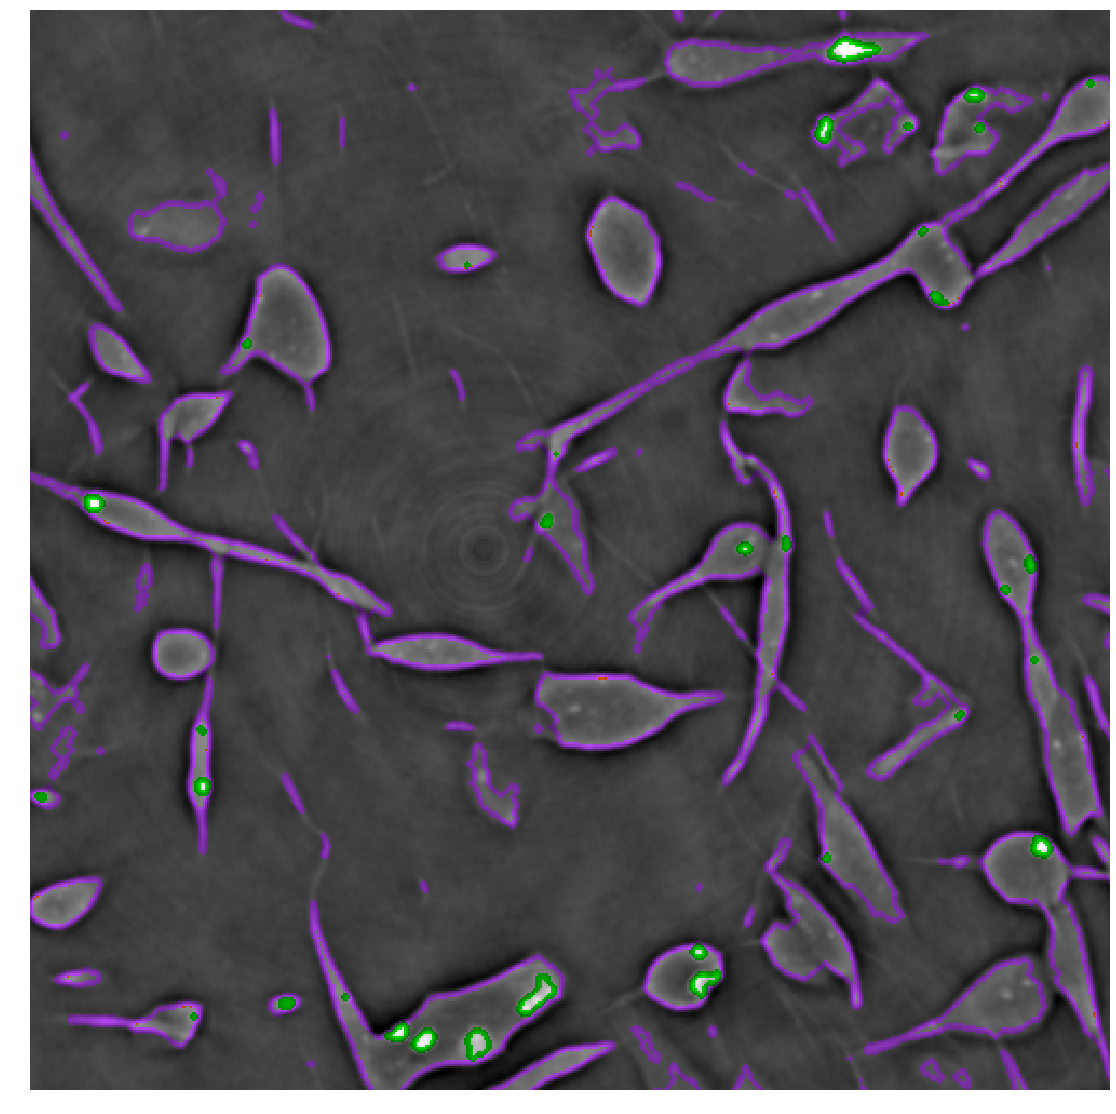

In [71]:
colorify_borders_slice_at(62, \
                  color_polymer_multiplier=1.8,
                  color_particles_multiplier=1.2,
                  roi=(slice(400,900,1), slice(440,940,1), ),
                  slice_grayscale='./data/pcl_results/PCLSiro/cropped/', \
                  slice_particles='./data/pcl_results/PCLSiro/polymer_masks/', \
                  slice_polymer='./data/pcl_results/PCLSiro/porosity_masks2/', \
                  save_filepath='./data/pcl_results/PCLSiro_slice_62_of_295.png')

Slice: 62


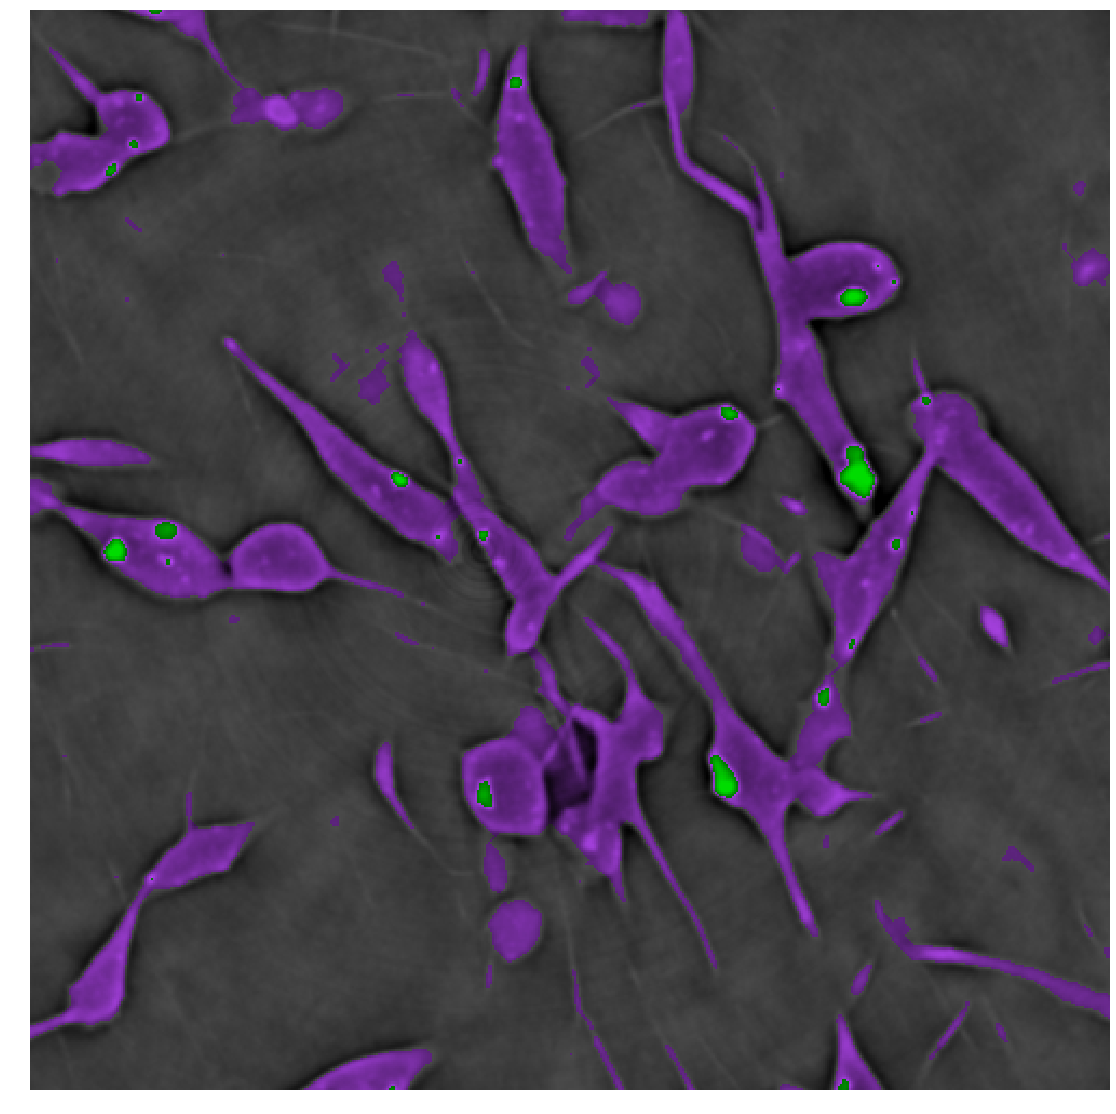

In [175]:
colorify_slice_at(62, \
                  color_polymer_multiplier=1.5,
                  roi=(slice(400,900,1), slice(440,940,1), ),
                  slice_grayscale='./data/pcl_results/PCLSiro/cropped/', \
                  slice_particles='./data/pcl_results/PCLSiro/polymer_masks/', \
                  slice_polymer='./data/pcl_results/PCLSiro/porosity_masks2/', \
                  save_filepath='./data/pcl_results/PCLSiro/PCLSiro_slice_62_of_295.png')

Slice: 179


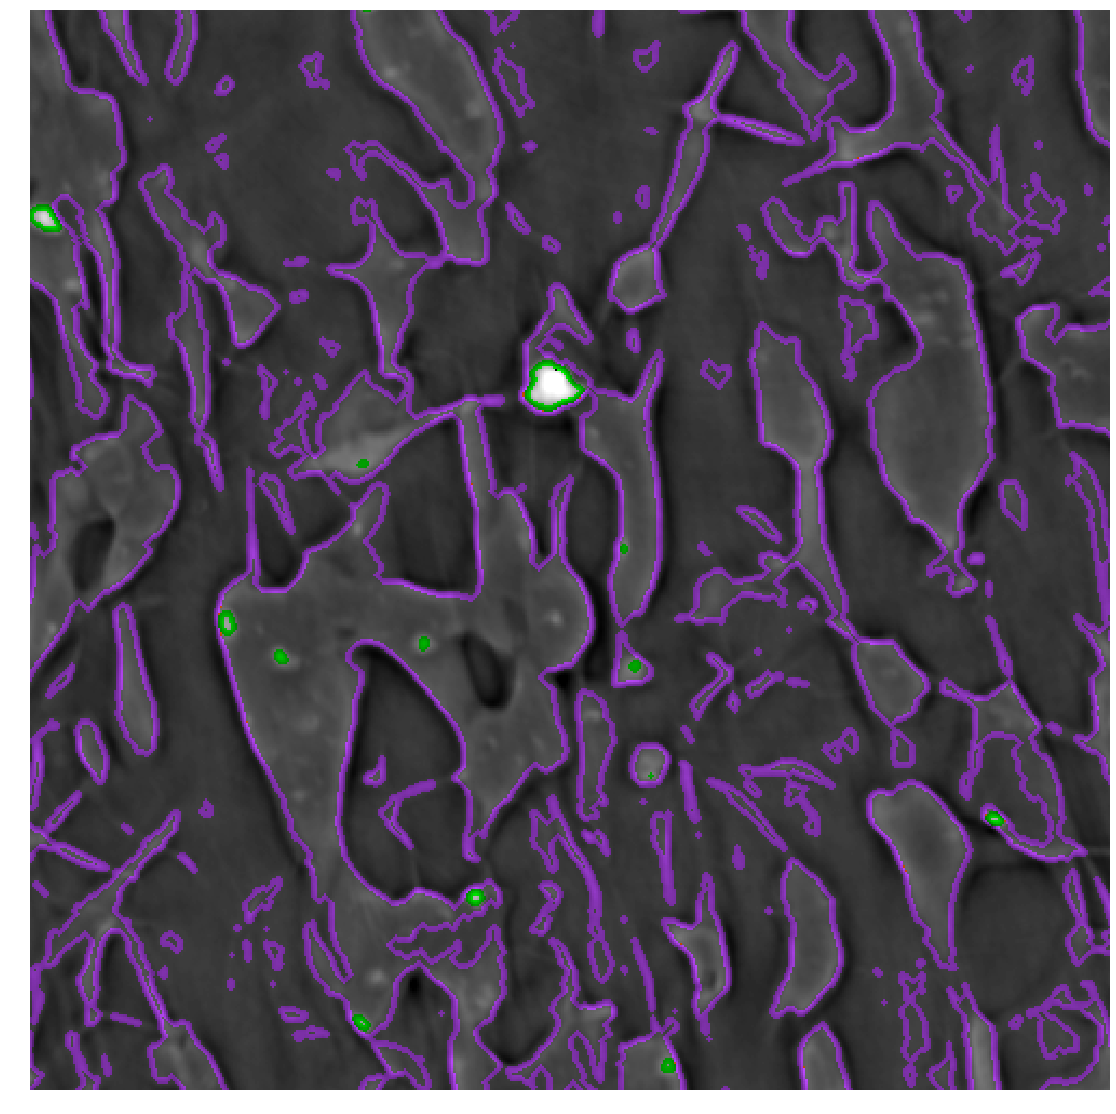

In [77]:
colorify_borders_slice_at(179, \
                  color_polymer_multiplier=2.4,
                  color_particles_multiplier=1.5,
                  roi=(slice(785,785+500,1),slice(330,330+500,1)),
                  slice_grayscale='./data/pcl_results/PCLSrro/cropped/', \
                  slice_particles='./data/pcl_results/PCLSrro/polymer_masks/', \
                  slice_polymer='./data/pcl_results/PCLSrro/porosity_masks/', \
                  save_filepath='./data/pcl_results/PCLSrro_slice_179_of_295.png')

Slice: 179


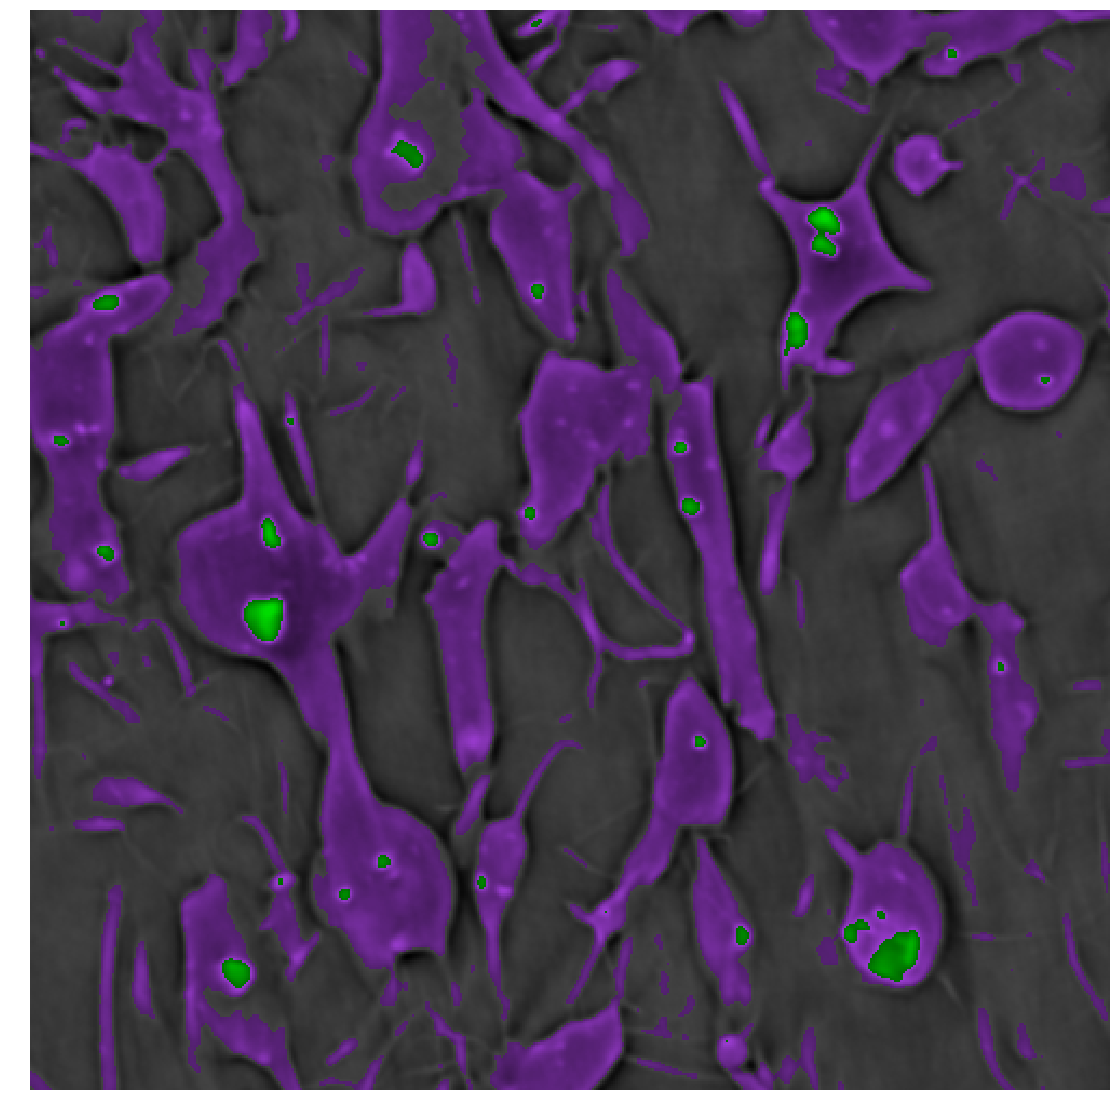

In [176]:
colorify_slice_at(179, \
                  color_polymer_multiplier=1.5,
                  roi=(slice(785,785+500,1),slice(330,330+500,1)),
                  slice_grayscale='./data/pcl_results/PCLSrro/cropped/', \
                  slice_particles='./data/pcl_results/PCLSrro/polymer_masks/', \
                  slice_polymer='./data/pcl_results/PCLSrro/porosity_masks/', \
                  save_filepath='./data/pcl_results/PCLSrro/PCLSrro_slice_179_of_295.png')

Slice: 133


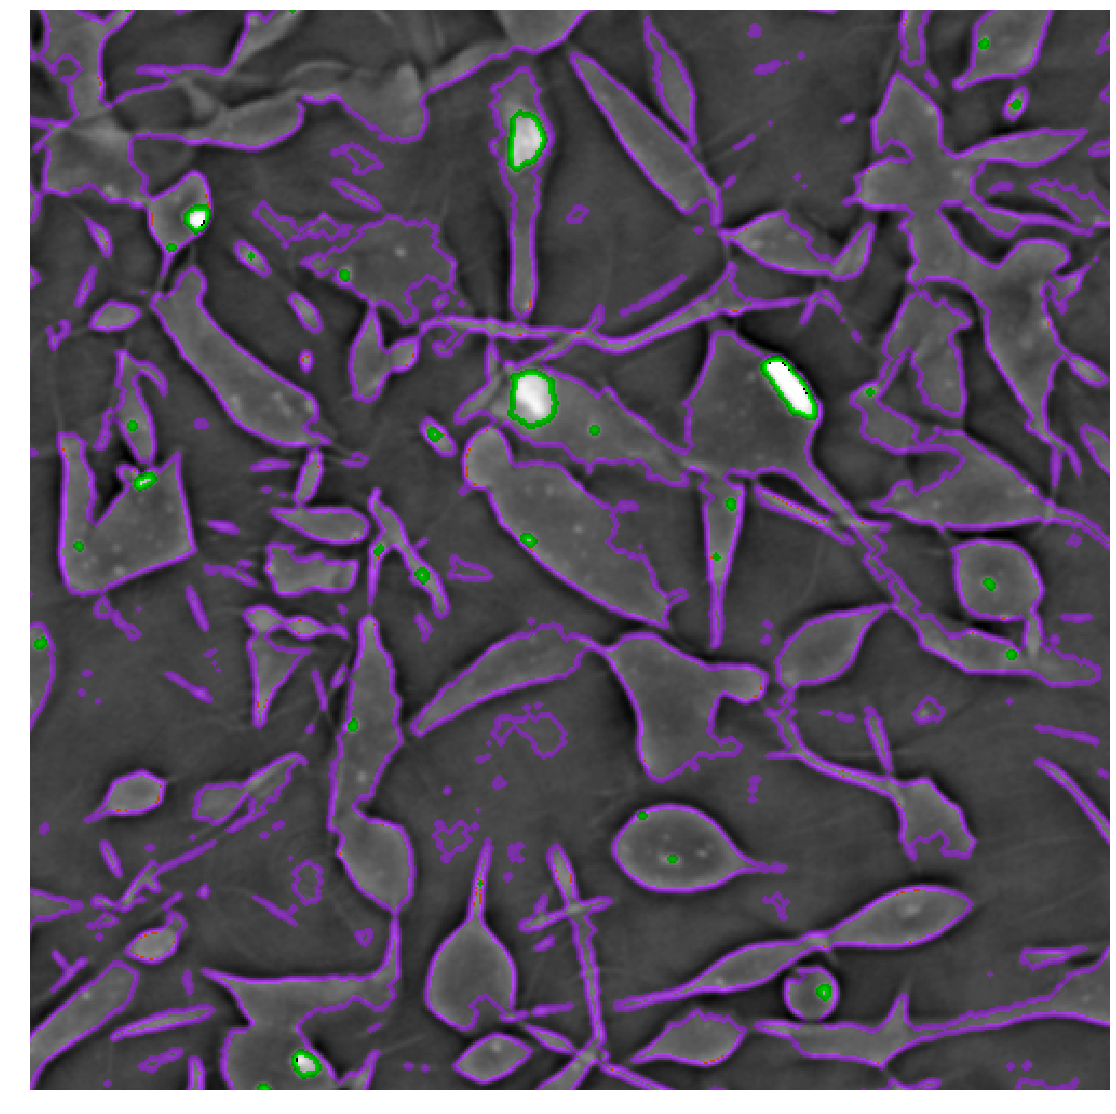

In [89]:
colorify_borders_slice_at(133, \
                  color_polymer_multiplier=2.0,
                  color_particles_multiplier=1.4,
                  roi=(slice(450,450+500,1),slice(715,715+500,1)),
                  slice_grayscale='./data/pcl_results/PCLHAro/cropped/', \
                  slice_particles='./data/pcl_results/PCLHAro/polymer_masks/', \
                  slice_polymer='./data/pcl_results/PCLHAro/porosity_masks/', \
                  save_filepath='./data/pcl_results/PCLHAro_slice_133_of_295.png')

Slice: 133


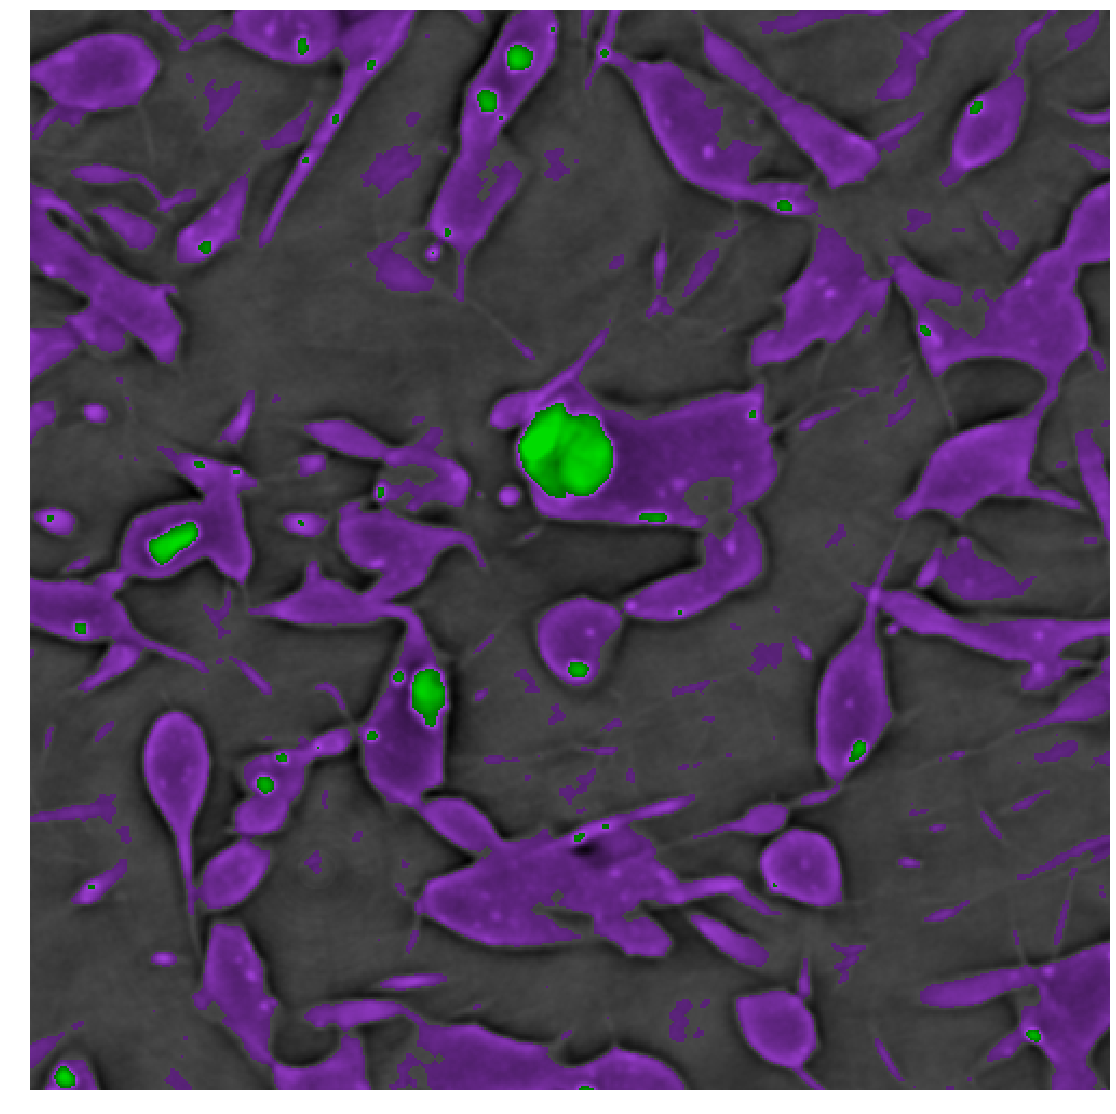

In [177]:
colorify_slice_at(133, \
                  color_polymer_multiplier=1.5,
                  roi=(slice(450,450+500,1),slice(715,715+500,1)),
                  slice_grayscale='./data/pcl_results/PCLHAro/cropped/', \
                  slice_particles='./data/pcl_results/PCLHAro/polymer_masks/', \
                  slice_polymer='./data/pcl_results/PCLHAro/porosity_masks/', \
                  save_filepath='./data/pcl_results/PCLHAro/PCLHAro_slice_133_of_295.png')

Slice: 50


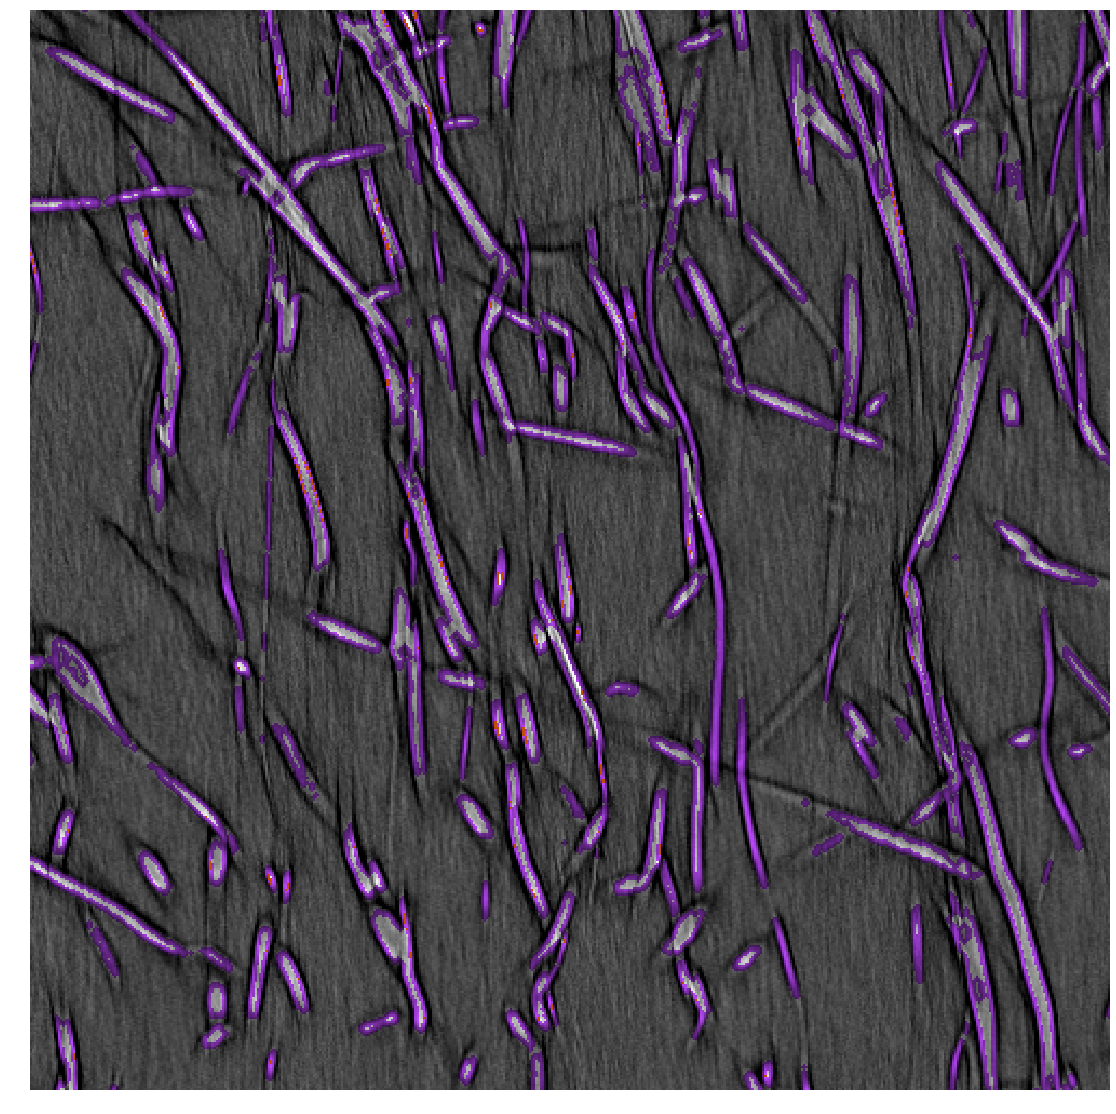

In [91]:
colorify_borders_slice_at(50, \
                  hist_percentile=(3, 99.9),
                  color_polymer_multiplier=0.95,
                  roi=(slice(500,500+500,1),slice(500,500+500,1)),
                  slice_grayscale='./data/pcl_results/PCLro/cropped/', \
                  slice_particles='./data/pcl_results/PCLro/polymer_masks/', \
                  slice_polymer='./data/pcl_results/PCLro/porosity_masks/', \
                  show_partilces=False, \
                  save_filepath='./data/pcl_results/PCLro_slice_50_of_455.png')

Slice: 50


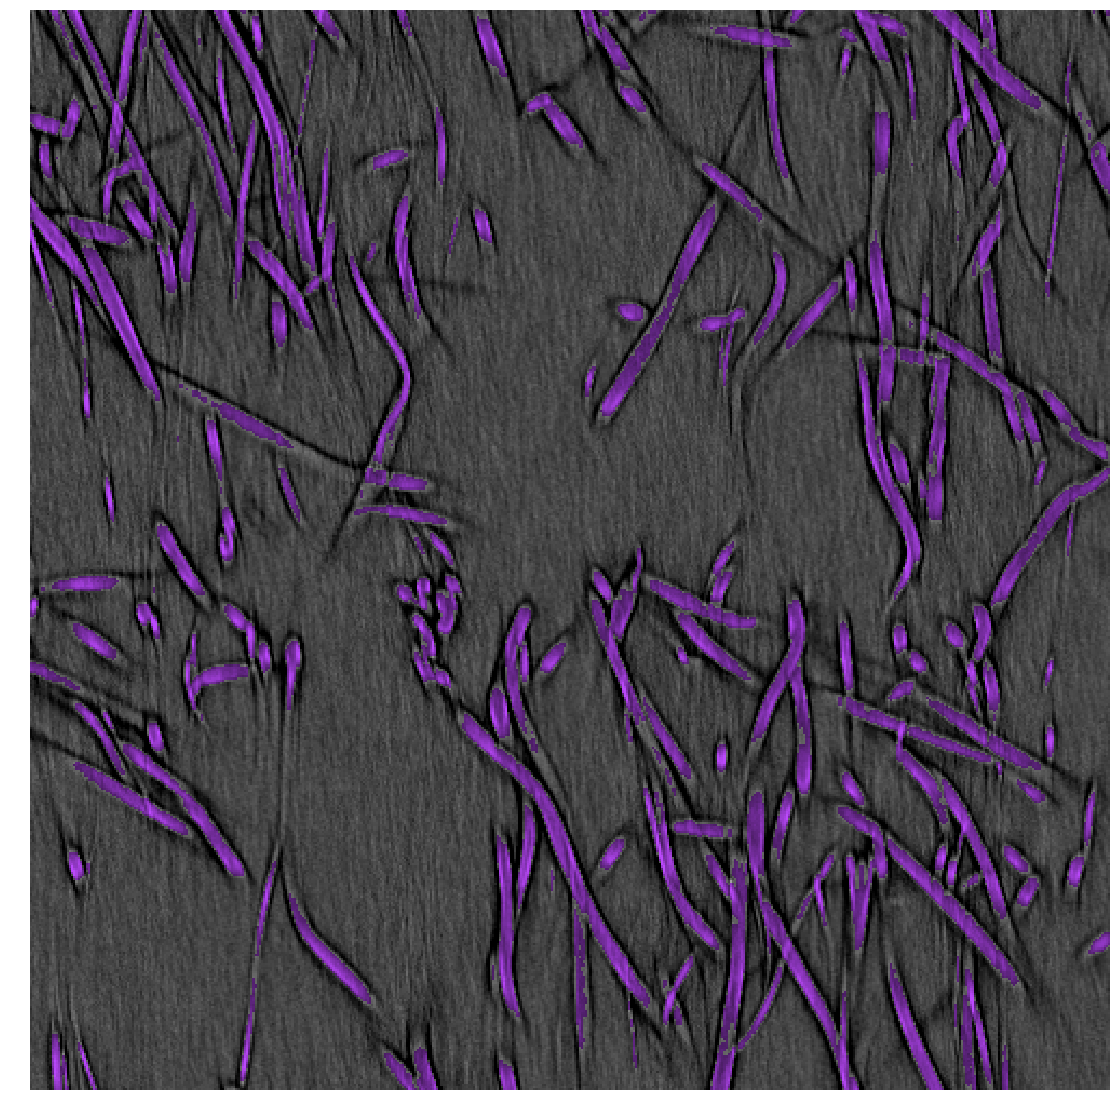

In [253]:
colorify_slice_at(50, \
                  hist_percentile=(3, 99.9),
                  color_polymer_multiplier=0.9,
                  roi=(slice(500,500+500,1),slice(500,500+500,1)),
                  slice_grayscale='./data/pcl_results/PCLro/cropped/', \
                  slice_particles='./data/pcl_results/PCLro/polymer_masks/', \
                  slice_polymer='./data/pcl_results/PCLro/porosity_masks/', \
                  show_partilces=False, \
                  save_filepath='./data/pcl_results/PCLro/PCLro_slice_50_of_455.png')

In [ ]:
show_data_func(data_func, num_slices)

# Particles quantity

In [158]:
def plot_particles_chart(scale=2., lang='en'):
    import matplotlib.ticker as plticker
    
    fontsize = 20
    exp_fontsize = 15
    ylabel = 'Number of particles' if lang == 'en' else u'Количество частиц'
    
    fig, ax = plt.subplots(figsize=(7*scale,5*scale))
    sp_names = ('PCL-HA', 'PCL-SiHA', 'PCL-SrHA')
    sp_values = (5245, 7556, 3750)
    sp_colors = ['#037e01', '#00007f', '#7c0201']
    bar_width=0.45

    textprops={'fontsize': fontsize*scale, 'weight': 'normal', 'family': 'sans-serif', 'color': '#000000'}

    x_pos = np.arange(len(sp_names))

    ax.bar(x_pos, sp_values, bar_width, align='center', color=sp_colors, edgecolor='#000000', linewidth=1.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sp_names, **textprops)
    ax.set_ylabel(ylabel, fontsize=fontsize*scale, color='#000000')
    ax.set_yticks(np.arange(0,9000,1000))
    ax.set_ylim([0, 8000])
    
    ax.tick_params(axis='x', labelsize=fontsize*scale, colors='#000000', which='both', direction='out', length=15, width=2)
    
    ax.tick_params(axis='y', labelsize=fontsize*scale, colors='#000000', which='major', direction='out', length=15, width=2)
    ax.tick_params(axis='y', labelsize=fontsize*scale, colors='#000000', which='minor', direction='out', length=8, width=2)
    
    ax.yaxis.label.set_color('#000000')
    ax.xaxis.label.set_color('#000000')
    
    ml = plticker.MultipleLocator(500)
    ax.yaxis.set_minor_locator(ml)
    
    for k in ax.spines.keys():
        ax.spines[k].set_color('#000000')
        ax.spines[k].set_linewidth(2)
    
    ax.yaxis.offsetText.set_fontsize(exp_fontsize*scale)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    plt.show()
    
    save_fig(fig, './data/pcl_results/particles_chart_{}.png'.format(lang))

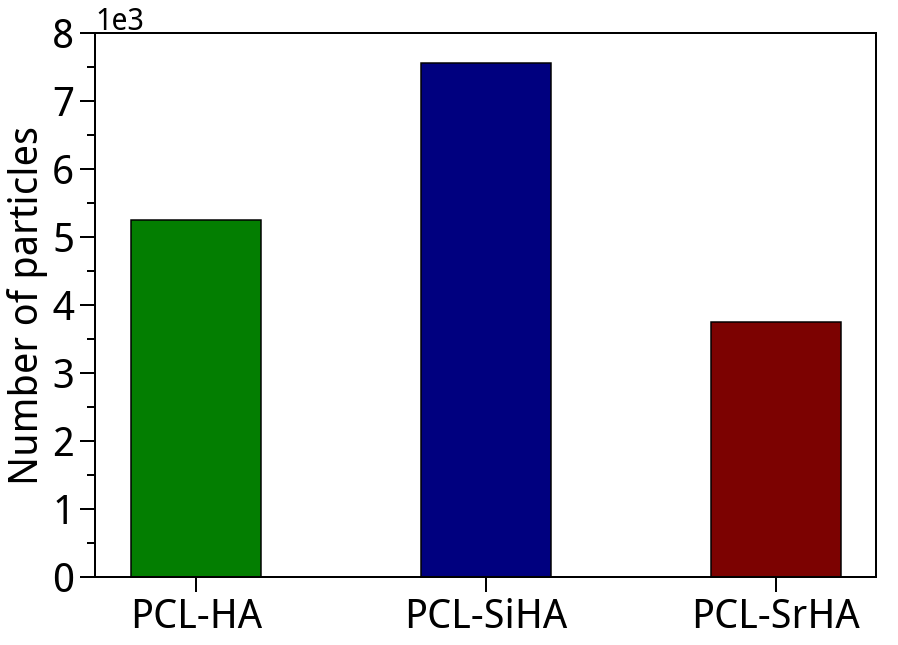

In [160]:
plot_particles_chart(lang='en')

# Porosity quantity

In [166]:
def plot_porosity_chart(scale=2., lang='en'):
    import matplotlib.ticker as plticker
    
    fontsize = 20
    ylabel = 'Porosity (%)' if lang == 'en' else u'Пористость (%)'

    fig, ax = plt.subplots(figsize=(7*scale, 5*scale))
    sp_names = ('PCL-HA', 'PCL-SiHA', 'PCL-SrHA', 'PCL')
    sp_values = (72, 84, 69, 86)
    sp_std = (2, 5, 7, 8)
    sp_colors = ['#037e01', '#00007f', '#7c0201', '#000000']
    bar_width=0.45

    textprops={'fontsize': fontsize*scale, 'weight': 'normal', 'family': 'sans-serif'}

    x_pos = np.arange(len(sp_names))

    #ax.set_position([0,0,1,1])
    ax.bar(x_pos, sp_values, bar_width, align='center', color=sp_colors, yerr=sp_std, 
           edgecolor='#000000', linewidth=1.5,
           error_kw=dict(elinewidth=2, capsize=5, xlolims=True, capthick=2, ecolor='gray'))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sp_names, **textprops)
    ax.set_ylabel(ylabel, fontsize=fontsize*scale)
    ax.set_yticks(np.arange(0,110,10))
    ax.set_ylim([0, 100])
    
    ax.tick_params(axis='x', labelsize=fontsize*scale, colors='#000000', which='both', direction='out', length=15, width=2)
    
    ax.tick_params(axis='y', labelsize=fontsize*scale, colors='#000000', which='major', direction='out', length=15, width=2)
    ax.tick_params(axis='y', labelsize=fontsize*scale, colors='#000000', which='minor', direction='out', length=8, width=2)
    
    ax.yaxis.label.set_color('#000000')
    ax.xaxis.label.set_color('#000000')
    
    ml = plticker.MultipleLocator(5)
    ax.yaxis.set_minor_locator(ml)
    
    for k in ax.spines.keys():
        ax.spines[k].set_color('#000000')
        ax.spines[k].set_linewidth(2)
    
    plt.show()
    
    save_fig(fig, './data/pcl_results/porosity_chart_{}.png'.format(lang))

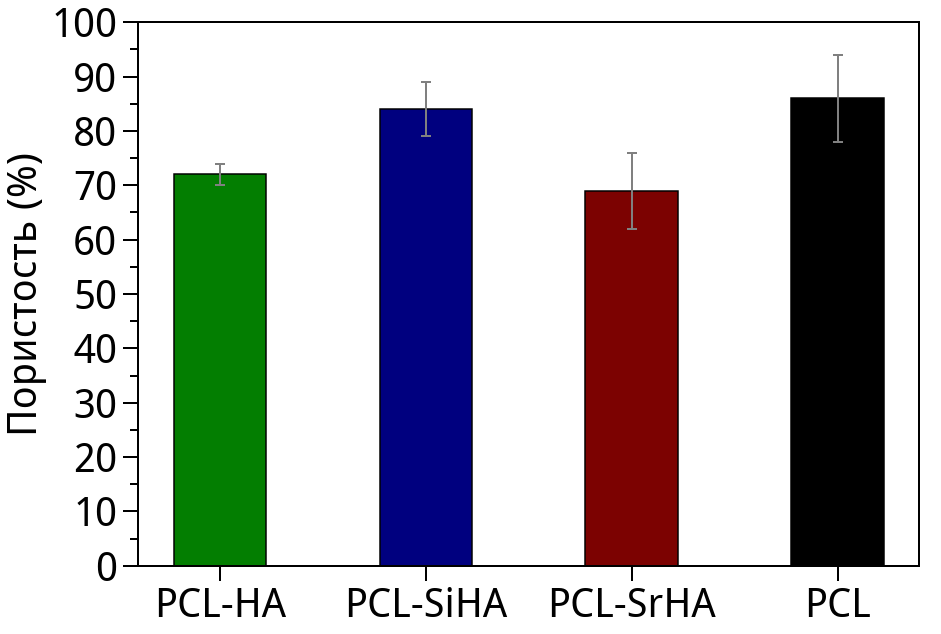

In [167]:
plot_porosity_chart(lang='ru')

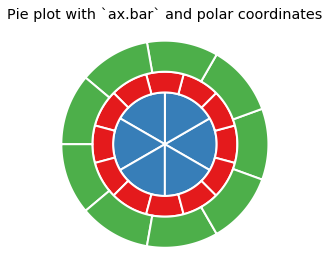

In [245]:
fig, ax = plt.subplots(subplot_kw=dict(polar=True))

left_inner = np.arange(0.0, 2 * np.pi, 2 * np.pi / 6)
left_middle = np.arange(0.0, 2 * np.pi, 2 * np.pi / 12)
left_outer = np.arange(0.0, 2 * np.pi, 2 * np.pi / 9)

ax.bar(left=left_inner,
       width=2 * np.pi / 6, bottom=0, color='C0',
       linewidth=2, edgecolor='w',
       height=np.zeros_like(left_inner) + 5)

ax.bar(left=left_middle,
       width=2 * np.pi / 12, bottom=5, color='C1',
       linewidth=2, edgecolor='w',
       height=np.zeros_like(left_middle) + 2)

ax.bar(left=left_outer,
       width=2 * np.pi / 9, bottom=7, color='C2',
       linewidth=2, edgecolor='w',
       height=np.zeros_like(left_outer) + 3)

ax.set(title="Pie plot with `ax.bar` and polar coordinates")
ax.set_axis_off()
plt.show()

# Orientation

# Diameter

Max: 25.1999988556, Min: 0.0
1-5: 100290
5-10: 192910
10-15: 232647
15-20: 1293
20-25: 36


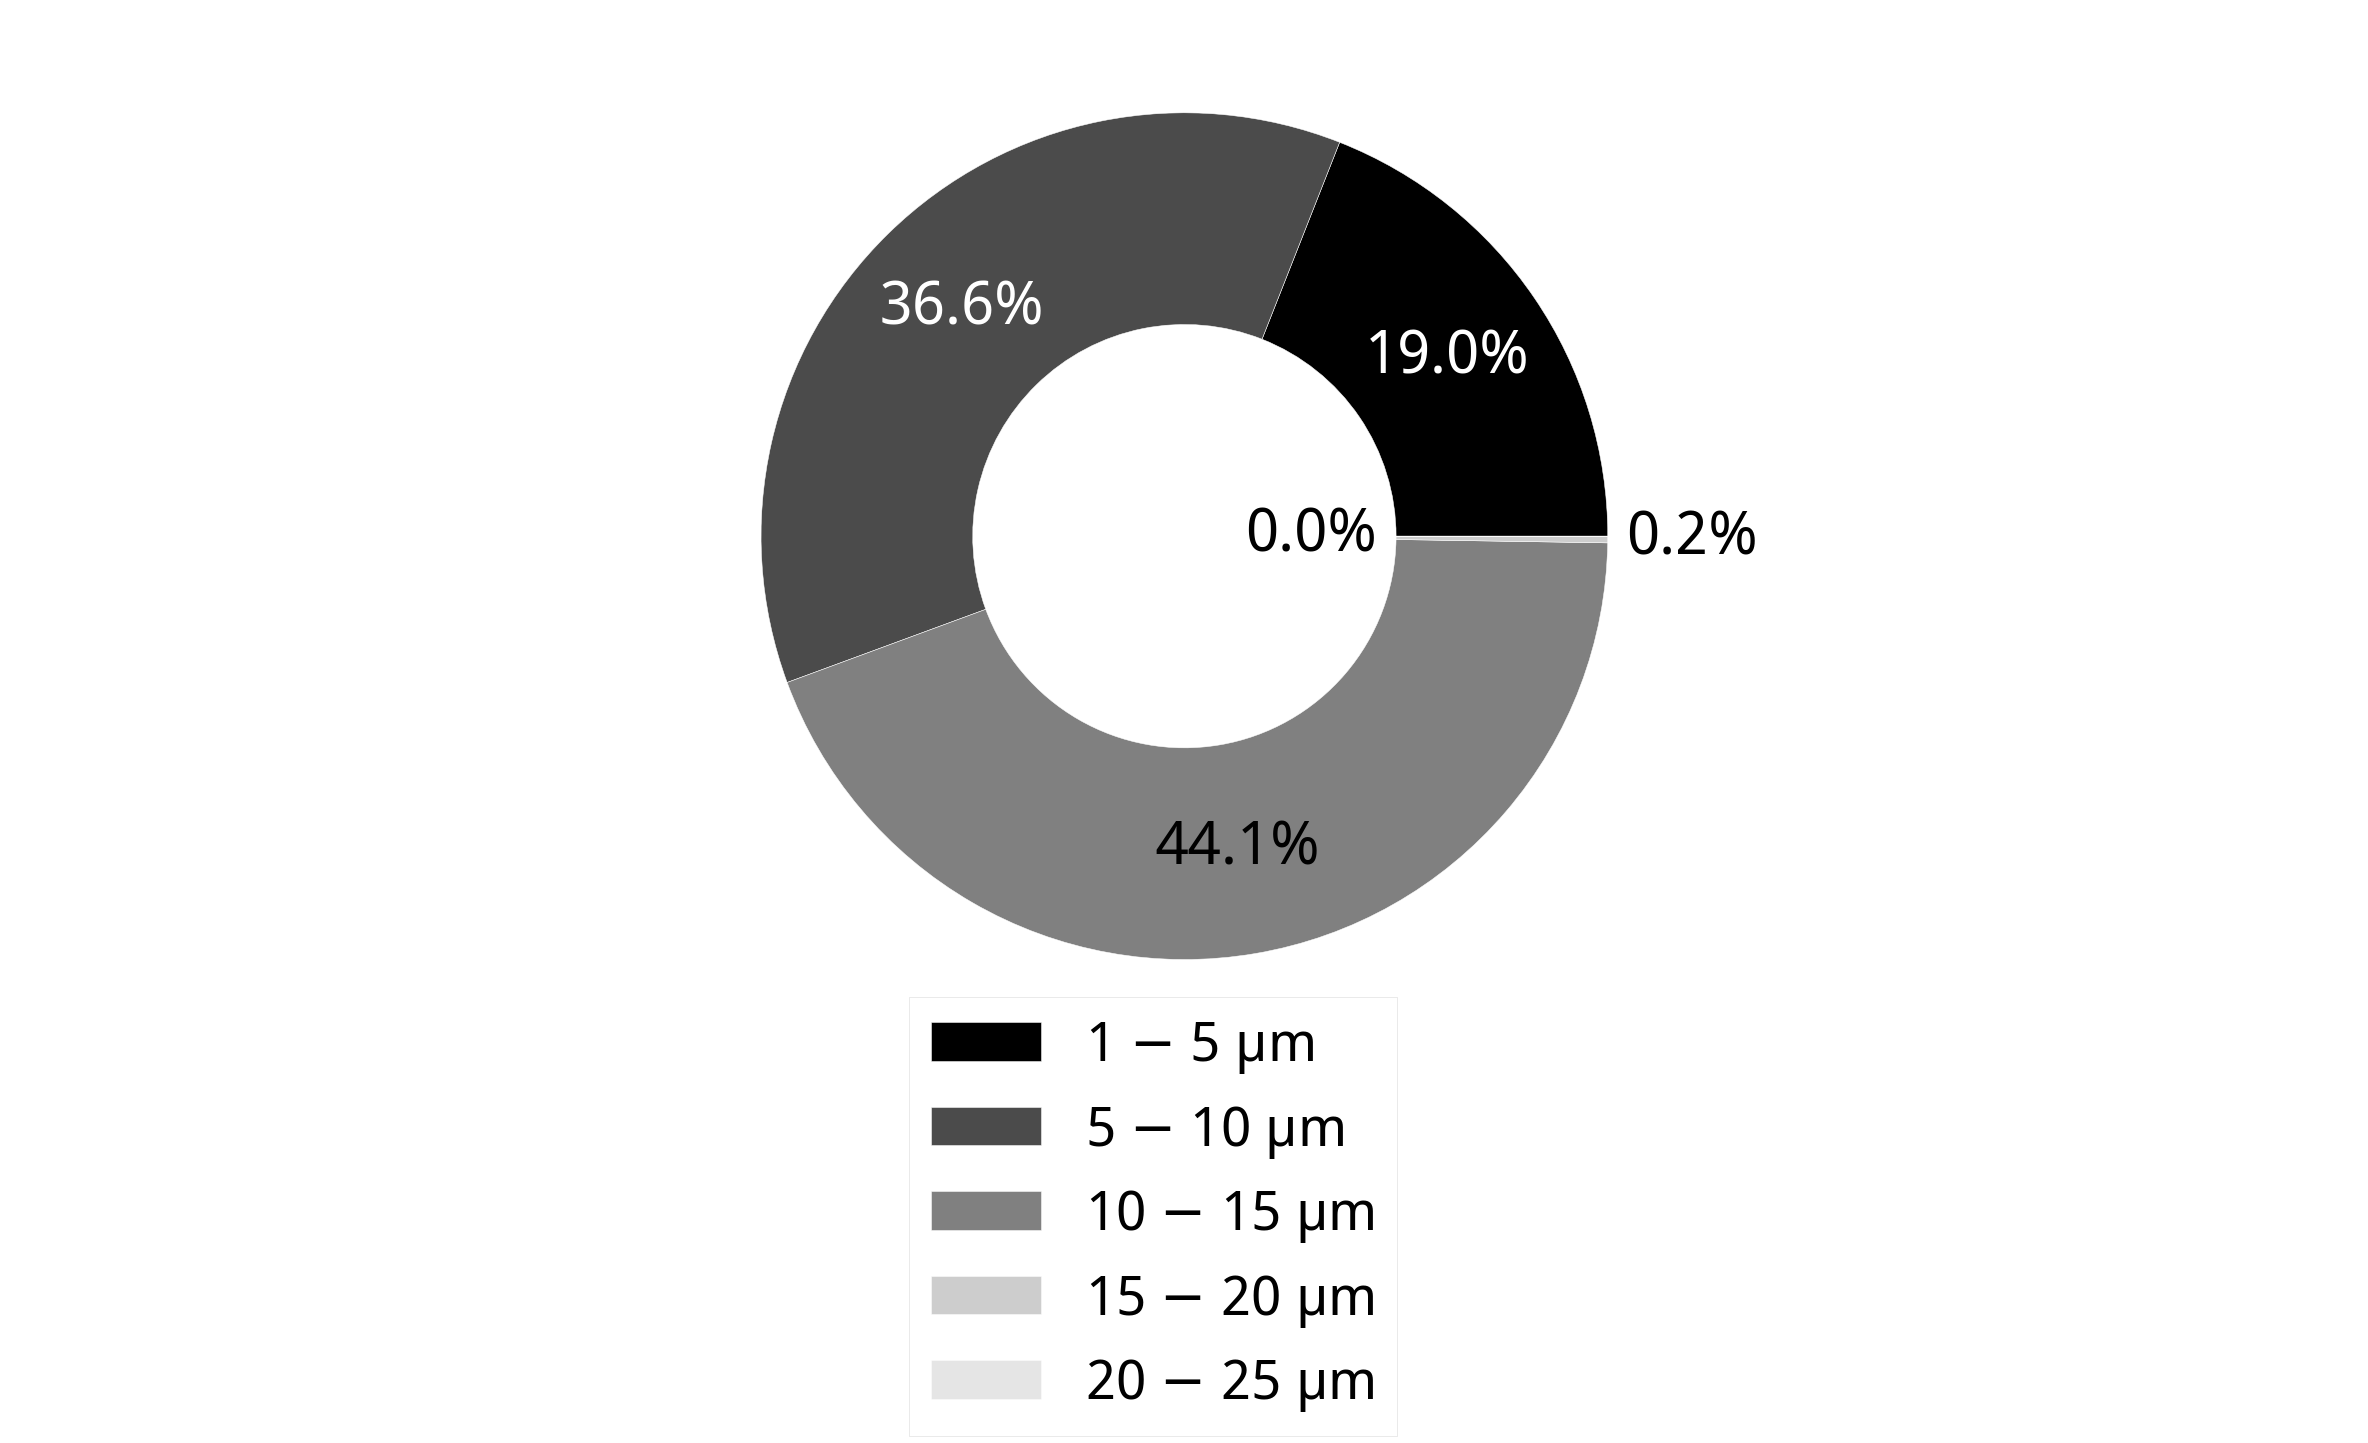

In [314]:
create_pie_chart('PCLro', 
                 './data/pcl_results/Diameter_evaluation/', 
                 [(1,5), (5,10), (10, 15), (15,20), (20,25)], 
                 data_folder_name=None, 
                 title='diameter',
                 type='d', 
                 unit_scale=1.8,
                 color_name='black',
                 measure_type='Non_vol',
                 zebra_color=True,
                 legend_fonsize=55)

Max: 439.199981689, Min: 0.0
1-10: 73891
10-20: 68426
20-50: 55636
50-100: 3306
100-500: 285


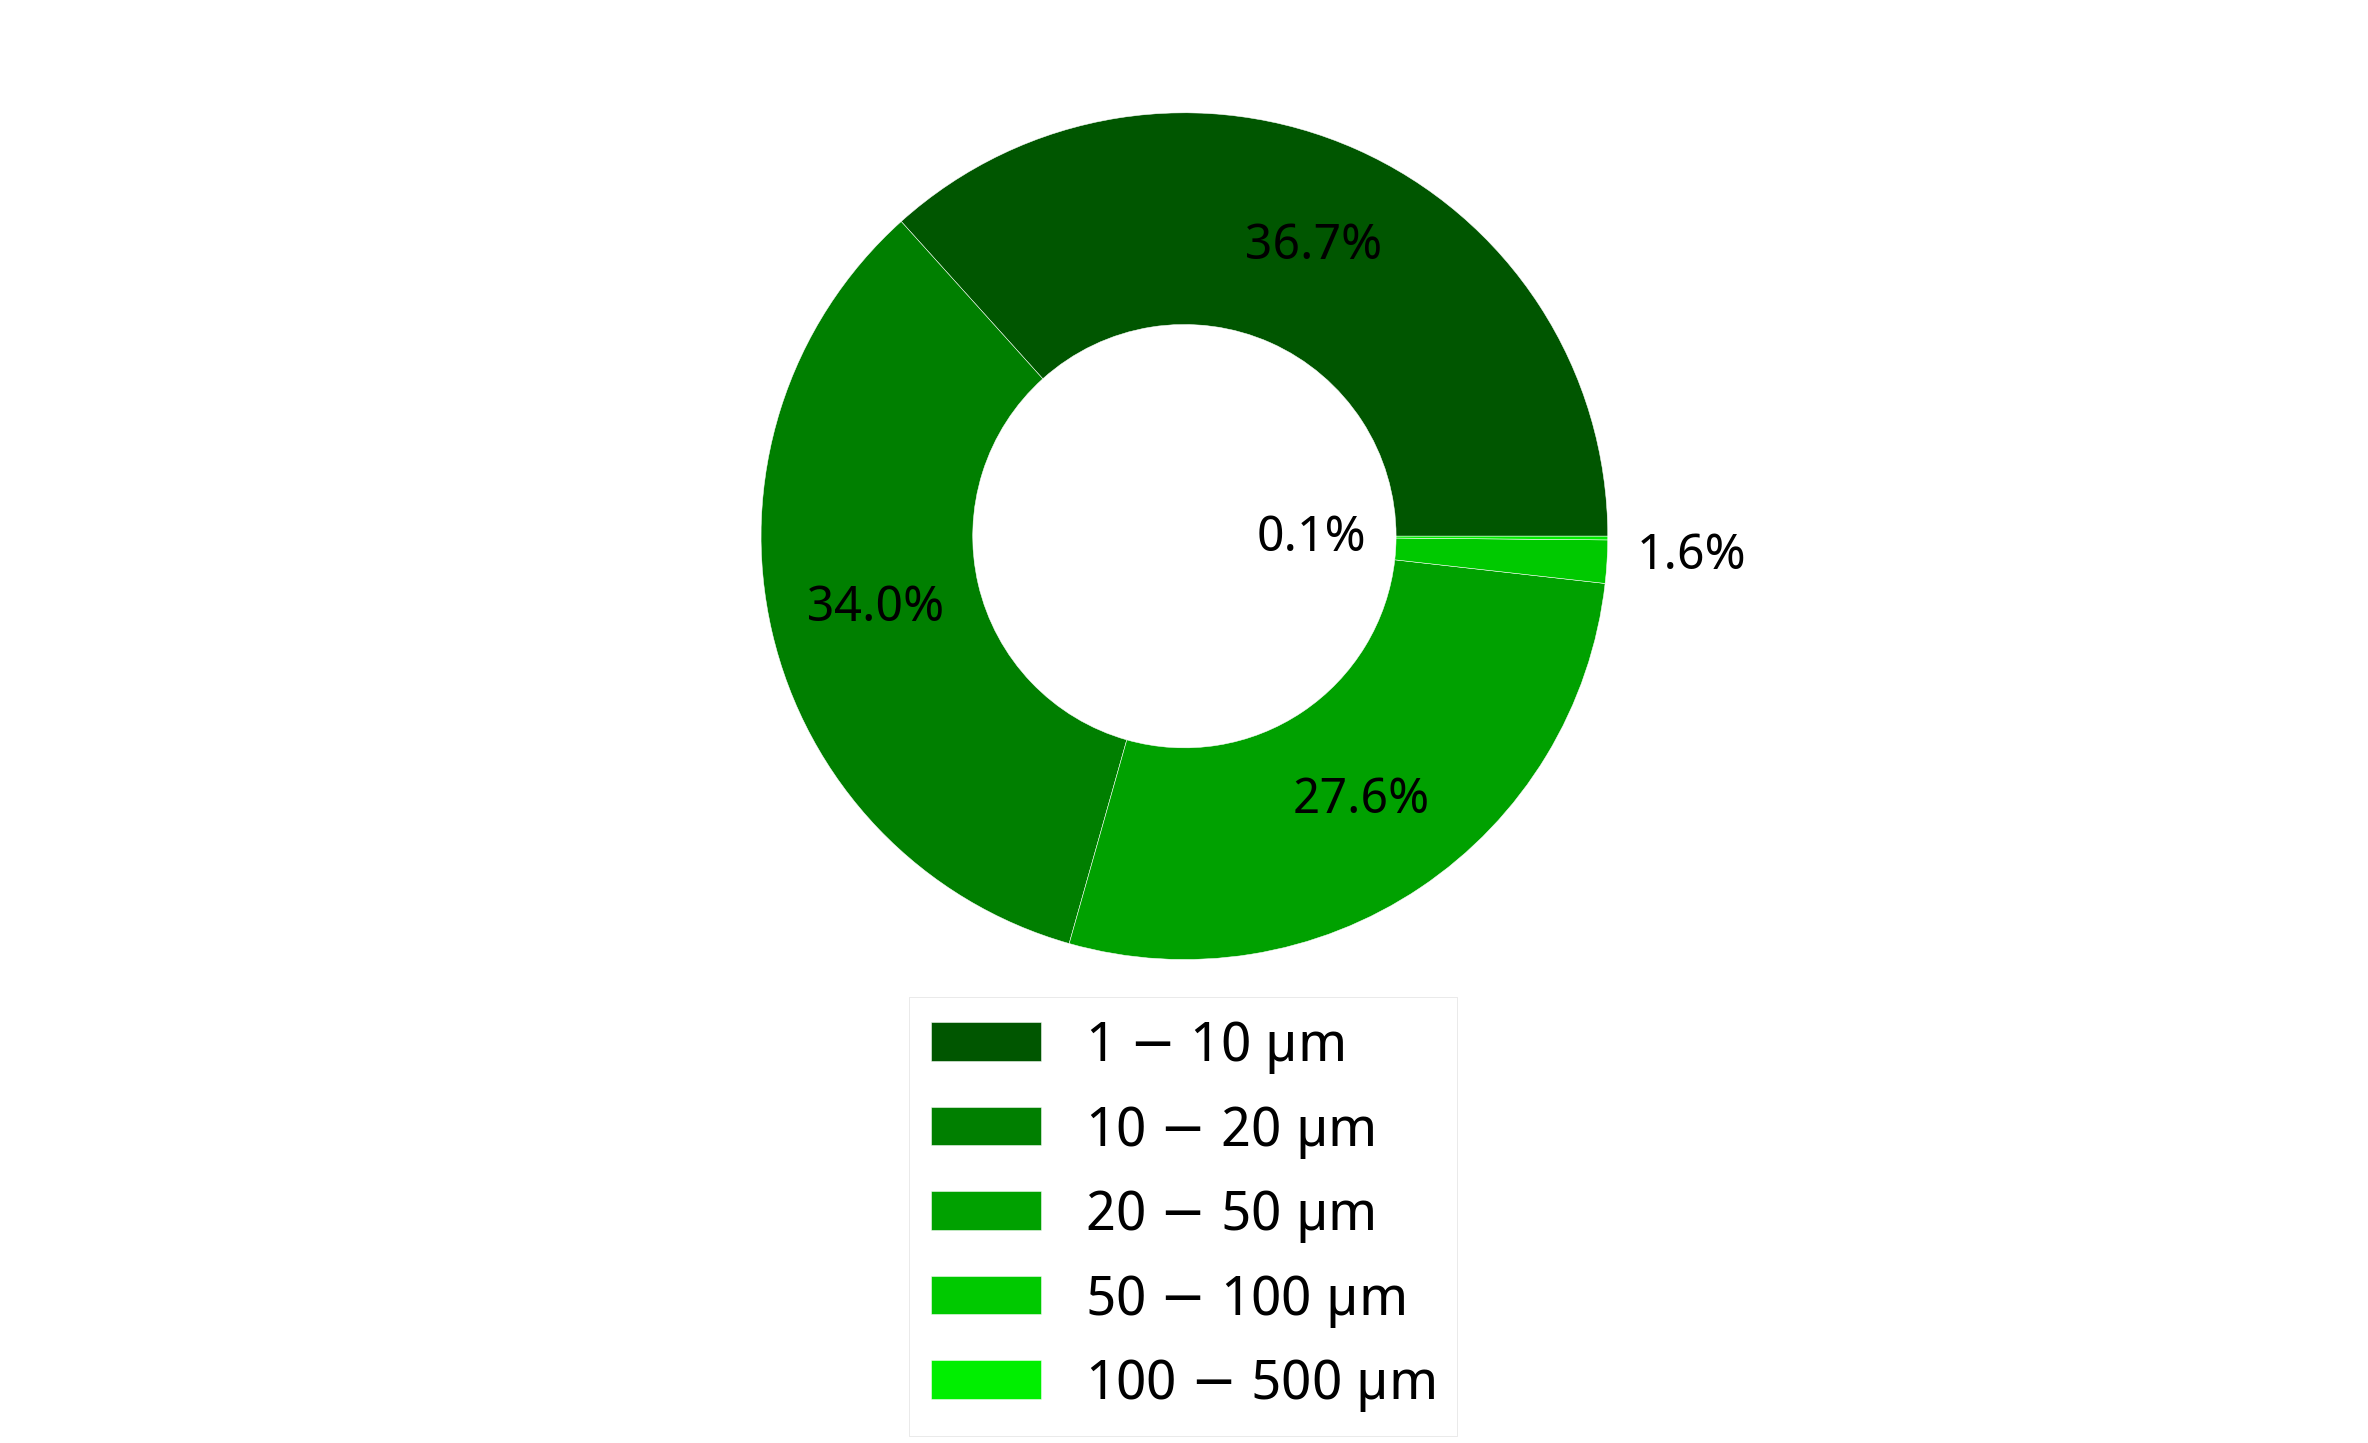

In [29]:
create_pie_chart('PCLHAro', 
                 './data/pcl_results/Diameter_evaluation/', 
                 [(1,10), (10,20), (20, 50), (50,100), (100,500)], 
                 data_folder_name=None, 
                 title='diameter',
                 type='d', 
                 unit_scale=1.8,
                 color_name='green',
                 measure_type='Non_vol',
                 legend_fonsize=55)

Max: 439.199981689, Min: 0.0
1-10: 45013
10-20: 37582
20-50: 29041
50-100: 964
100-500: 10


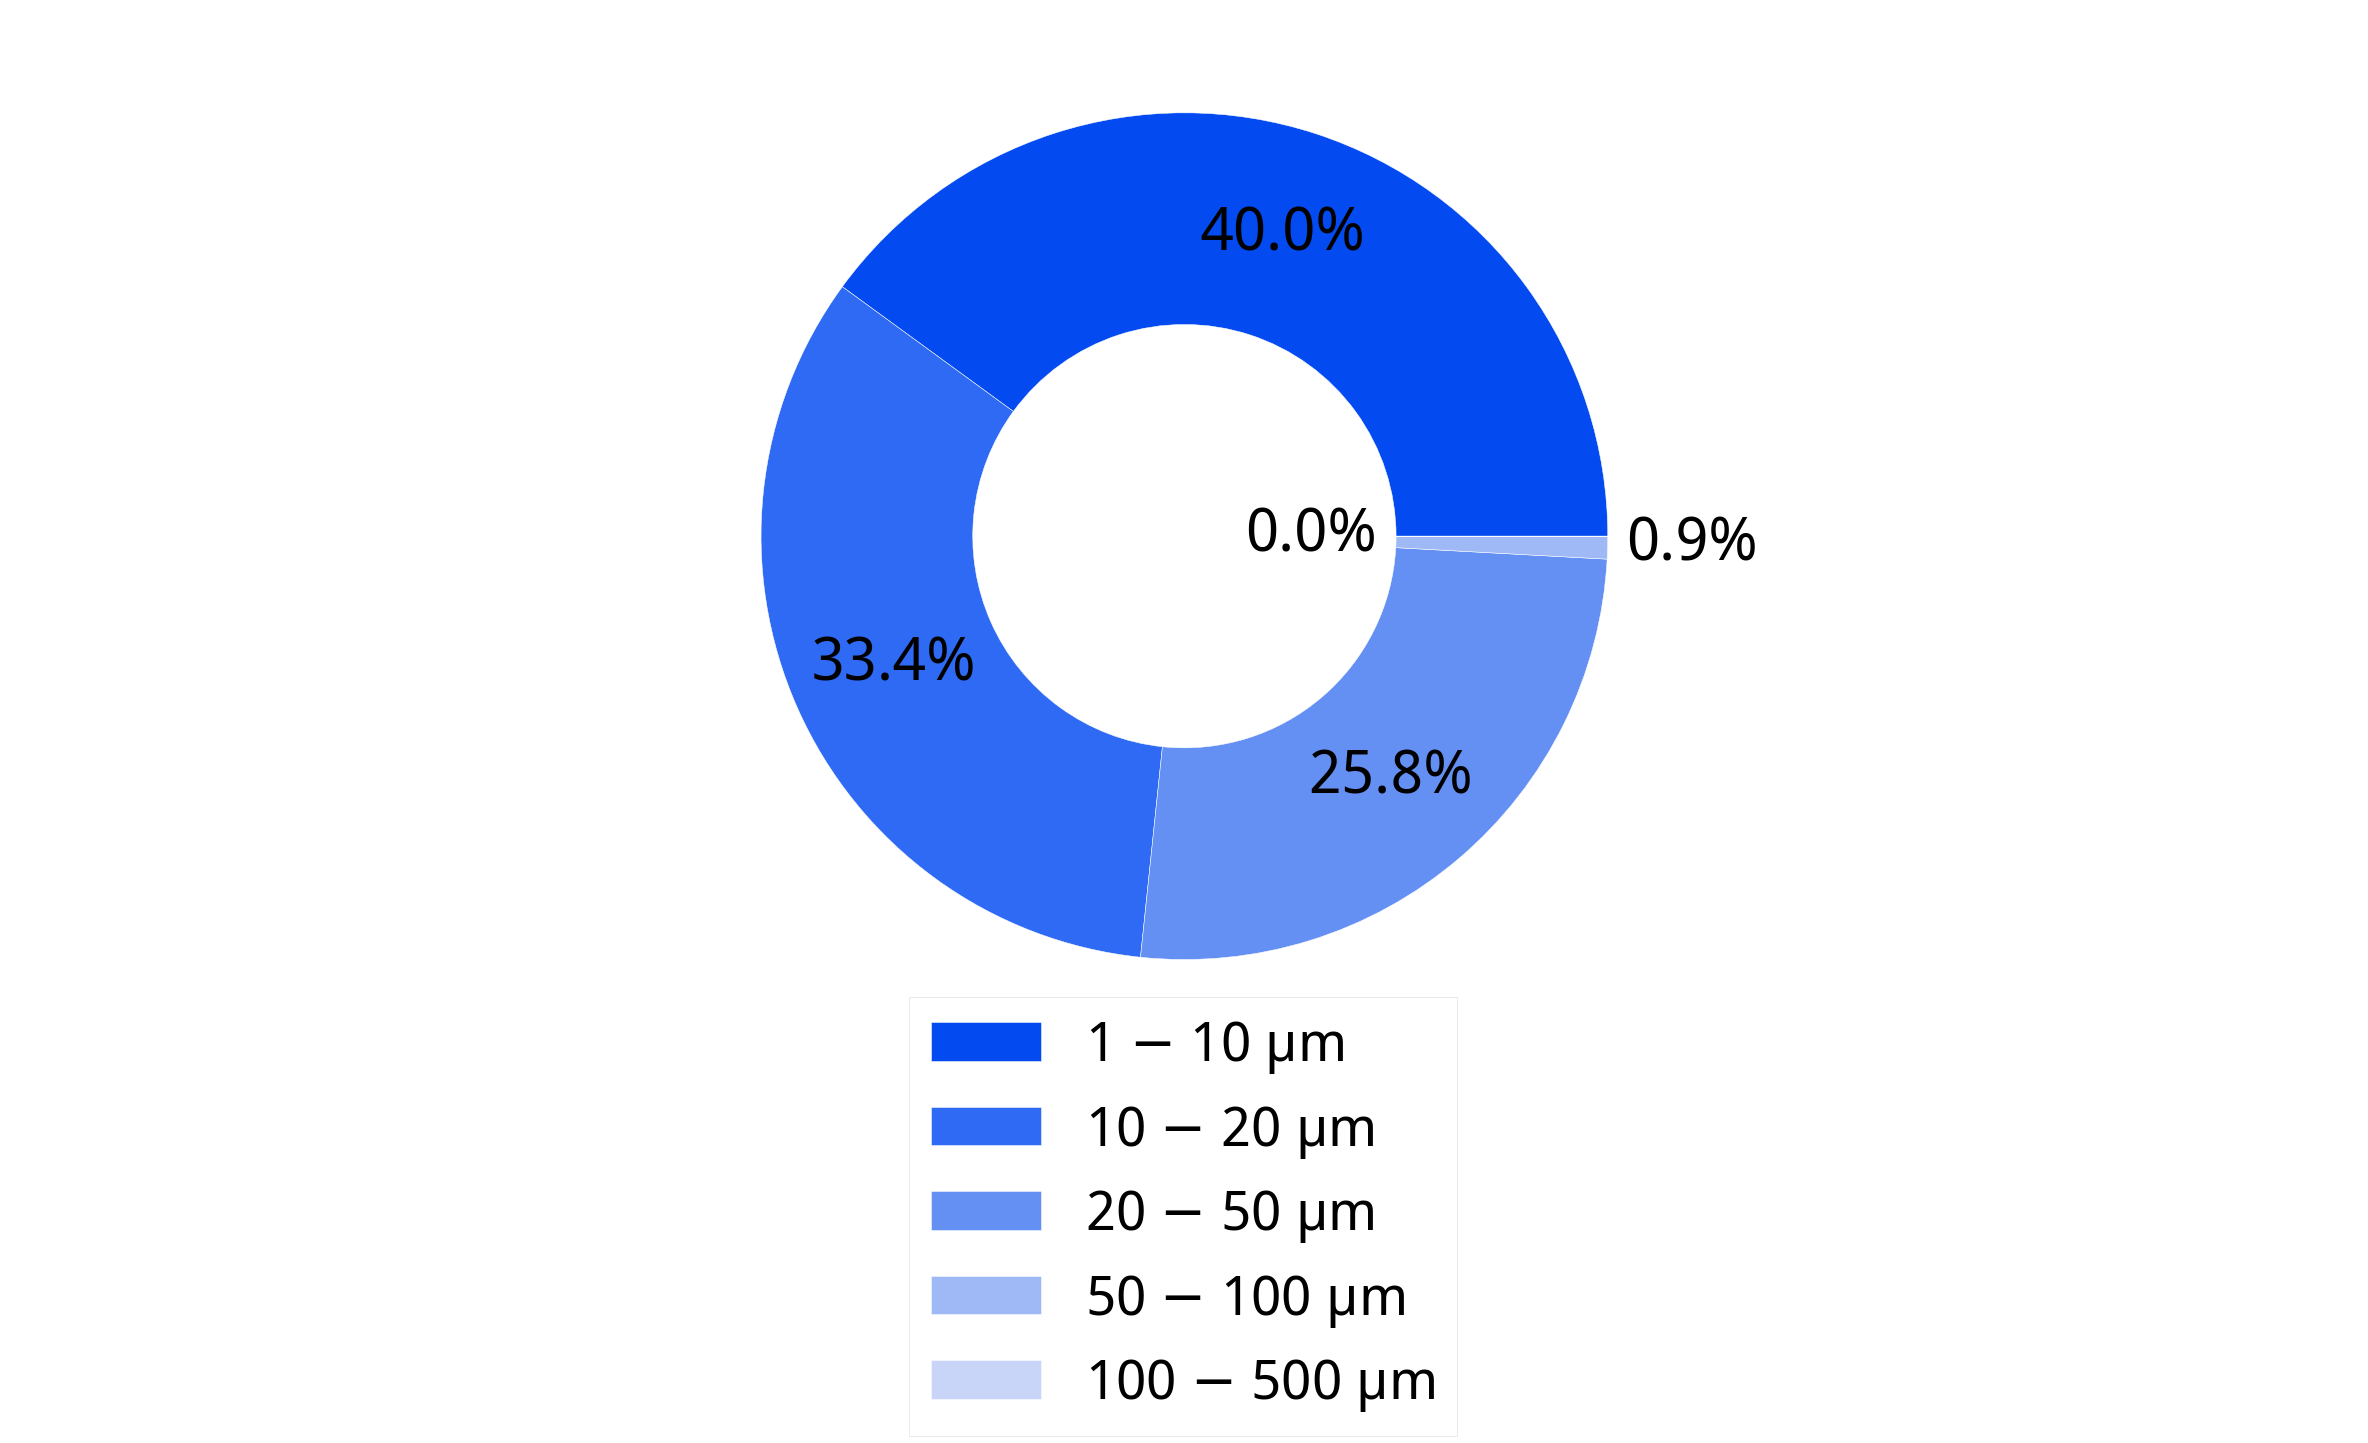

In [316]:
create_pie_chart('PCLSiro', 
                 './data/pcl_results/Diameter_evaluation/', 
                 [(1,10), (10,20), (20, 50), (50,100), (100,500)], 
                 data_folder_name=None, 
                 title='diameter',
                 type='d', 
                 unit_scale=1.8,
                 color_name='blue',
                 measure_type='Non_vol',
                 legend_fonsize=55)

Max: 439.199981689, Min: 0.0
1-10: 84112
10-20: 75173
20-50: 61645
50-100: 6806
100-500: 1343


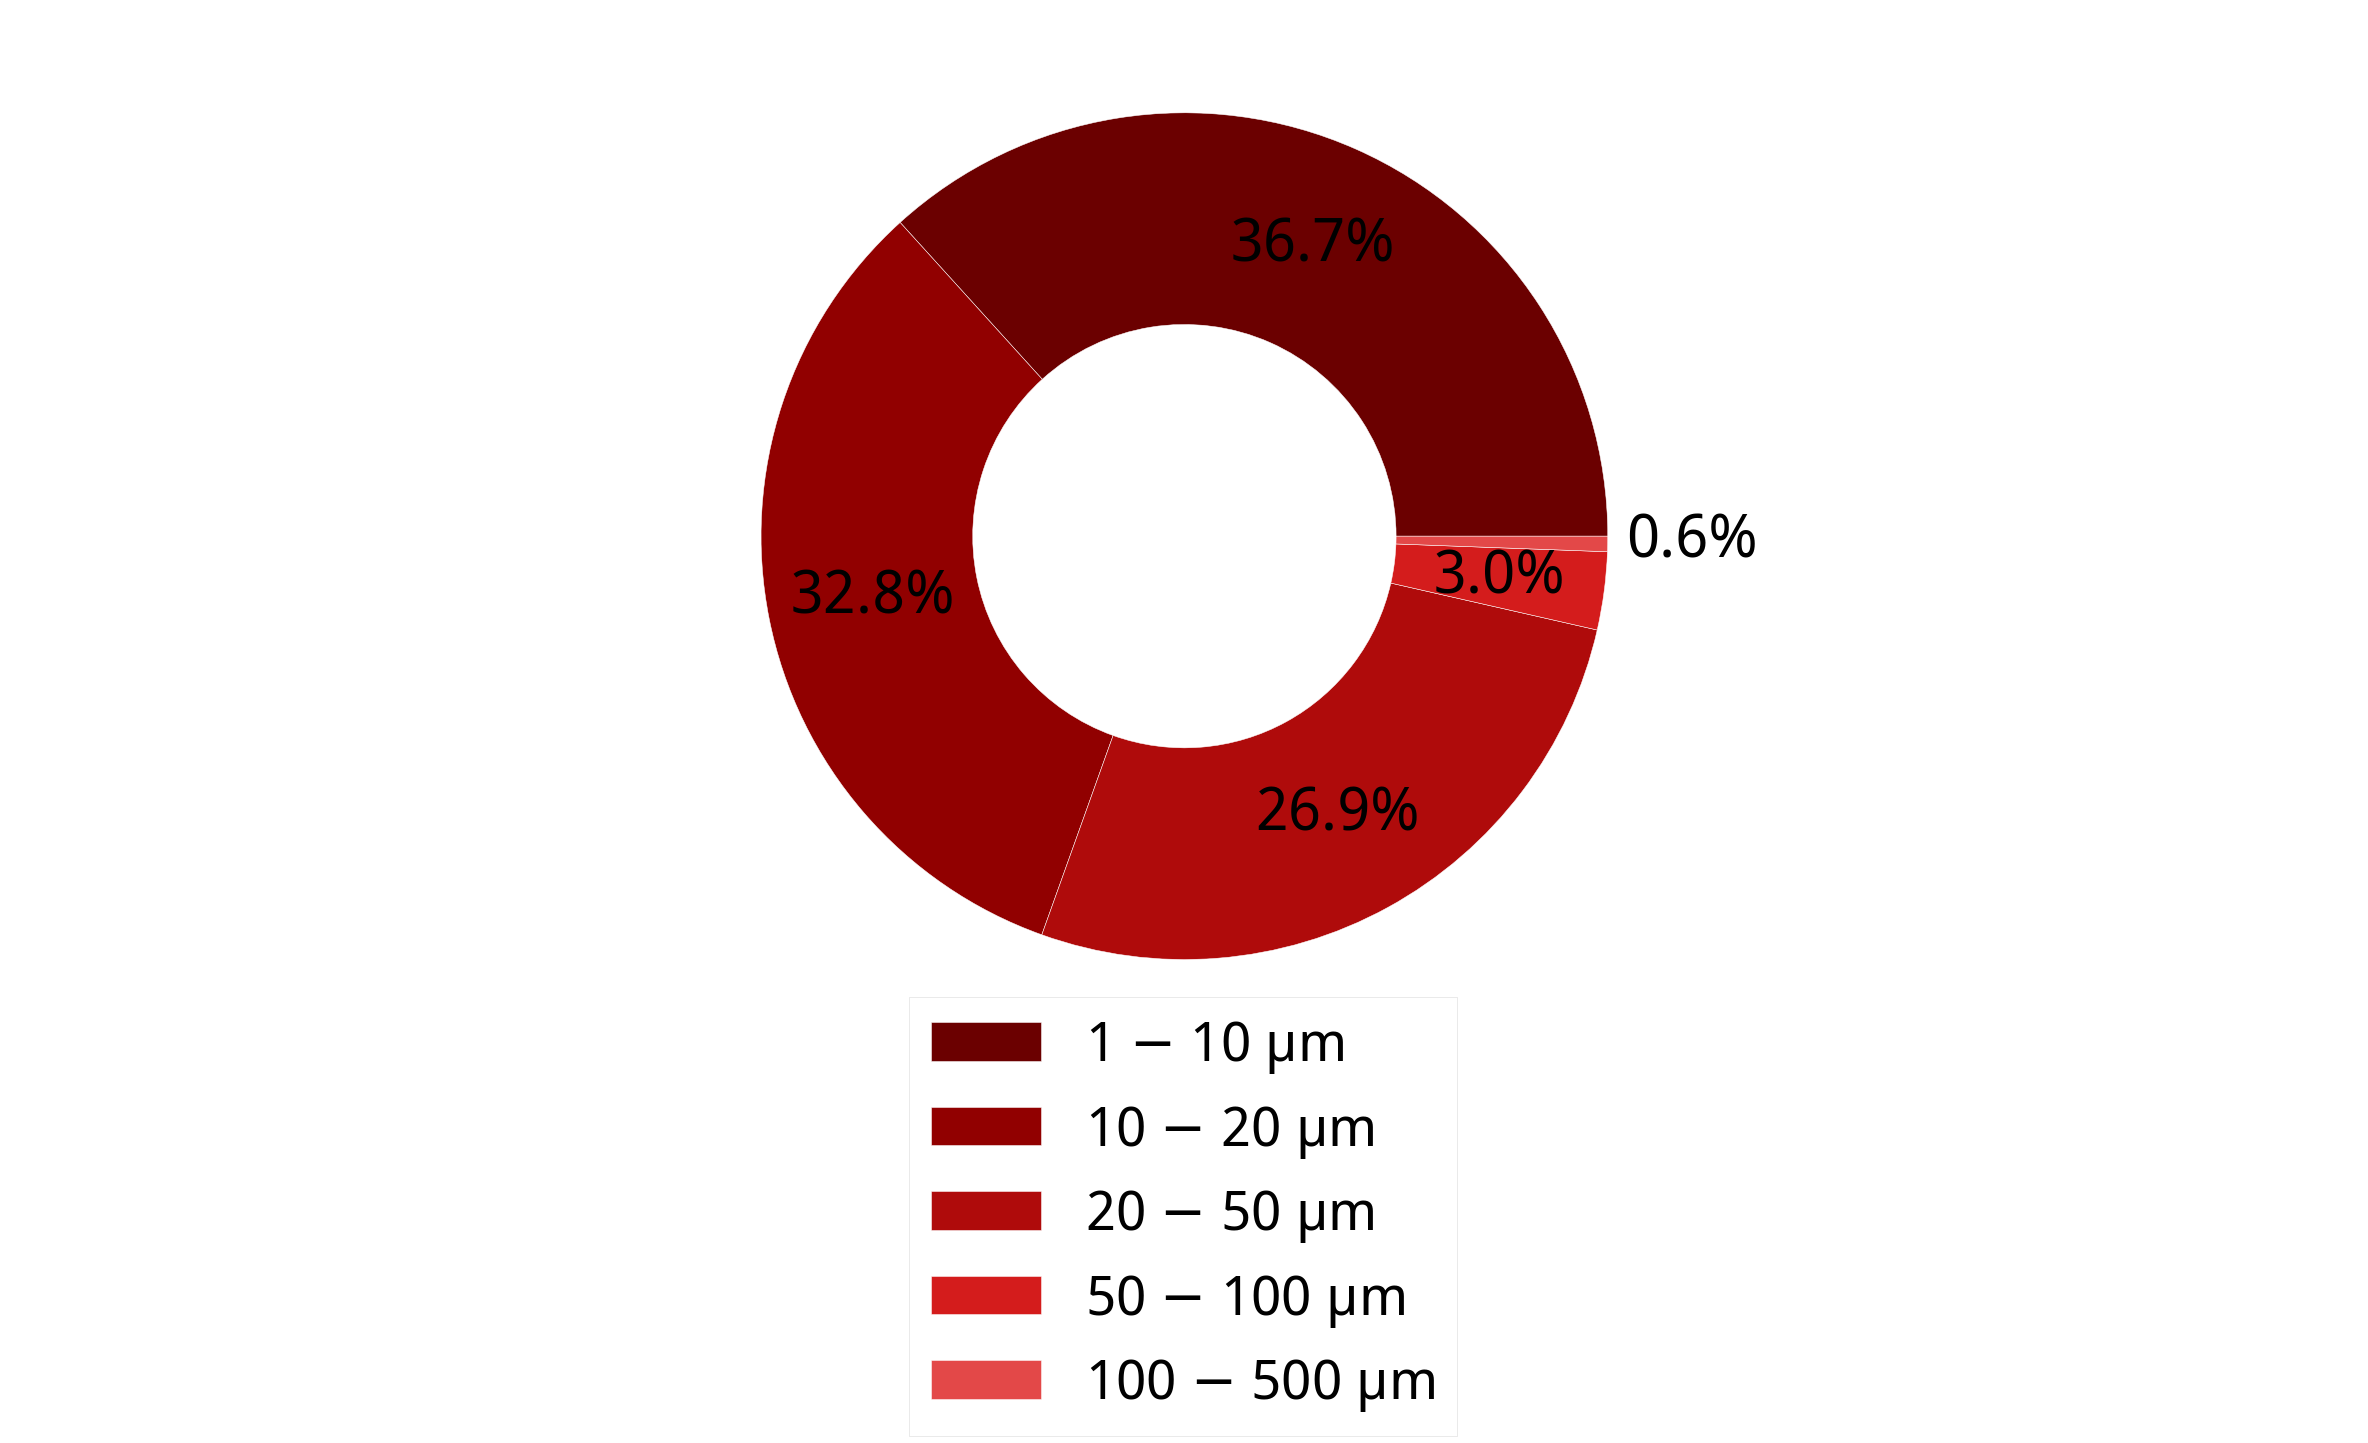

In [317]:
create_pie_chart('PCLSrro', 
                 './data/pcl_results/Diameter_evaluation/', 
                 [(1,10), (10,20), (20, 50), (50,100), (100,500)], 
                 data_folder_name=None, 
                 title='diameter',
                 type='d', 
                 unit_scale=1.8,
                 color_name='red',
                 measure_type='Non_vol',
                 legend_fonsize=55)

# Diameter (median 4 rad)

Max: 439.199981689, Min: 0.0
PCLHAro
(1 - 10) [3.59992599487 - 7.2001414299]
(10 - 20) [10.7997779846 - 18.0003528595]
(20 - 30) [21.5995635986 - 28.8005657196]
(30 - 50) [32.399394989 - 46.8007926941]
Sample: (PCLHAro, diameter) Mean: 20.0860729218  Std: 10.7391424179
Num of particles: 128545
1-10: 19271
10-20: 52422
20-30: 32647
30-50: 24205


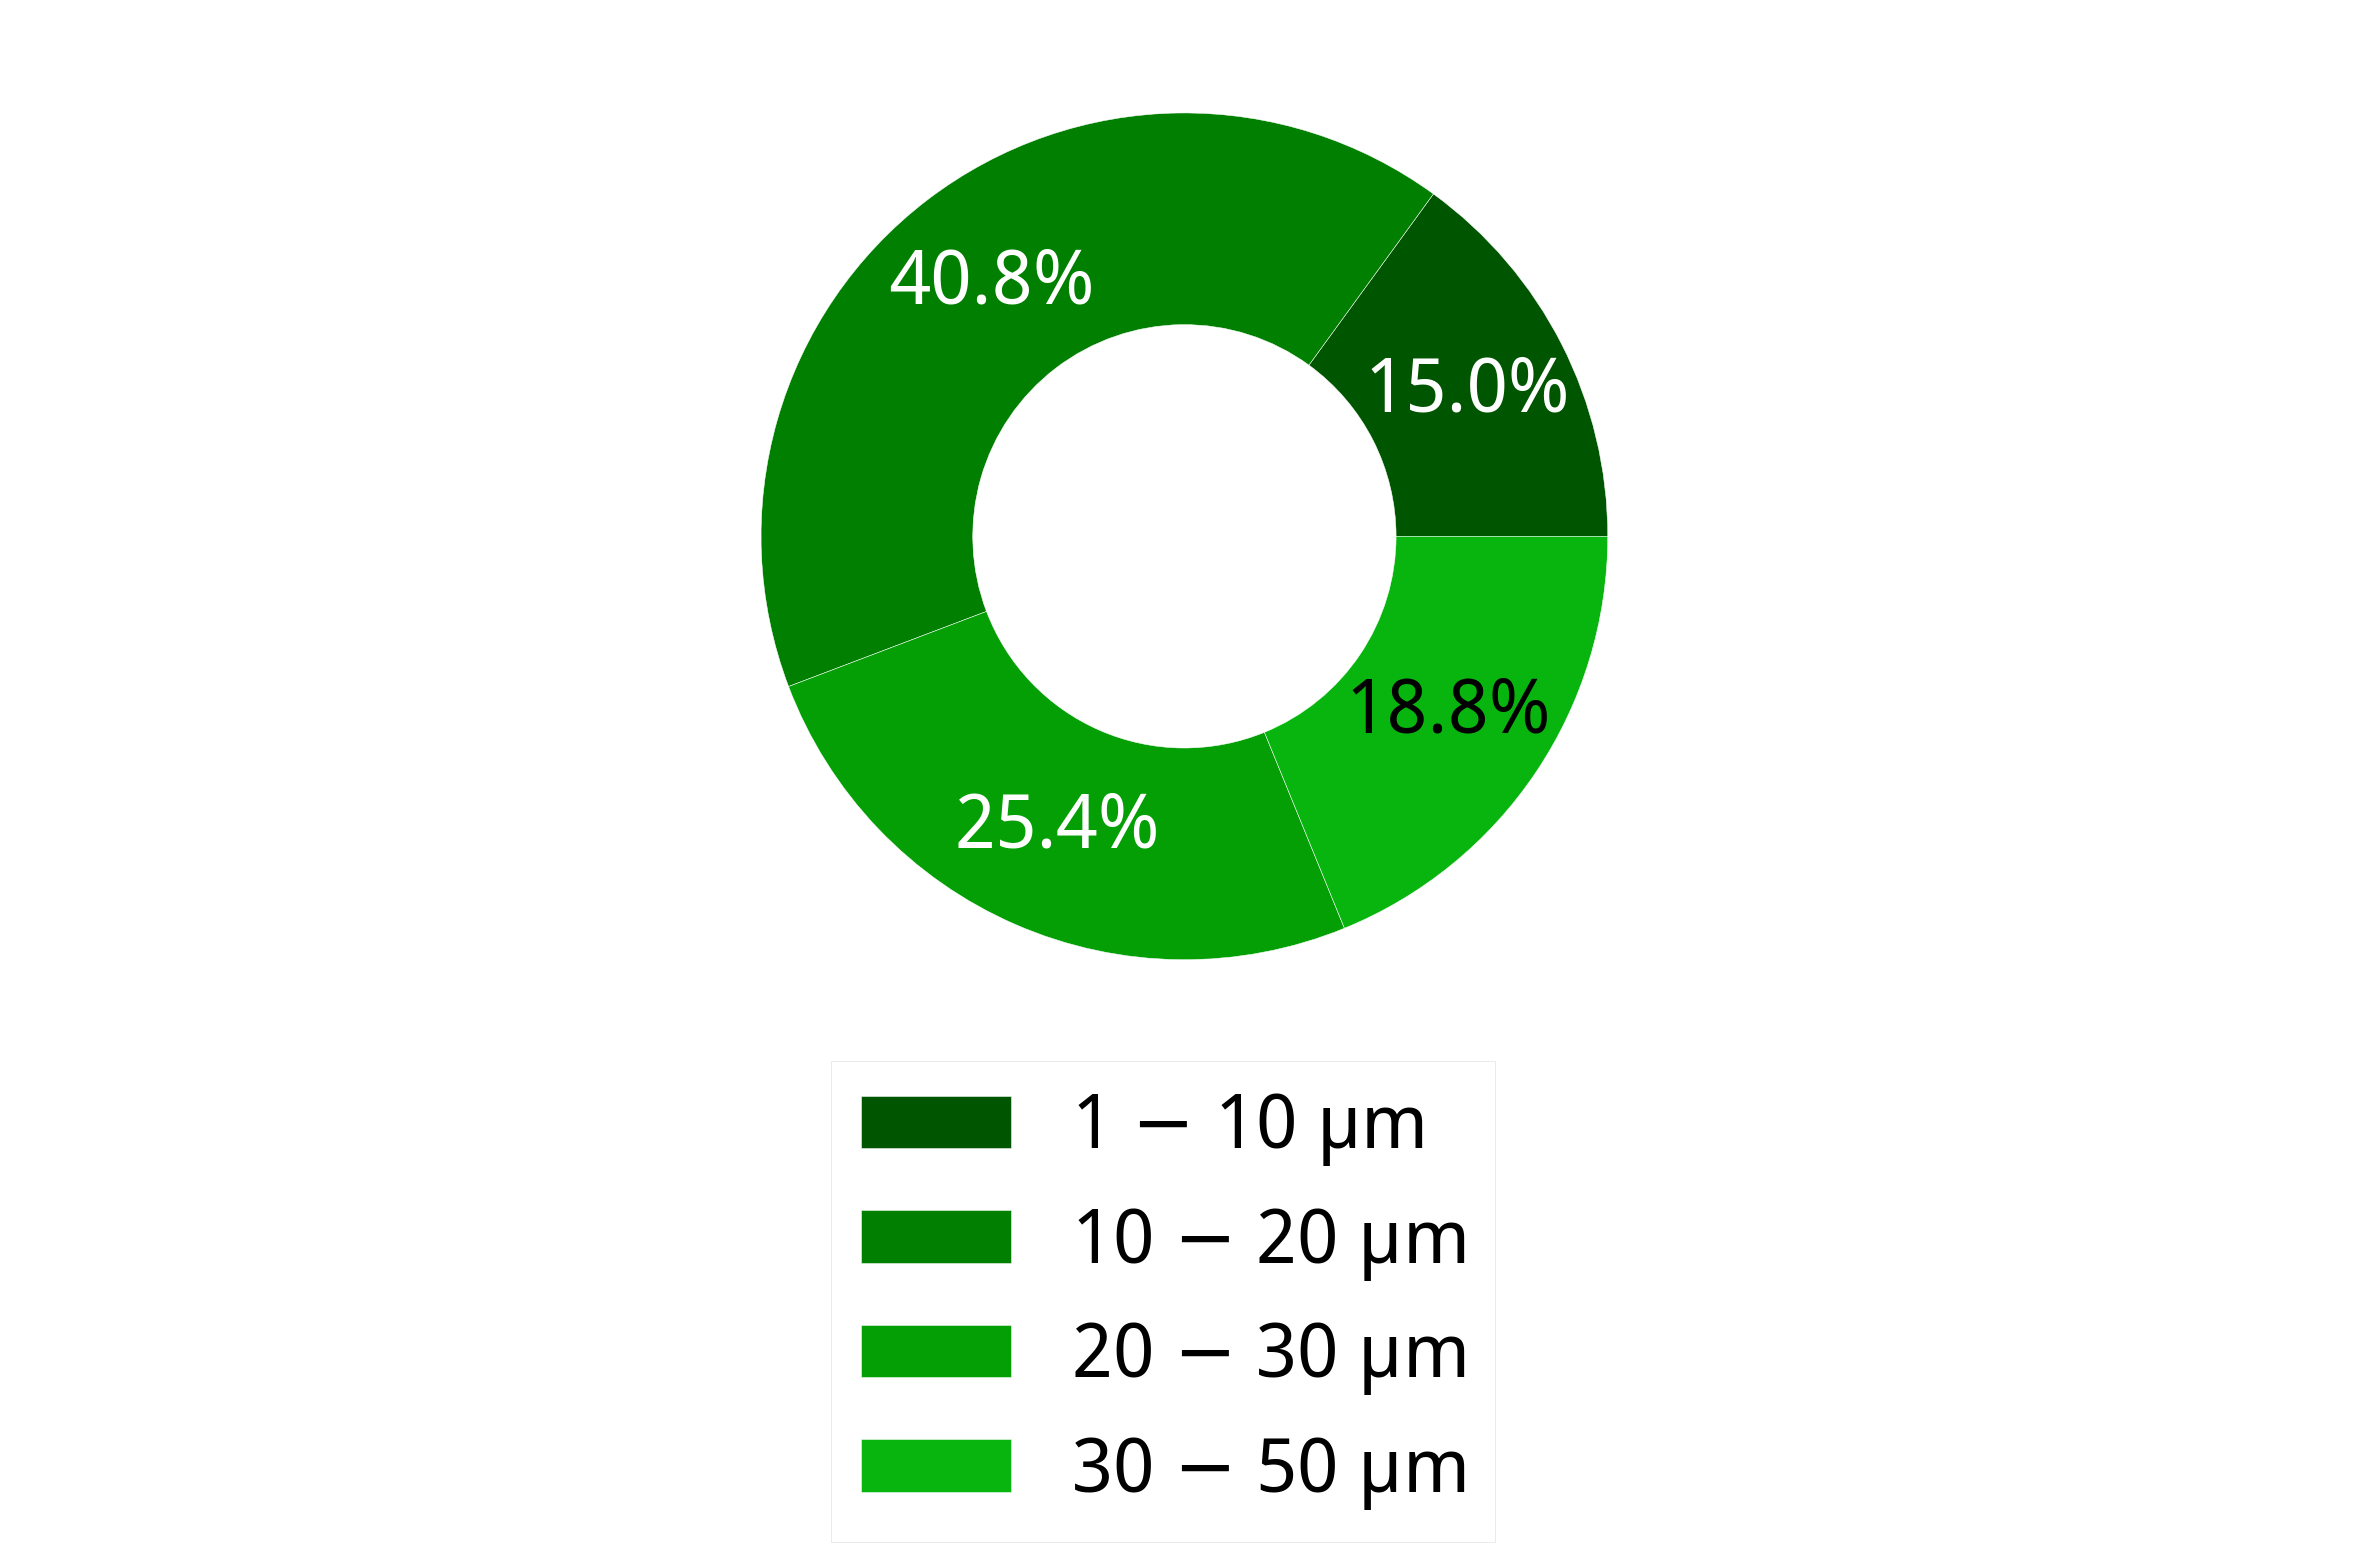

In [103]:
create_pie_chart_v3('PCLHAro', 
                    './data/pcl_results/Diameter_evaluation_median4/',
                    './data/pcl_results/results_diameter', 
                    [(1,10), (10,20), (20,30), (30,50)],
                    title='diameter', \
                    type='d',
                    unit_scale=1.8,
                    lang='en',
                    measure_type='Non_vol', 
                    zebra_color=(True,3),
                    legend_fontsize=75,
                    legend_loc=(0.35,-0.45),
                    chart_fontsize=75,
                    dpi=72,
                    color_name='green',
                    in_voxels=False)

Max: 439.199981689, Min: 0.0
PCLSiro
(1 - 10) [3.59992599487 - 7.2001414299]
(10 - 20) [10.7997779846 - 18.0003051758]
(20 - 30) [21.5995826721 - 28.8005657196]
(30 - 50) [32.399394989 - 46.8007659912]
Sample: (PCLSiro, diameter) Mean: 18.7848968506  Std: 10.356751442
Num of particles: 69455
1-10: 13937
10-20: 27093
20-30: 18146
30-50: 10279


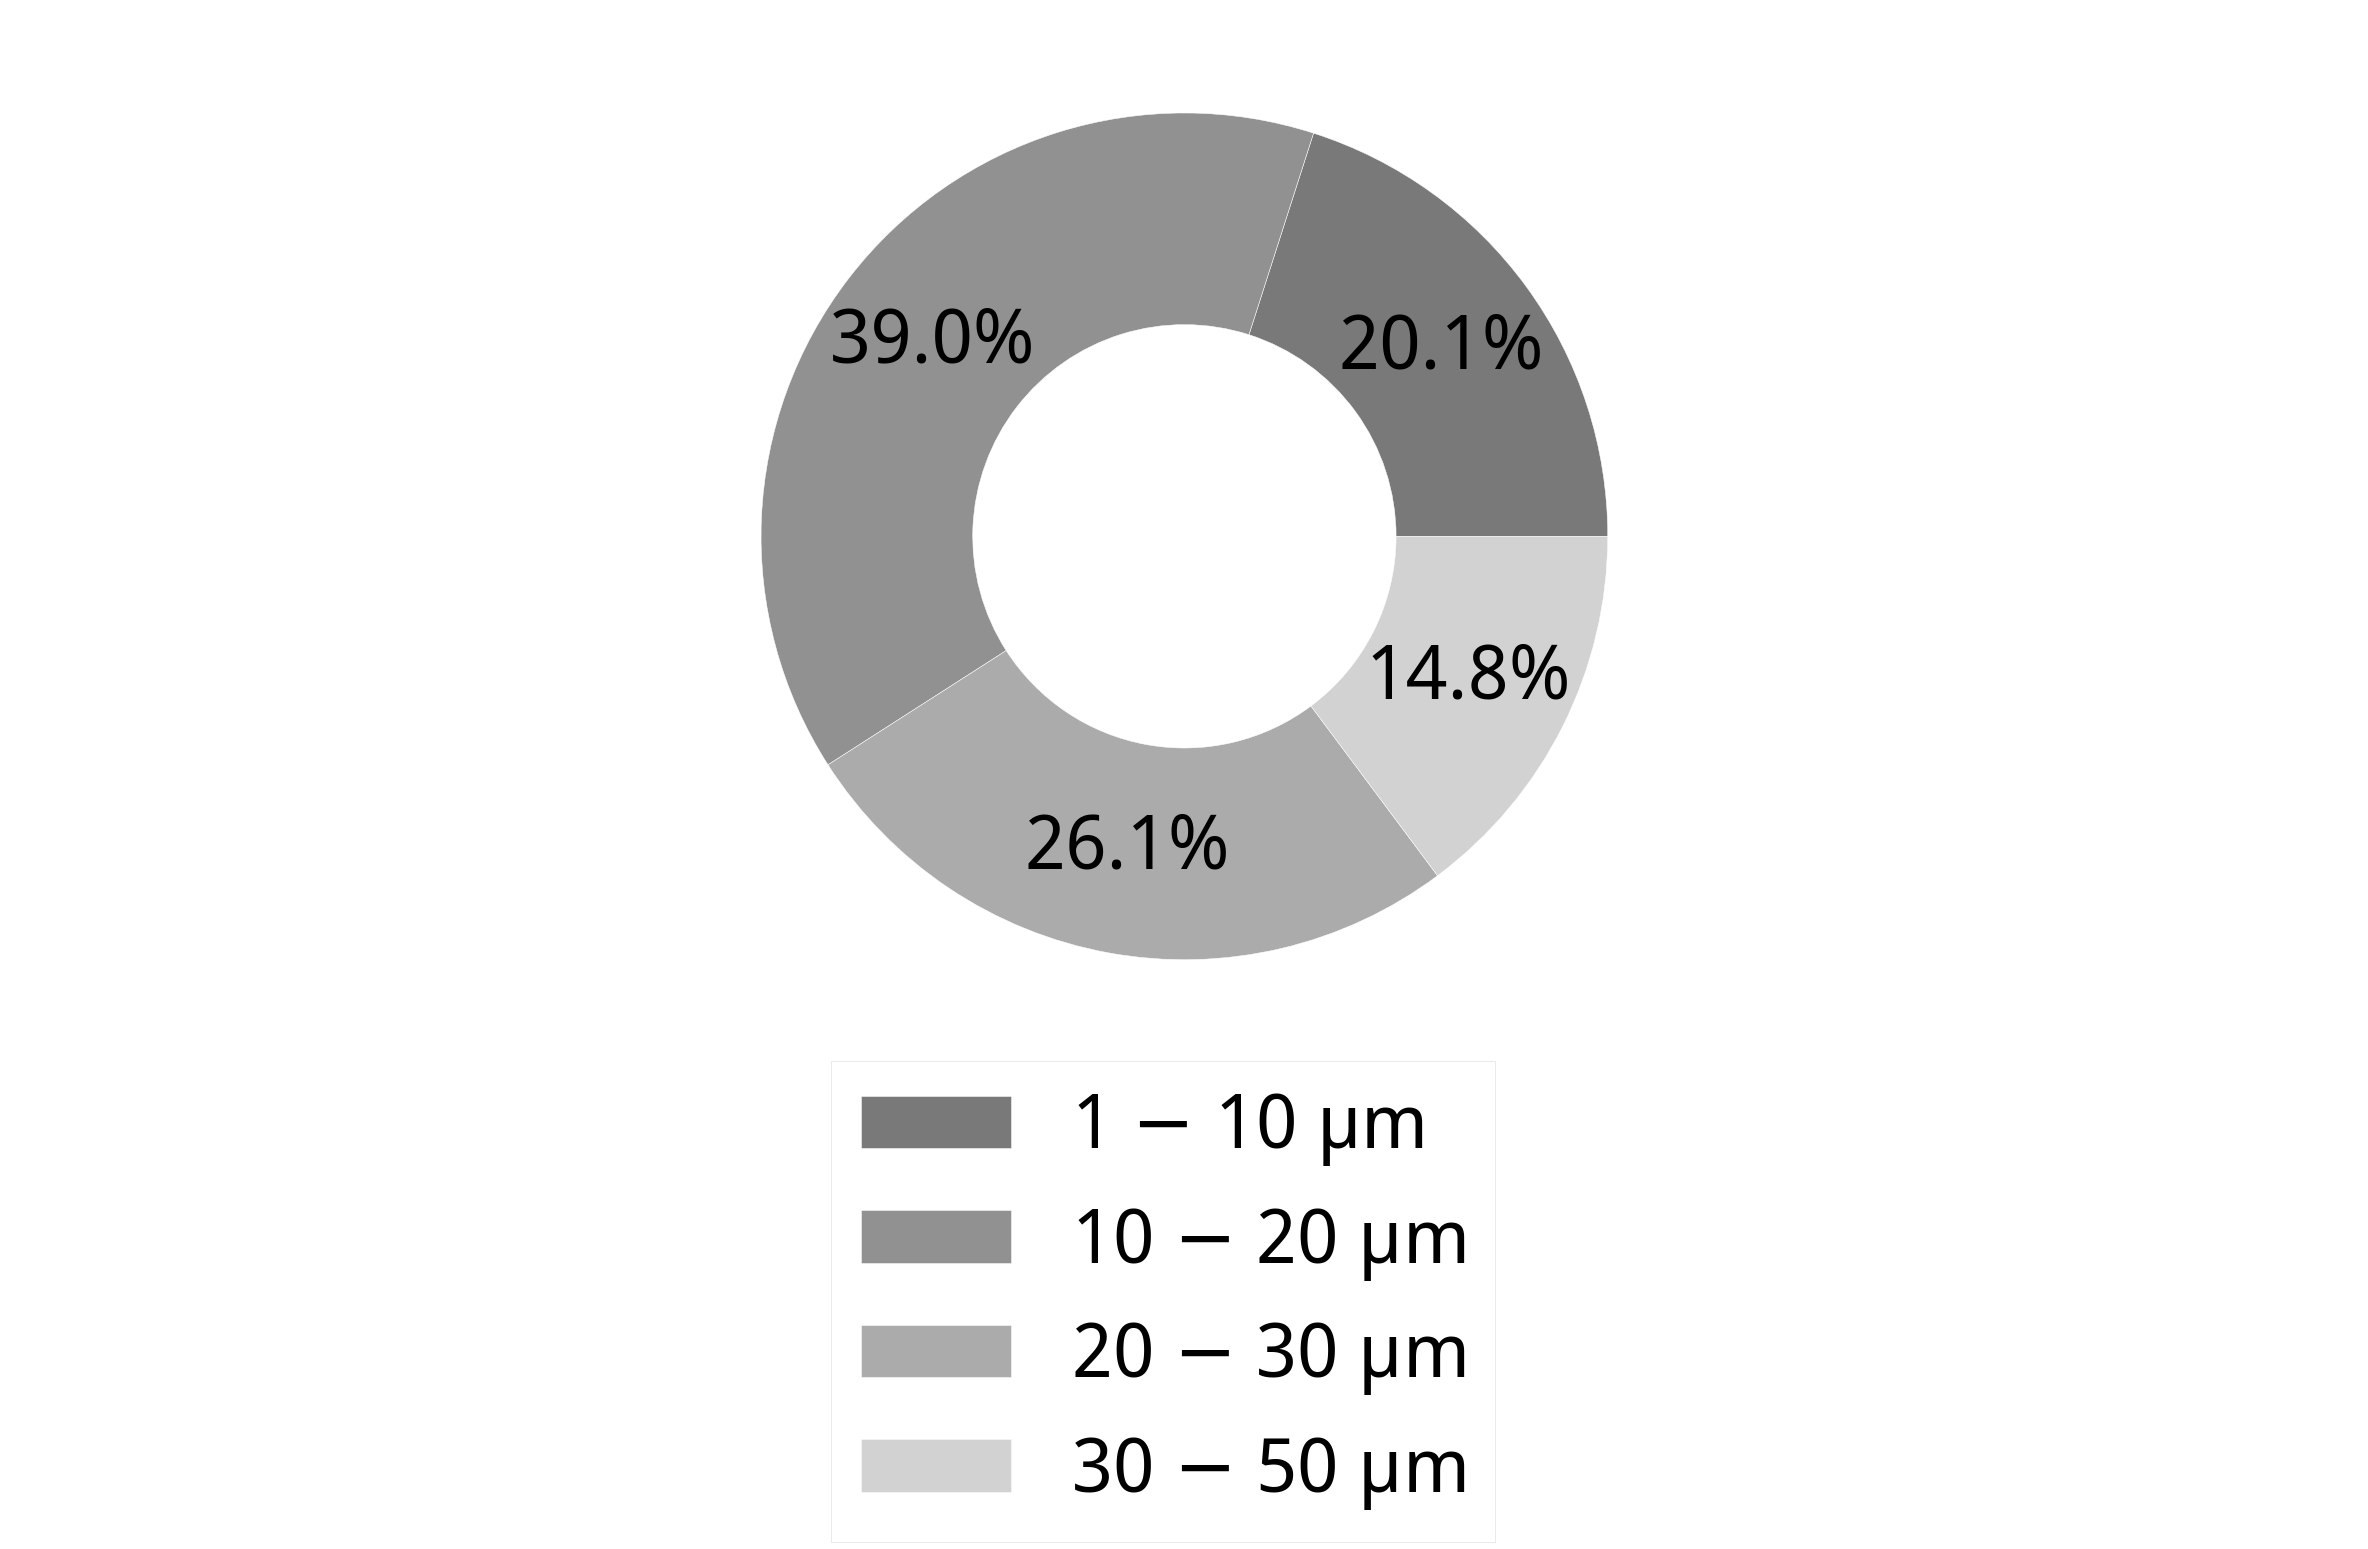

In [104]:
create_pie_chart_v3('PCLSiro', 
                    './data/pcl_results/Diameter_evaluation_median4/',
                    './data/pcl_results/results_diameter', 
                    [(1,10), (10,20), (20,30), (30,50)],
                    title='diameter', \
                    type='d',
                    unit_scale=1.8,
                    lang='en',
                    measure_type='Non_vol', 
                    zebra_color=(False,3),
                    legend_fontsize=75,
                    legend_loc=(0.35,-0.45),
                    chart_fontsize=75,
                    dpi=72,
                    color_name='gray',
                    in_voxels=False)

Max: 439.199981689, Min: 0.0
PCLSrro
(1 - 10) [3.59992599487 - 7.2001414299]
(10 - 20) [10.7997779846 - 18.0003528595]
(20 - 30) [21.599571228 - 28.8005657196]
(30 - 50) [32.3993721008 - 46.8009185791]
Sample: (PCLSrro, diameter) Mean: 20.316904068  Std: 11.2185811996
Num of particles: 163177
1-10: 26045
10-20: 64208
20-30: 39947
30-50: 32977


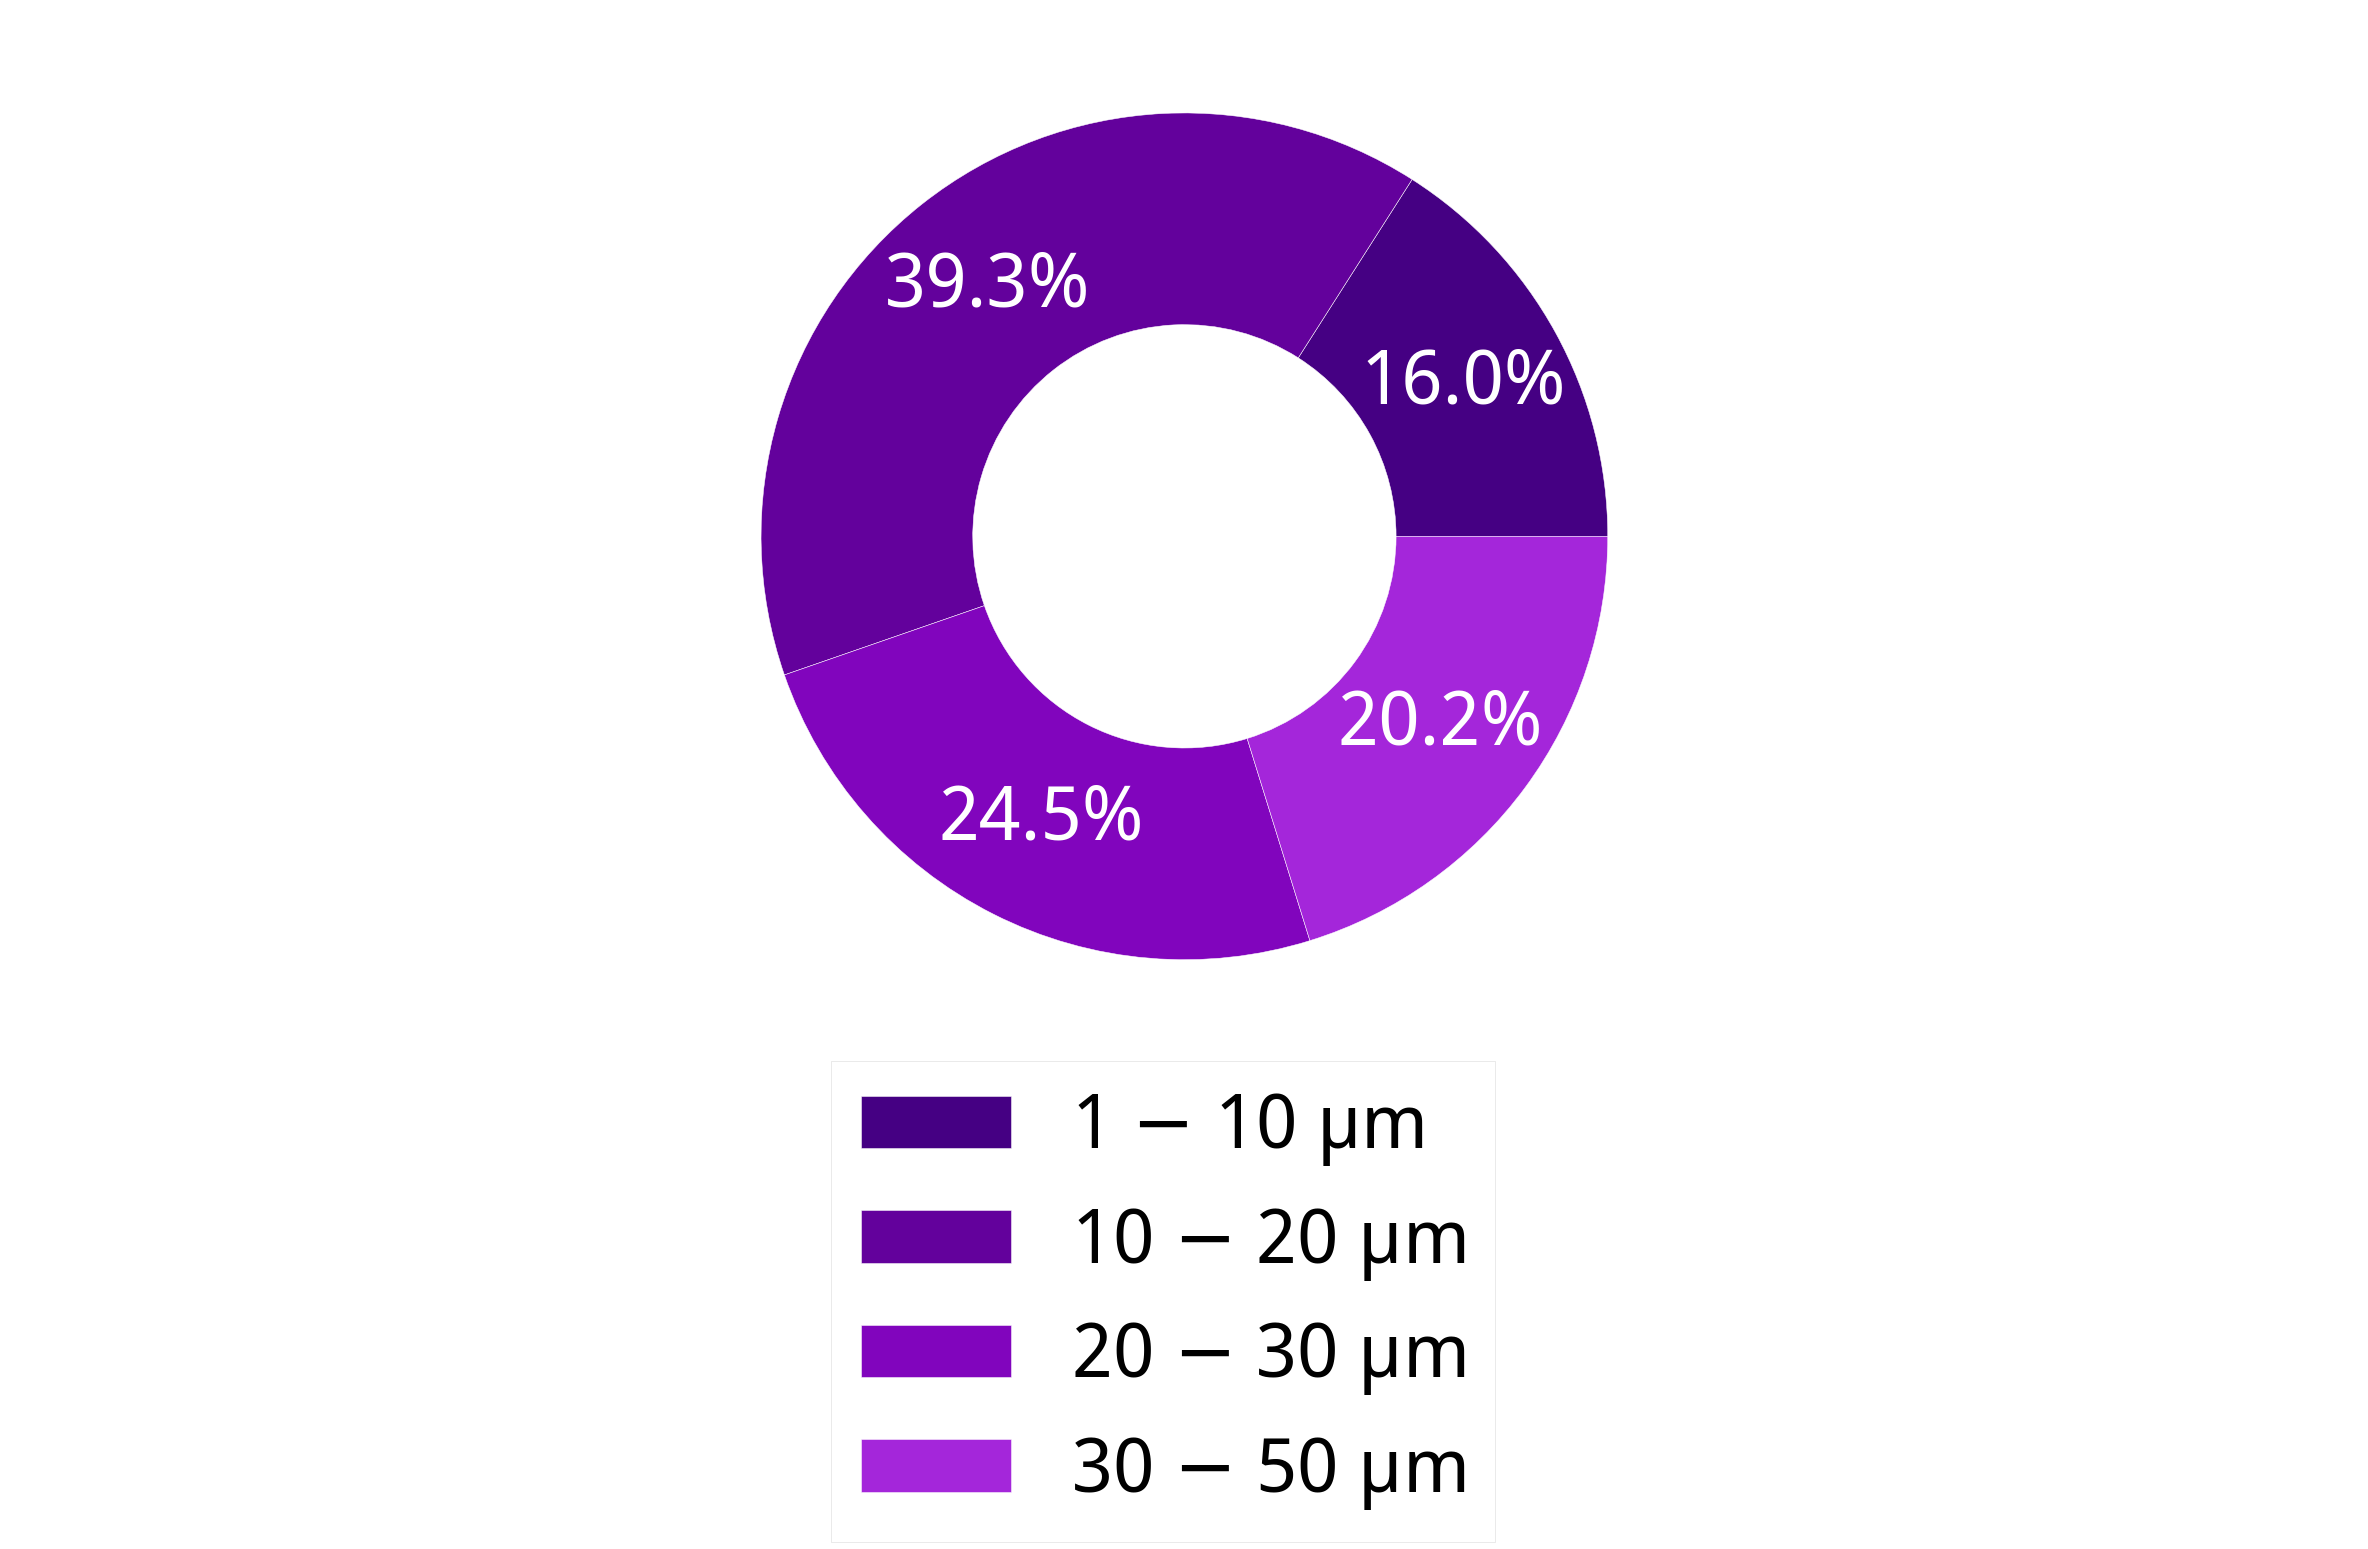

In [105]:
create_pie_chart_v3('PCLSrro', 
                    './data/pcl_results/Diameter_evaluation_median4/',
                    './data/pcl_results/results_diameter', 
                    [(1,10), (10,20), (20,30), (30,50)],
                    title='diameter', \
                    type='d',
                    unit_scale=1.8,
                    lang='en',
                    measure_type='Non_vol', 
                    zebra_color=(True,4),
                    legend_fontsize=75,
                    legend_loc=(0.35,-0.45),
                    chart_fontsize=75,
                    dpi=72,
                    color_name='violet',
                    in_voxels=False)

Max: 32.3998756409, Min: 0.0
PCLro
(1 - 10) [3.59992599487 - 7.20014238358]
(10 - 20) [10.7997779846 - 18.0002536774]
(20 - 30) [21.5996627808 - 28.8000297546]
(30 - 50) [32.3998756409 - 32.3998756409]
Sample: (PCLro, diameter) Mean: 9.3320274353  Std: 2.90574121475
Num of particles: 319882
1-10: 148688
10-20: 170957
20-30: 236
30-50: 1


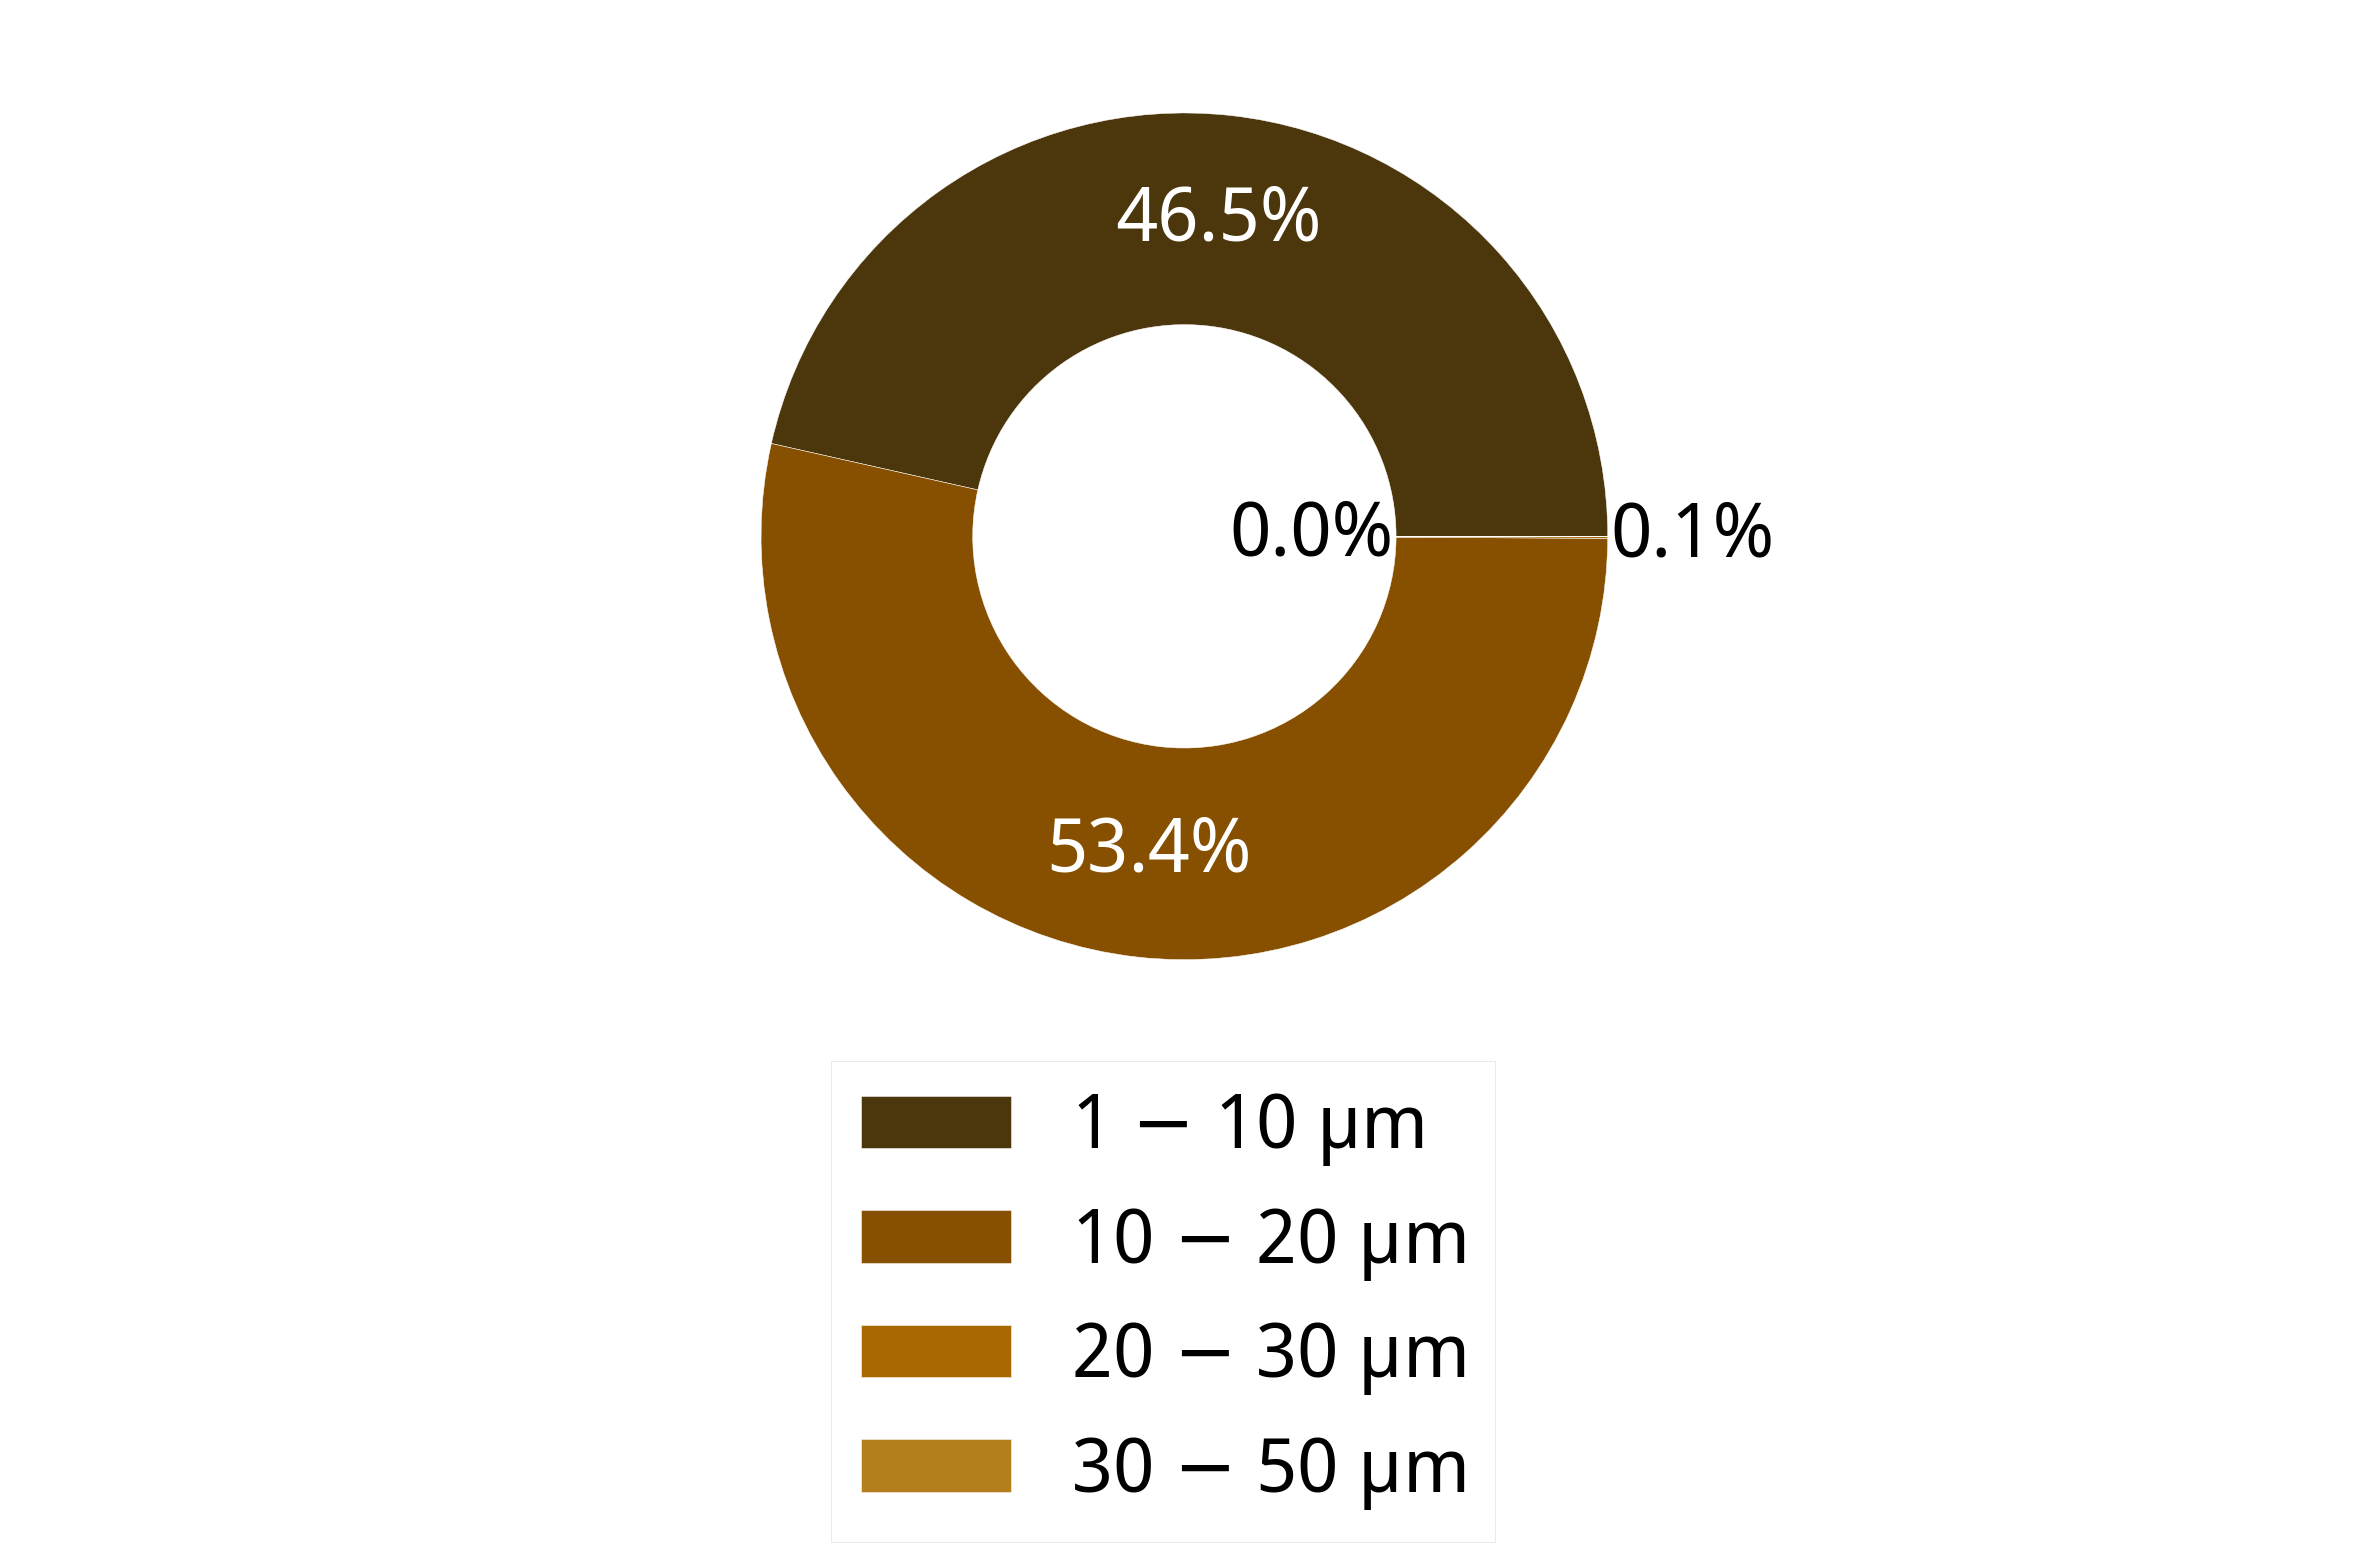

In [109]:
create_pie_chart_v3('PCLro', 
                    './data/pcl_results/Diameter_evaluation_median4/',
                    './data/pcl_results/results_diameter', 
                    [(1,10), (10,20), (20,30), (30,50)],
                    title='diameter', \
                    type='d',
                    unit_scale=1.8,
                    lang='en',
                    measure_type='Non_vol', 
                    zebra_color=(True,2),
                    legend_fontsize=75,
                    legend_loc=(0.35,-0.45),
                    chart_fontsize=75,
                    dpi=72,
                    color_name='orange',
                    in_voxels=False)